# Heart Failure Clinical Records Dataset - Lab 7

#### MinMax Normalization

In [1]:
import ds_functions as ds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, validation_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.metrics as metrics
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score, silhouette_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from subprocess import call
from scipy.spatial.distance import pdist, squareform
import random

data: pd.DataFrame = pd.read_csv('datasets/heart_failure_clinical_records_dataset.csv')
original_data = data.copy()
target = 'DEATH_EVENT'

transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(data)
df_nr = pd.DataFrame(transf.transform(data), columns= data.columns)
norm_data_minmax = df_nr
# norm_data_minmax, data_unbalanced

In [2]:
def balancing(trnX, trnY, undersample, oversample):
    #undersample, oversample = 1,0 => undersample
    #undersample, oversample = 0,1 => oversample
    unique, counts = np.unique(trnY, return_counts=True)
    
    min_positive_counts = min(counts)
    min_negative_counts = max(counts)+(min(counts)-max(counts))*undersample
    newtrnY: np.ndarray = []
    newtrnX: np.ndarray = []
    for idx in range(len(trnY)):
        if min_positive_counts > 0 and trnY[idx] == 1:
            newtrnY.append(trnY[idx])
            newtrnX.append(trnX[idx])
            min_positive_counts -= 1
        elif min_negative_counts > 0 and trnY[idx] == 0:
            newtrnY.append(trnY[idx])
            newtrnX.append(trnX[idx])
            min_negative_counts -= 1
            
    unique1, counts1 = np.unique(newtrnY, return_counts=True)
    
    max_positive_counts = min(counts1)+(max(counts1)-min(counts1))*oversample
    max_negative_counts = max(counts1)
    finaltrnY: np.ndarray = []
    finaltrnX: np.ndarray = []
    negX: np.ndarray = []
    posX: np.ndarray = []
    negY: np.ndarray = []
    posY: np.ndarray = []
        
    for idx in range(len(newtrnY)):
        if newtrnY[idx] == 0:
            finaltrnY.append(newtrnY[idx])
            negY.append(newtrnY[idx])
            finaltrnX.append(newtrnX[idx])
            negX.append(newtrnX[idx])
            max_negative_counts -= 1
        elif newtrnY[idx] == 1:
            finaltrnY.append(newtrnY[idx])
            posY.append(newtrnY[idx])
            finaltrnX.append(newtrnX[idx])
            posX.append(newtrnX[idx])
            max_positive_counts -= 1

    random.seed()

    while max_negative_counts > 0:
        rand_num = random.randint(0,len(negX)-1)
        finaltrnX.append(negX[rand_num])
        finaltrnY.append(negY[rand_num])
        max_negative_counts -= 1

    while max_positive_counts > 0:
        rand_num = random.randint(0,len(posX)-1)
        finaltrnX.append(posX[rand_num])
        finaltrnY.append(posY[rand_num])
        max_positive_counts -= 1
    
    return finaltrnX, finaltrnY

### Balancing

In [3]:
data_unbalanced = original_data.copy()

In [4]:
def balancing_v1(data_frame):
    data_frame_to_modify = data_frame.copy()
    target_count = data_frame_to_modify[target].value_counts()
    min_class = target_count.idxmin()
    ind_min_class = target_count.index.get_loc(min_class)

    RANDOM_STATE = 50
    values = {'Original': [target_count.values[ind_min_class], target_count.values[1-ind_min_class]]}

    df_class_min = data_frame_to_modify[data_frame_to_modify[target] == min_class]
    df_class_max = data_frame_to_modify[data_frame_to_modify[target] != min_class]

    df_under = df_class_max.sample(len(df_class_min), random_state=RANDOM_STATE)
    values['UnderSample'] = [target_count.values[ind_min_class], len(df_under)]
    df_over = df_class_min.sample(len(df_class_max), replace=True, random_state=RANDOM_STATE)
    values['OverSample'] = [len(df_over), target_count.values[1-ind_min_class]]
    smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)
    y = data_frame_to_modify.pop(target).values
    X = data_frame_to_modify.values
    smote_X, smote_y = smote.fit_sample(X, y)
    smote_target_count = pd.Series(smote_y).value_counts()
    values['SMOTE'] = [smote_target_count.values[ind_min_class], smote_target_count.values[1-ind_min_class]]

    over_sampled = pd.concat([df_over, df_class_max])
    under_sampled = pd.concat([df_under, df_class_min])
    
    return over_sampled, under_sampled

In [7]:
over_sampled,under_sampled = balancing_v1(original_data)
over_sampled_minmax, under_sampled_minmax = balancing_v1(norm_data_minmax)
non_binary_data = over_sampled.copy()
non_binary_data = non_binary_data.drop(['anaemia','diabetes','high_blood_pressure','sex', 'smoking','DEATH_EVENT'], axis=1)
non_binary_data

age  creatinine_phosphokinase  ejection_fraction  platelets  \
54   60.0                       260                 38   255000.0   
11   62.0                       231                 25   253000.0   
37   82.0                       855                 50   321000.0   
262  65.0                       258                 25   198000.0   
4    65.0                       160                 20   327000.0   
..    ...                       ...                ...        ...   
294  62.0                        61                 38   155000.0   
295  55.0                      1820                 38   270000.0   
296  45.0                      2060                 60   742000.0   
297  45.0                      2413                 38   140000.0   
298  50.0                       196                 45   395000.0   

     serum_creatinine  serum_sodium  time  
54                2.2           132    45  
11                0.9           140    10  
37                1.0           145    30  
262               1.4           129   235  
4                 2.7           116     8  
..                ...           ...   ...  
294               1.1           143   270  
295               1.2           139   271  
296               0.8           138   278  
297               1.4           140   280  
298               1.6           136   285  

[406 rows x 7 columns]

In [5]:
norm_data_minmax.pop(target)
data_unbalanced.pop(target)
print(end='')

<Figure size 600x450 with 0 Axes>

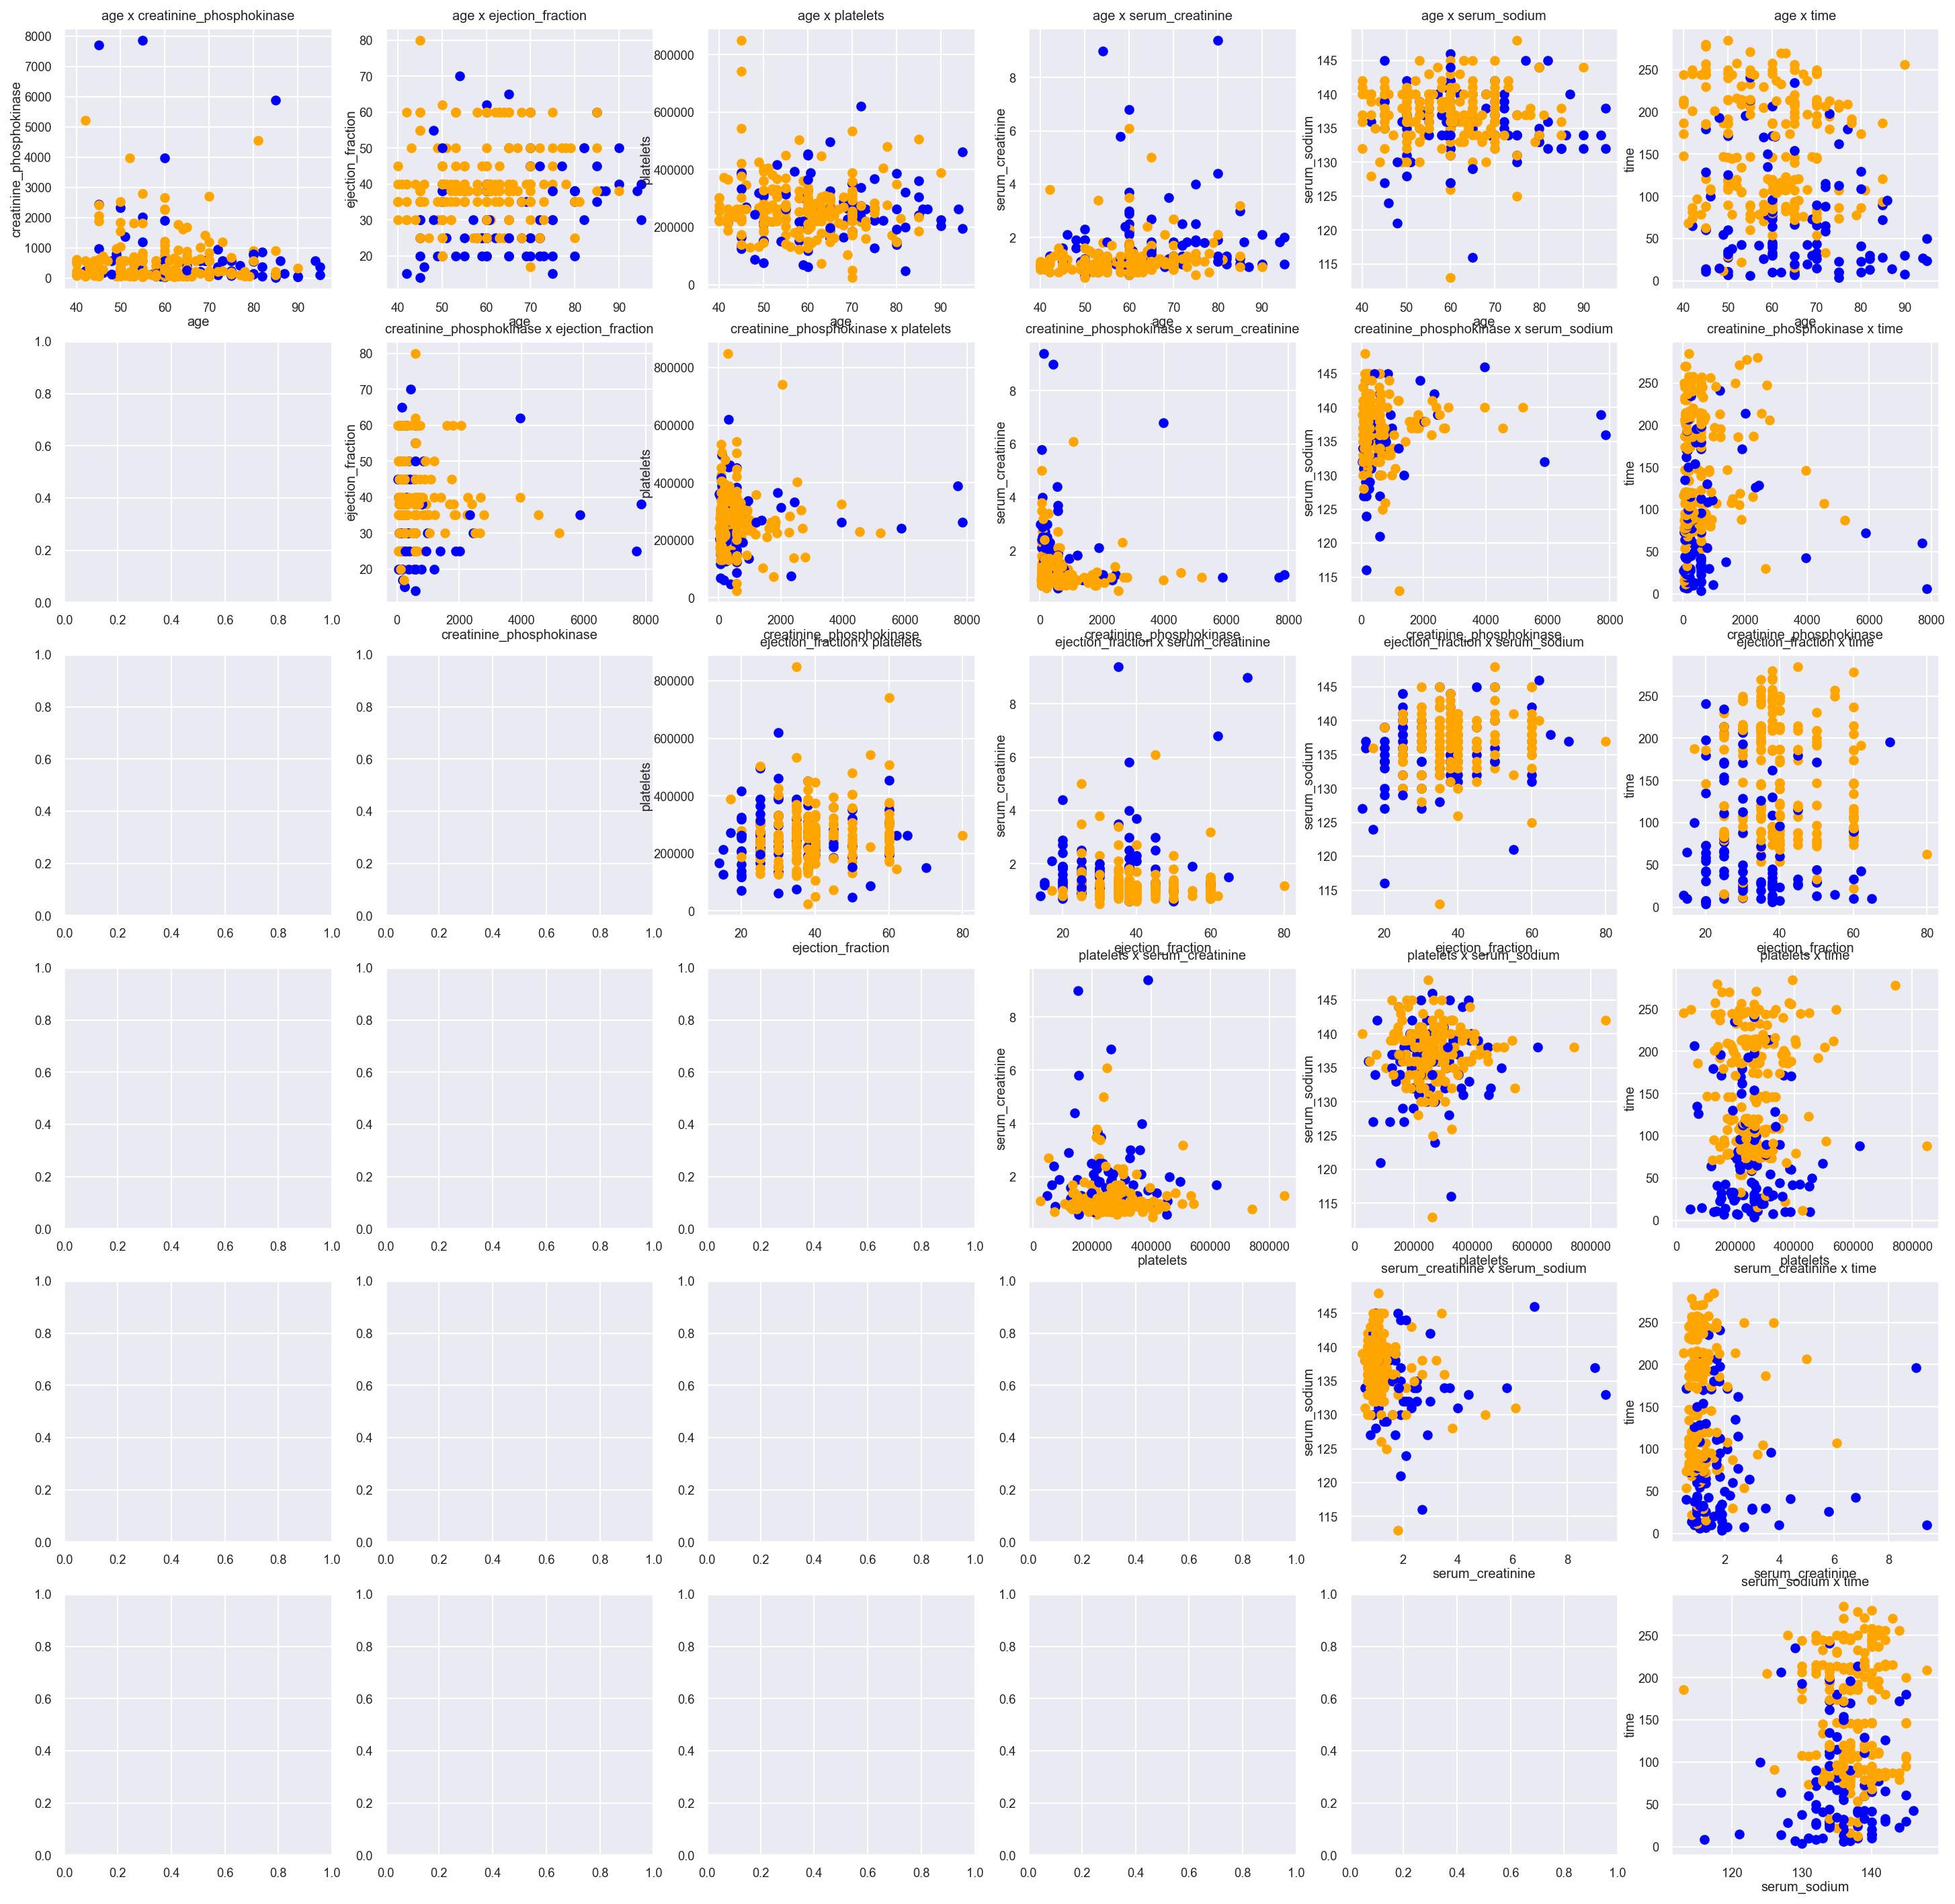

In [45]:
columns = non_binary_data.select_dtypes(include='number').columns
rows, cols = len(columns)-1, len(columns)-1
plt.figure()
fig, axs = plt.subplots(rows, cols, figsize=(cols*4, rows*4), squeeze=False)

for i in range(len(columns)):
    var1 = columns[i]
    for j in range(i+1, len(columns)):
        var2 = columns[j]
        axs[i, j-1].set_title("%s x %s"%(var1,var2))
        axs[i, j-1].set_xlabel(var1)
        axs[i, j-1].set_ylabel(var2)
        
        r=data.iterrows()
        for index, row in r:
            axs[i, j-1].scatter(row[var1], row[var2], color=("orange", "blue")[int(row['DEATH_EVENT'])])
plt.show()

# Clustering

**K-Means Over sampled without scaling**

In [ ]:
v1 = 0
v2 = 4

N_CLUSTERS = [2, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
rows, cols = ds.choose_grid(len(N_CLUSTERS))

over_sampled.pop(target)

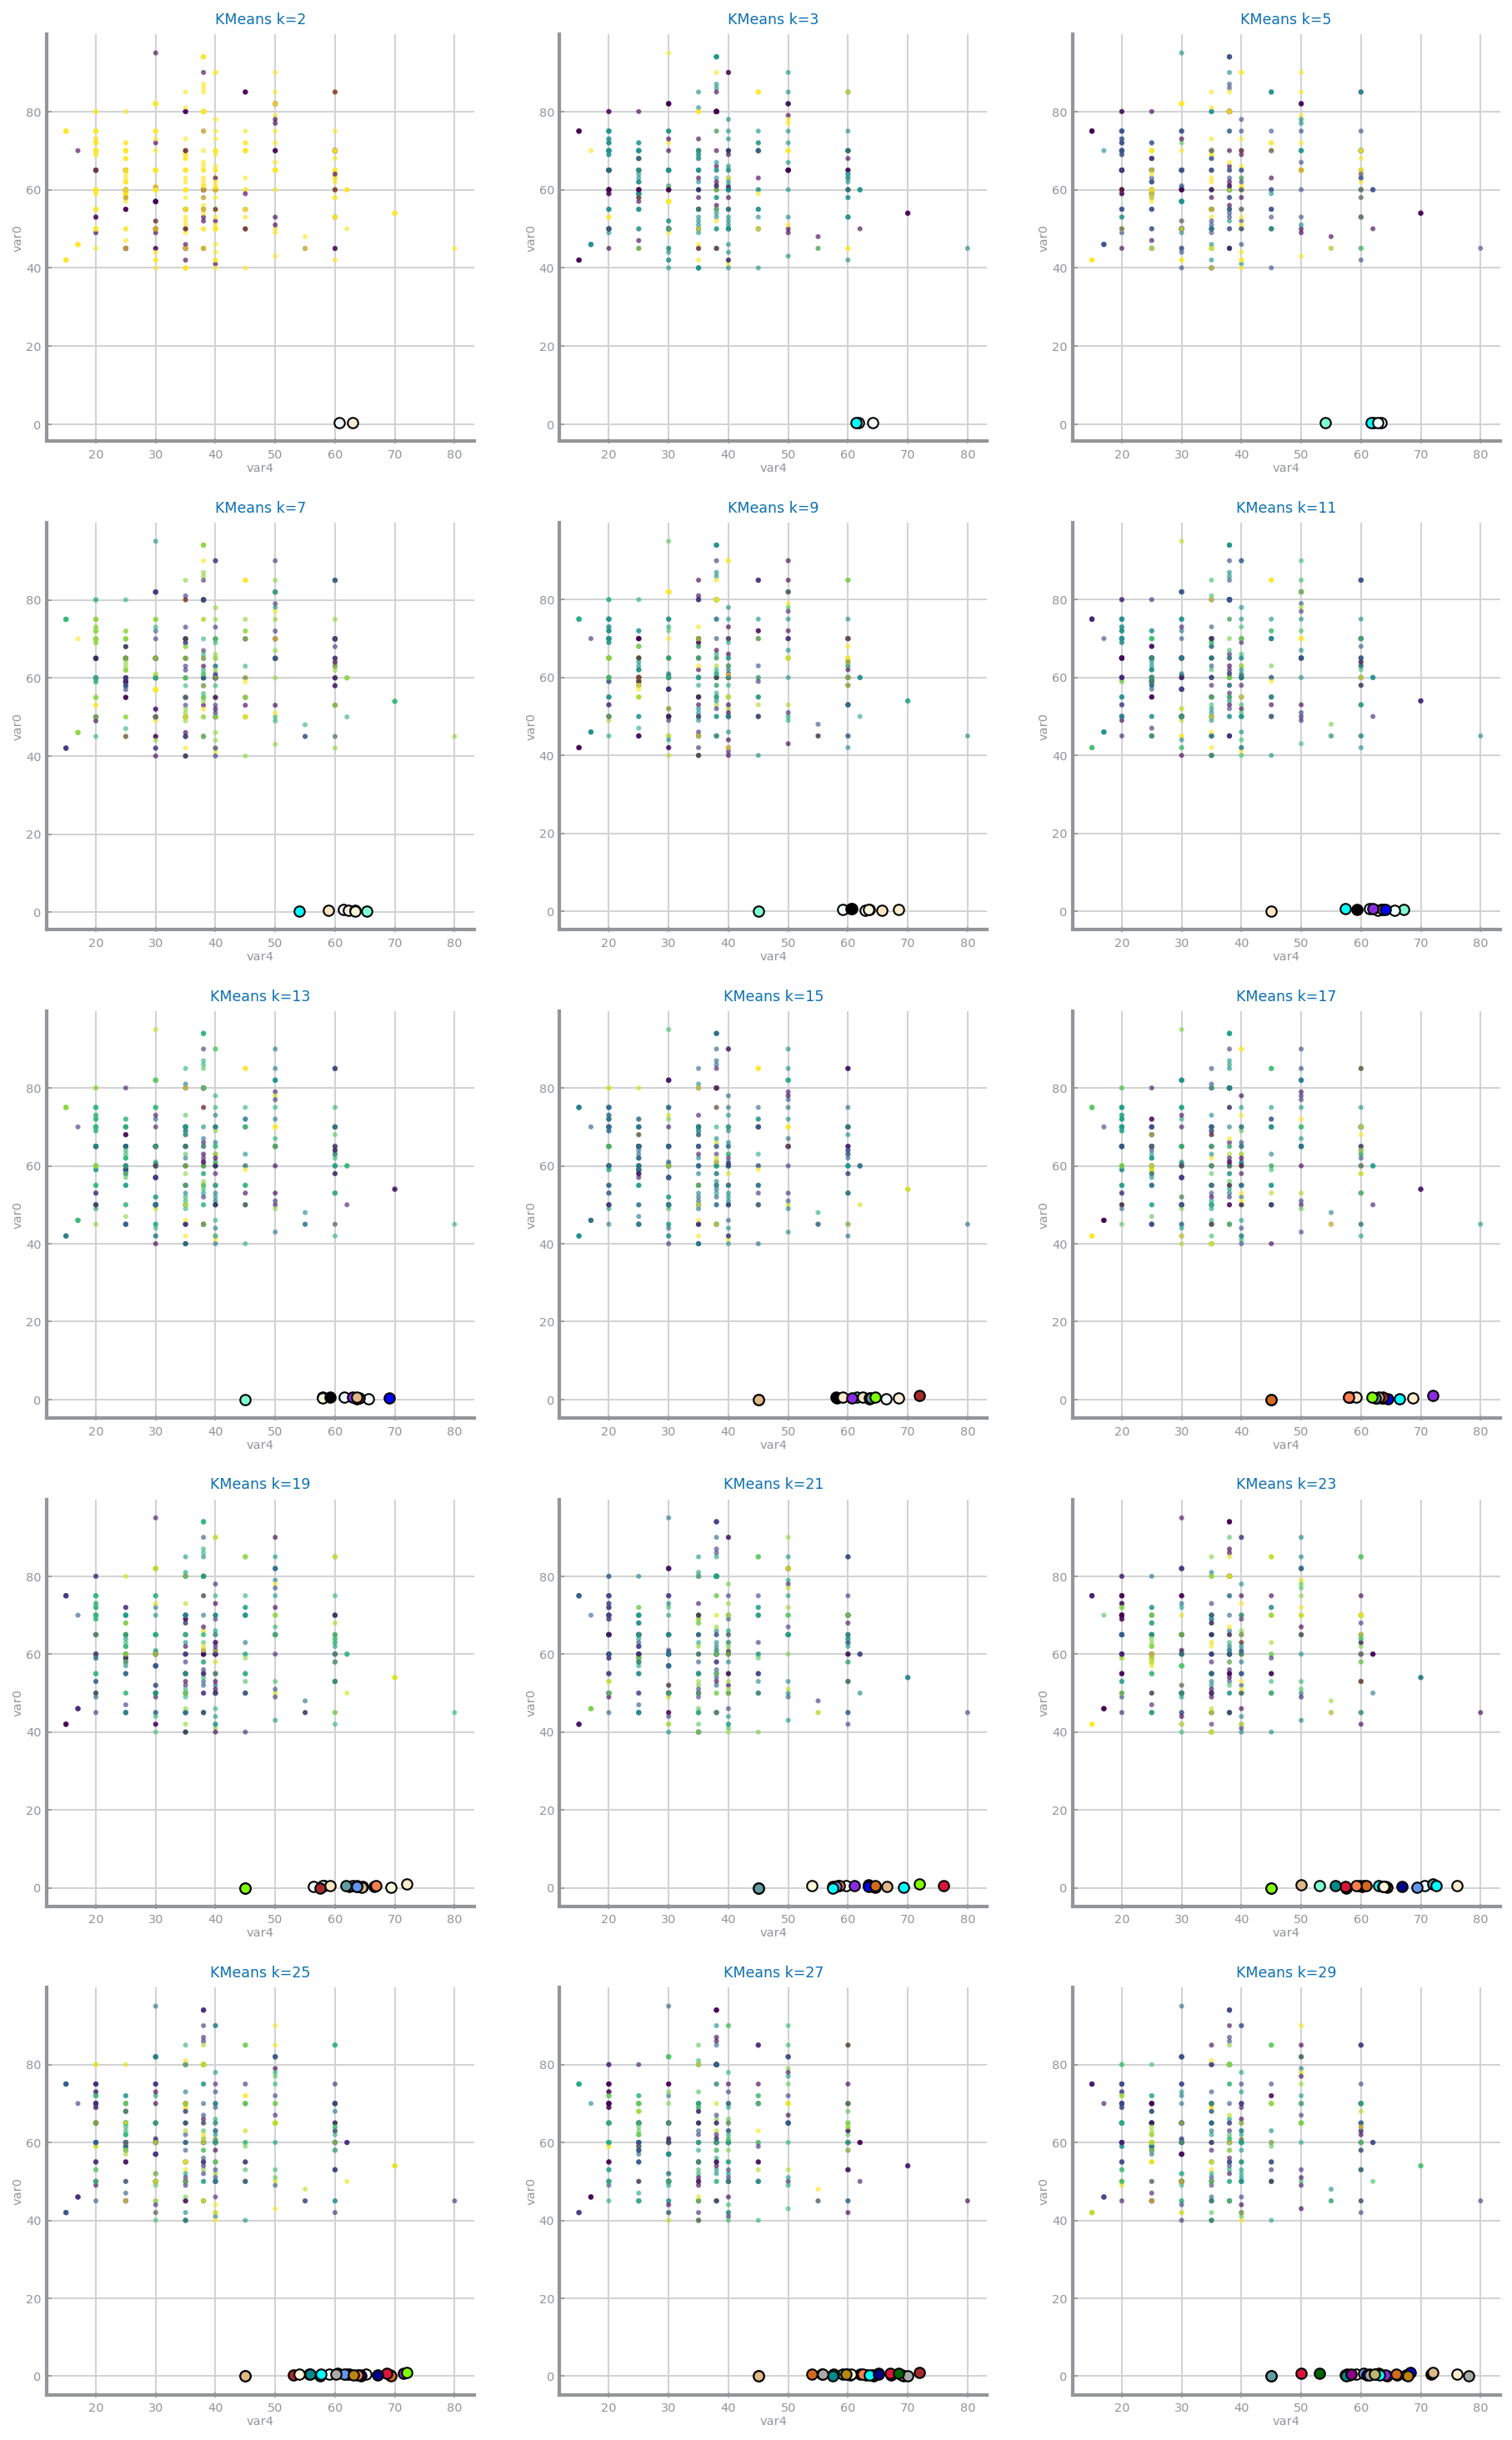

In [8]:
mse: list = []
sc: list = []
fig, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(N_CLUSTERS)):
    k = N_CLUSTERS[n]
#     estimator = KMeans(n_clusters=k,init = 'k-means++')
    estimator = KMeans(n_clusters=k)
    estimator.fit(over_sampled)
    mse.append(estimator.inertia_)
    sc.append(silhouette_score(over_sampled, estimator.labels_))
    ds.plot_clusters(over_sampled, v2, v1, estimator.labels_.astype(float), estimator.cluster_centers_, k,
                     f'KMeans k={k}', ax=axs[i,j])
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.show()

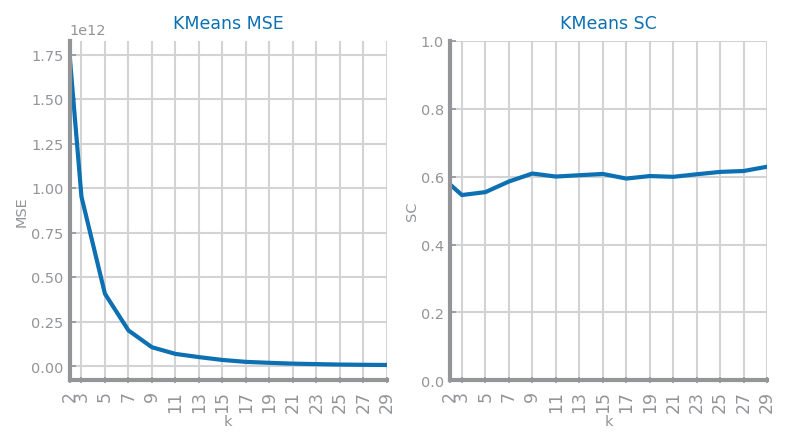

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
ds.plot_line(N_CLUSTERS, mse, title='KMeans MSE', xlabel='k', ylabel='MSE', ax=ax[0, 0])
ds.plot_line(N_CLUSTERS, sc, title='KMeans SC', xlabel='k', ylabel='SC', ax=ax[0, 1], percentage=True)
plt.show()

**K-Means Over sampled MINMAX**

In [ ]:
v1 = 0
v2 = 4

N_CLUSTERS = [2, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
rows, cols = ds.choose_grid(len(N_CLUSTERS))

over_sampled_minmax.pop(target)

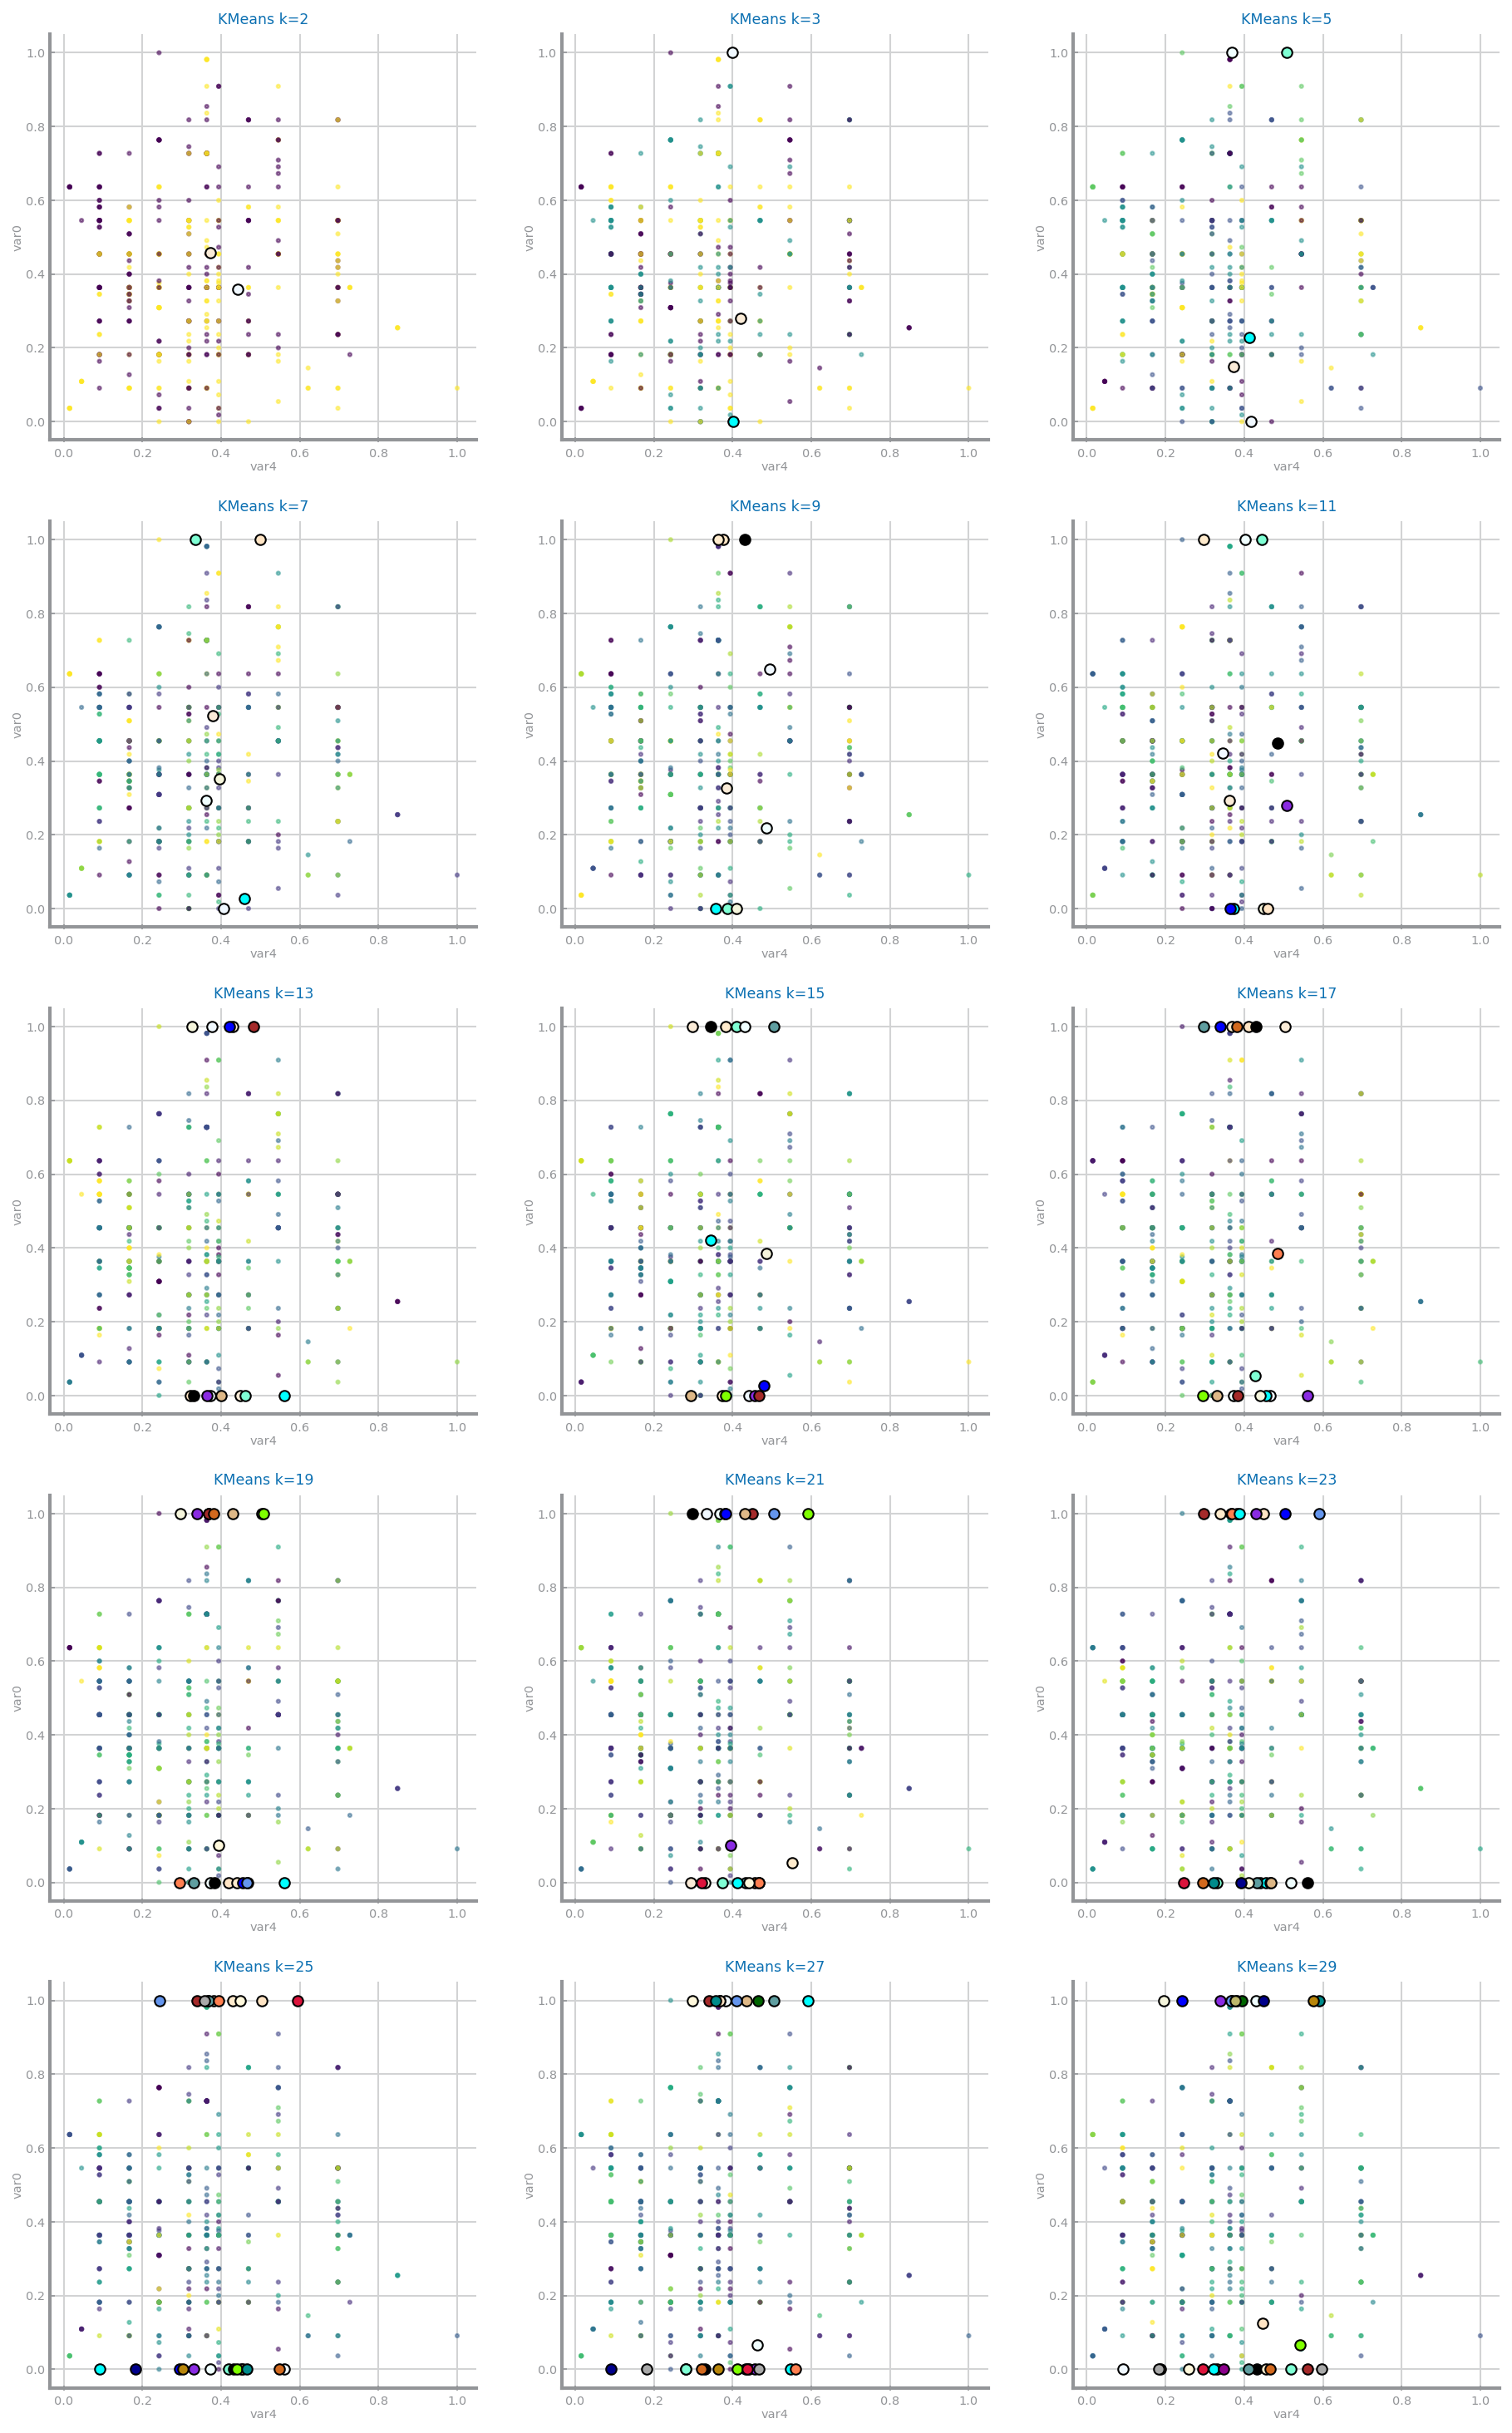

In [10]:
mse: list = []
sc: list = []
fig, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(N_CLUSTERS)):
    k = N_CLUSTERS[n]
#     estimator = KMeans(n_clusters=k,init = 'k-means++')
    estimator = KMeans(n_clusters=k)
    estimator.fit(over_sampled_minmax)
    mse.append(estimator.inertia_)
    sc.append(silhouette_score(over_sampled_minmax, estimator.labels_))
    ds.plot_clusters(over_sampled_minmax, v2, v1, estimator.labels_.astype(float), estimator.cluster_centers_, k,
                     f'KMeans k={k}', ax=axs[i,j])
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.show()

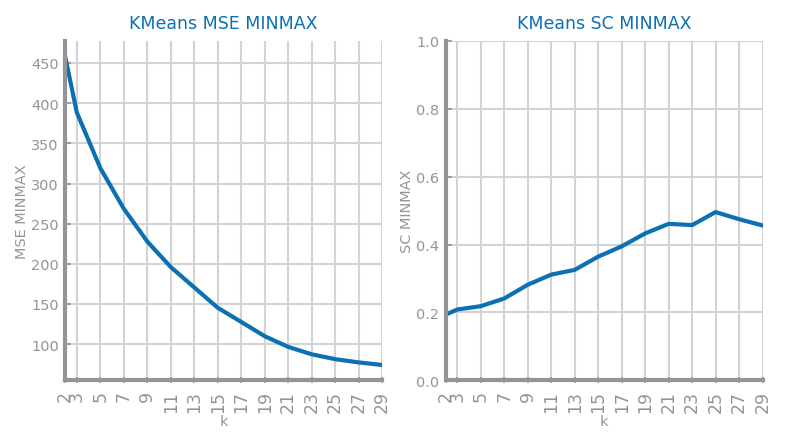

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
ds.plot_line(N_CLUSTERS, mse, title='KMeans MSE MINMAX', xlabel='k', ylabel='MSE MINMAX', ax=ax[0, 0])
ds.plot_line(N_CLUSTERS, sc, title='KMeans SC MINMAX', xlabel='k', ylabel='SC MINMAX', ax=ax[0, 1], percentage=True)
plt.show()

### Density-based without scaling

*EPS - Studying the Maximum Distance Impact*

In [25]:
def clustering_density_eps(data_sample, eixo_x, eixo_y):
    EPS = [2.5, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    mse: list = []
    sc: list = []
    rows, cols = ds.choose_grid(len(EPS))
    _, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
    i, j = 0, 0
    for n in range(len(EPS)):
        estimator = DBSCAN(eps=EPS[n], min_samples=2)
        estimator.fit(data_sample)
        labels = estimator.labels_
        k = len(set(labels)) - (1 if -1 in labels else 0)
        if k > 1:
            centers = ds.compute_centroids(data_sample, labels)
            mse.append(ds.compute_mse(data_sample.values, labels, centers))
            sc.append(silhouette_score(data_sample, labels))
            ds.plot_clusters(data_sample, eixo_x, eixo_y, labels.astype(float), estimator.components_, k,
                             f'DBSCAN eps={EPS[n]} k={k}', ax=axs[i,j])
            i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
        else:
            mse.append(0)
            sc.append(0)
    plt.show()
    
    print()
    
    fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
    ds.plot_line(EPS, mse, title='DBSCAN MSE', xlabel='eps', ylabel='MSE', ax=ax[0, 0])
    ds.plot_line(EPS, sc, title='DBSCAN SC', xlabel='eps', ylabel='SC', ax=ax[0, 1], percentage=True)
    plt.show()

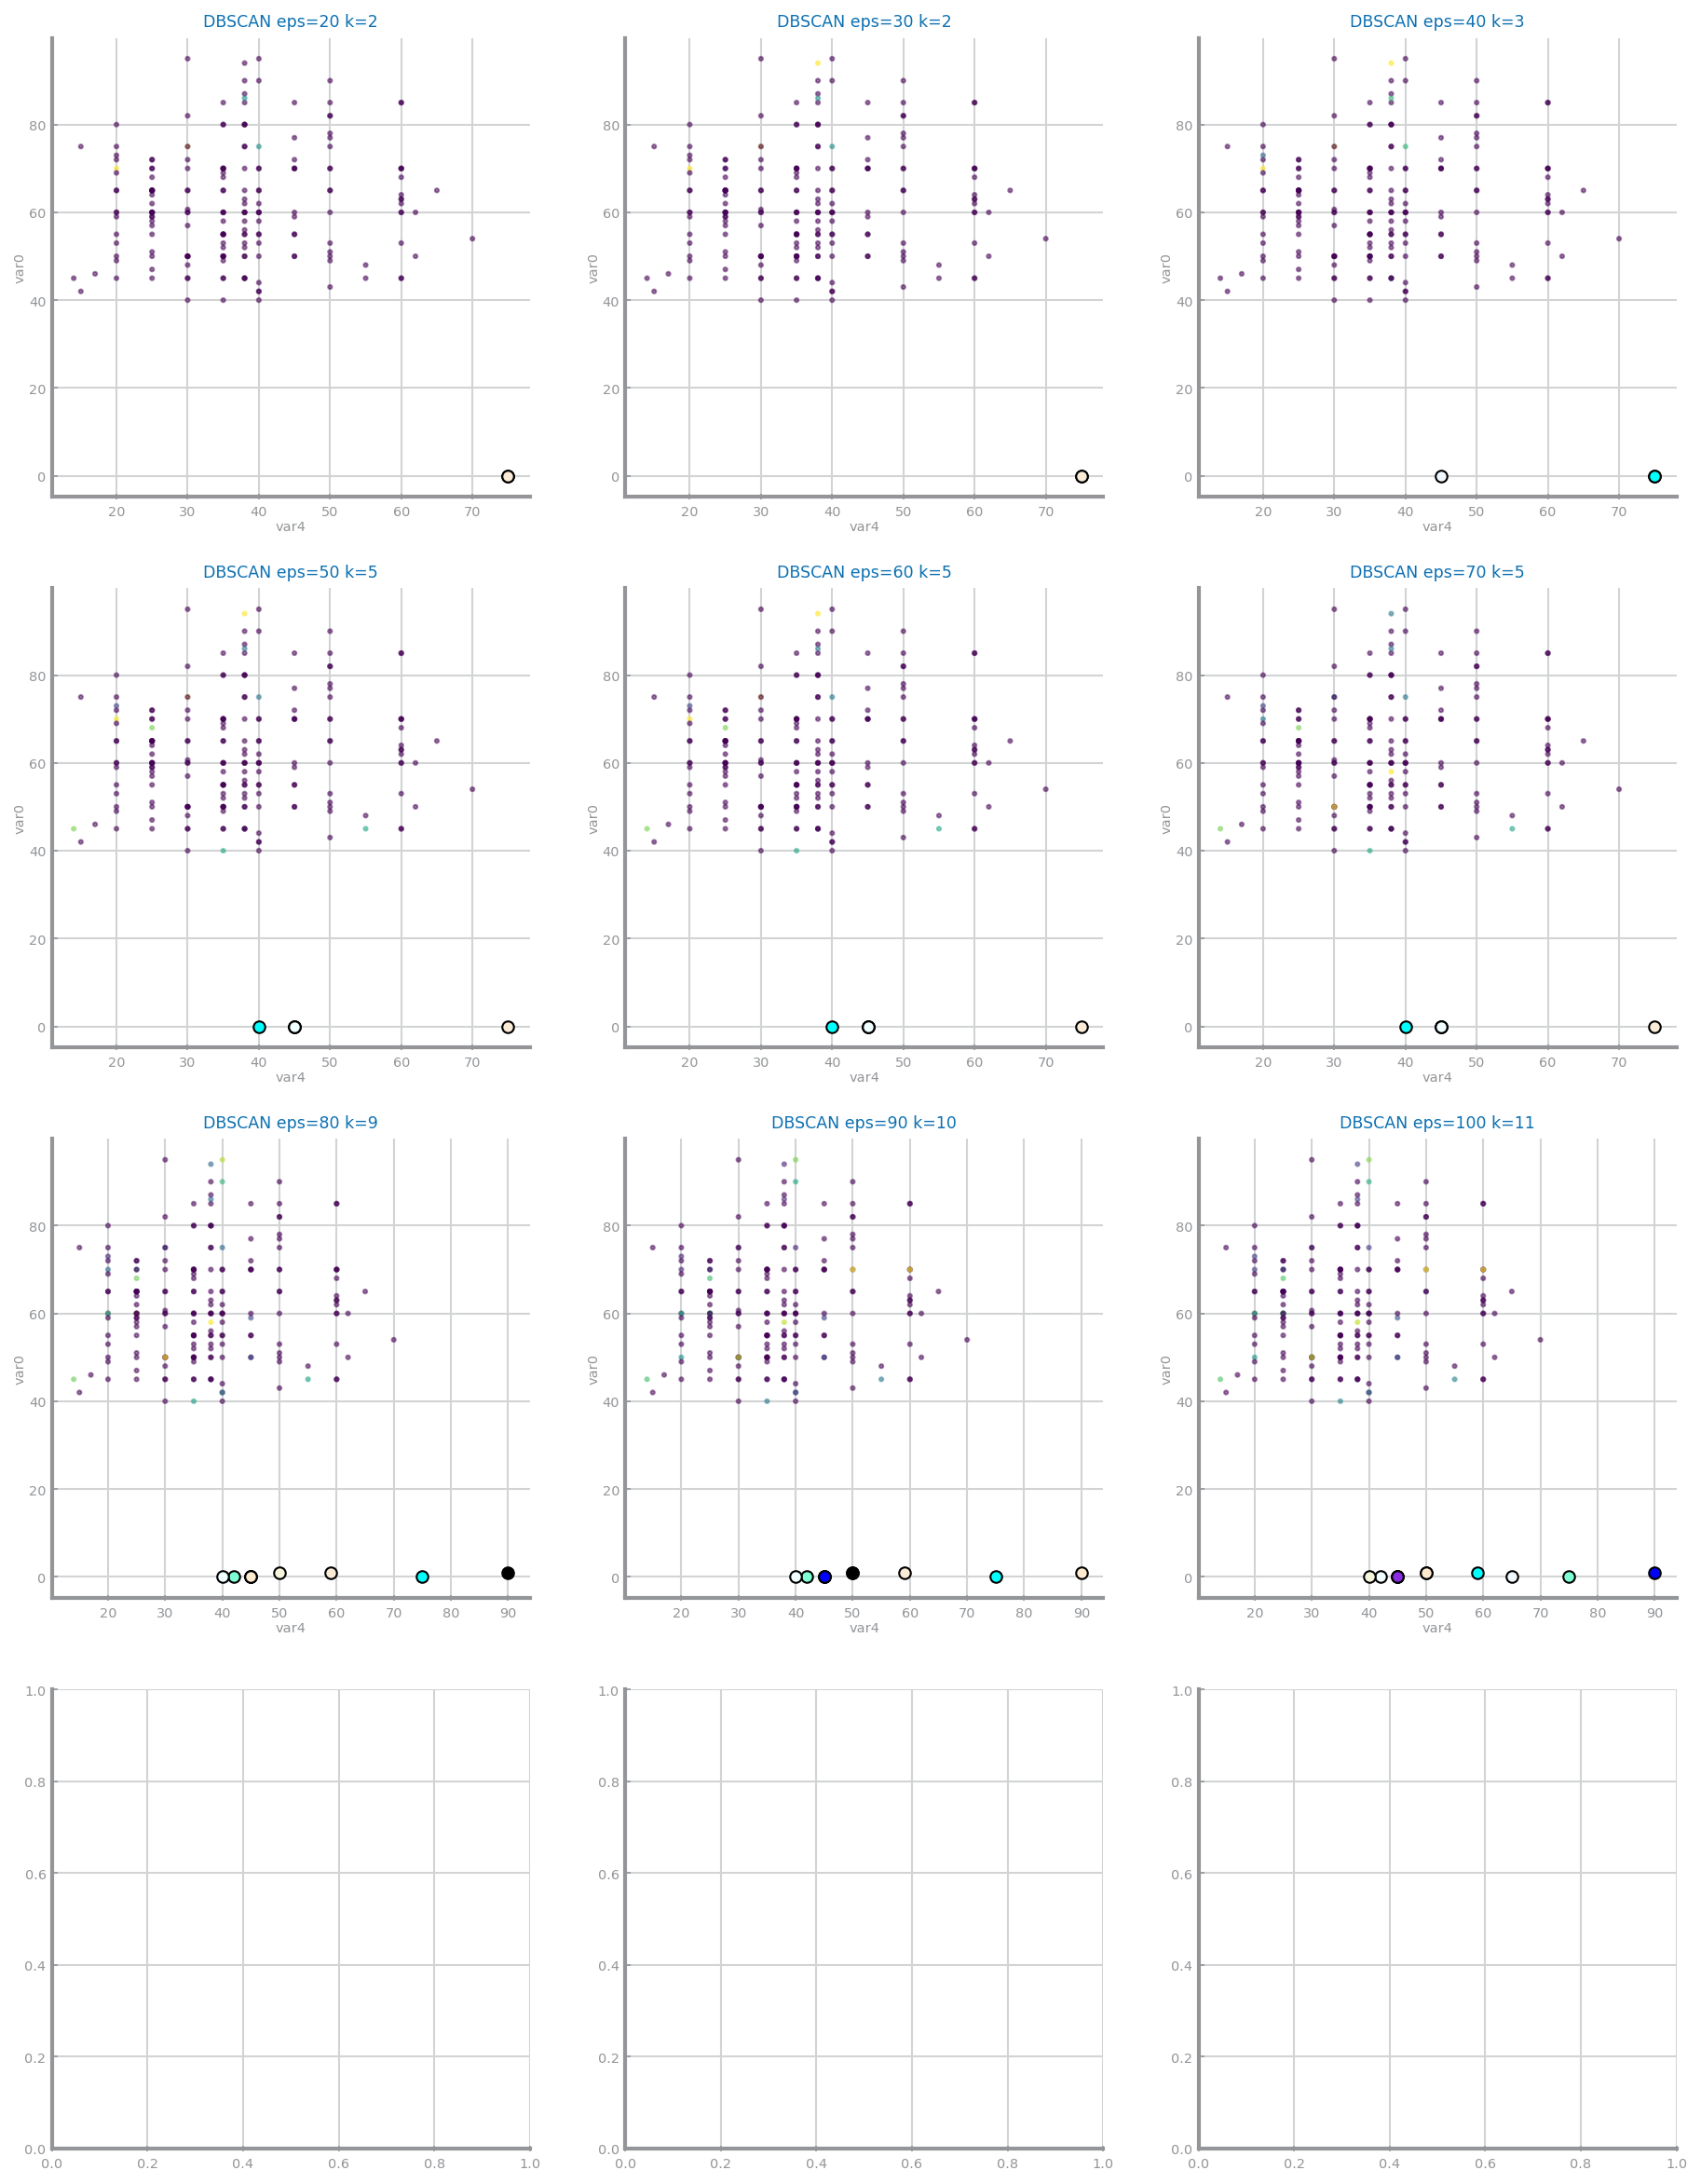

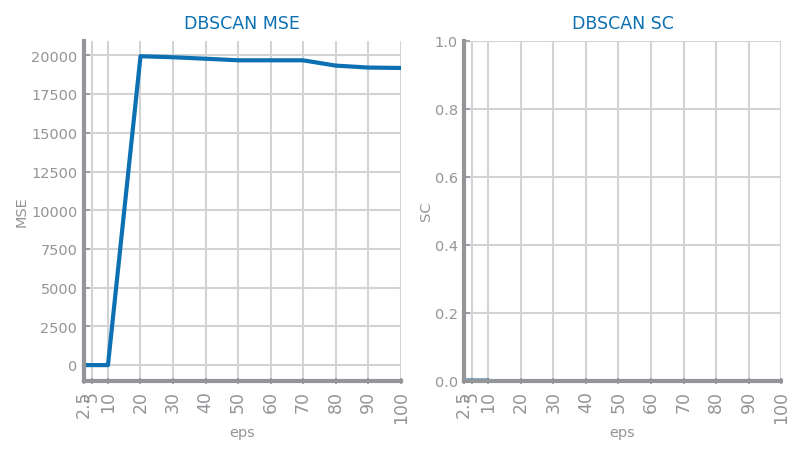

In [11]:
clustering_density_eps(data_unbalanced, v2, v1)

*Metric*

In [26]:
def clustering_density_metric(data_sample, eixo_x, eixo_y):
    METRICS = ['euclidean', 'cityblock', 'chebyshev', 'cosine', 'jaccard']
    distances = []
    for m in METRICS:
        dist = np.mean(np.mean(squareform(pdist(data_sample.values, metric=m))))
        distances.append(dist)

    print('AVG distances among records', distances)
    distances[0] = 80
    distances[1] = 50
    distances[2] = 80
    distances[3] = 0.0005
    distances[4] = 0.0009
    print('CHOSEN EPS', distances)
    
    print('\n')
    
    mse: list = []
    sc: list = []
    rows, cols = ds.choose_grid(len(METRICS))
    _, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
    i, j = 0, 0
    for n in range(len(METRICS)):
        estimator = DBSCAN(eps=distances[n], min_samples=2, metric=METRICS[n])
        estimator.fit(data_sample)
        labels = estimator.labels_
        k = len(set(labels)) - (1 if -1 in labels else 0)
        if k > 1:
            centers = ds.compute_centroids(data_sample, labels)
            mse.append(ds.compute_mse(data_sample.values, labels, centers))
            sc.append(silhouette_score(data_sample, labels))
            ds.plot_clusters(data_sample, eixo_x, eixo_y, labels.astype(float), estimator.components_, k,
                             f'DBSCAN metric={METRICS[n]} eps={distances[n]:.2f} k={k}', ax=axs[i,j])
        else:
            mse.append(0)
            sc.append(0)
        i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
    plt.show()
    
    print()
    
    fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
    ds.bar_chart(METRICS, mse, title='DBSCAN MSE', xlabel='metric', ylabel='MSE', ax=ax[0, 0])
    ds.bar_chart(METRICS, sc, title='DBSCAN SC', xlabel='metric', ylabel='SC', ax=ax[0, 1], percentage=True)
    plt.show()

AVG distances among records [103649.30823152265, 104469.37927121311, 103624.63039225261, 2.2533089238759905e-05, 0.8589000462006647]
CHOSEN EPS [80, 50, 80, 0.0005, 0.0009]




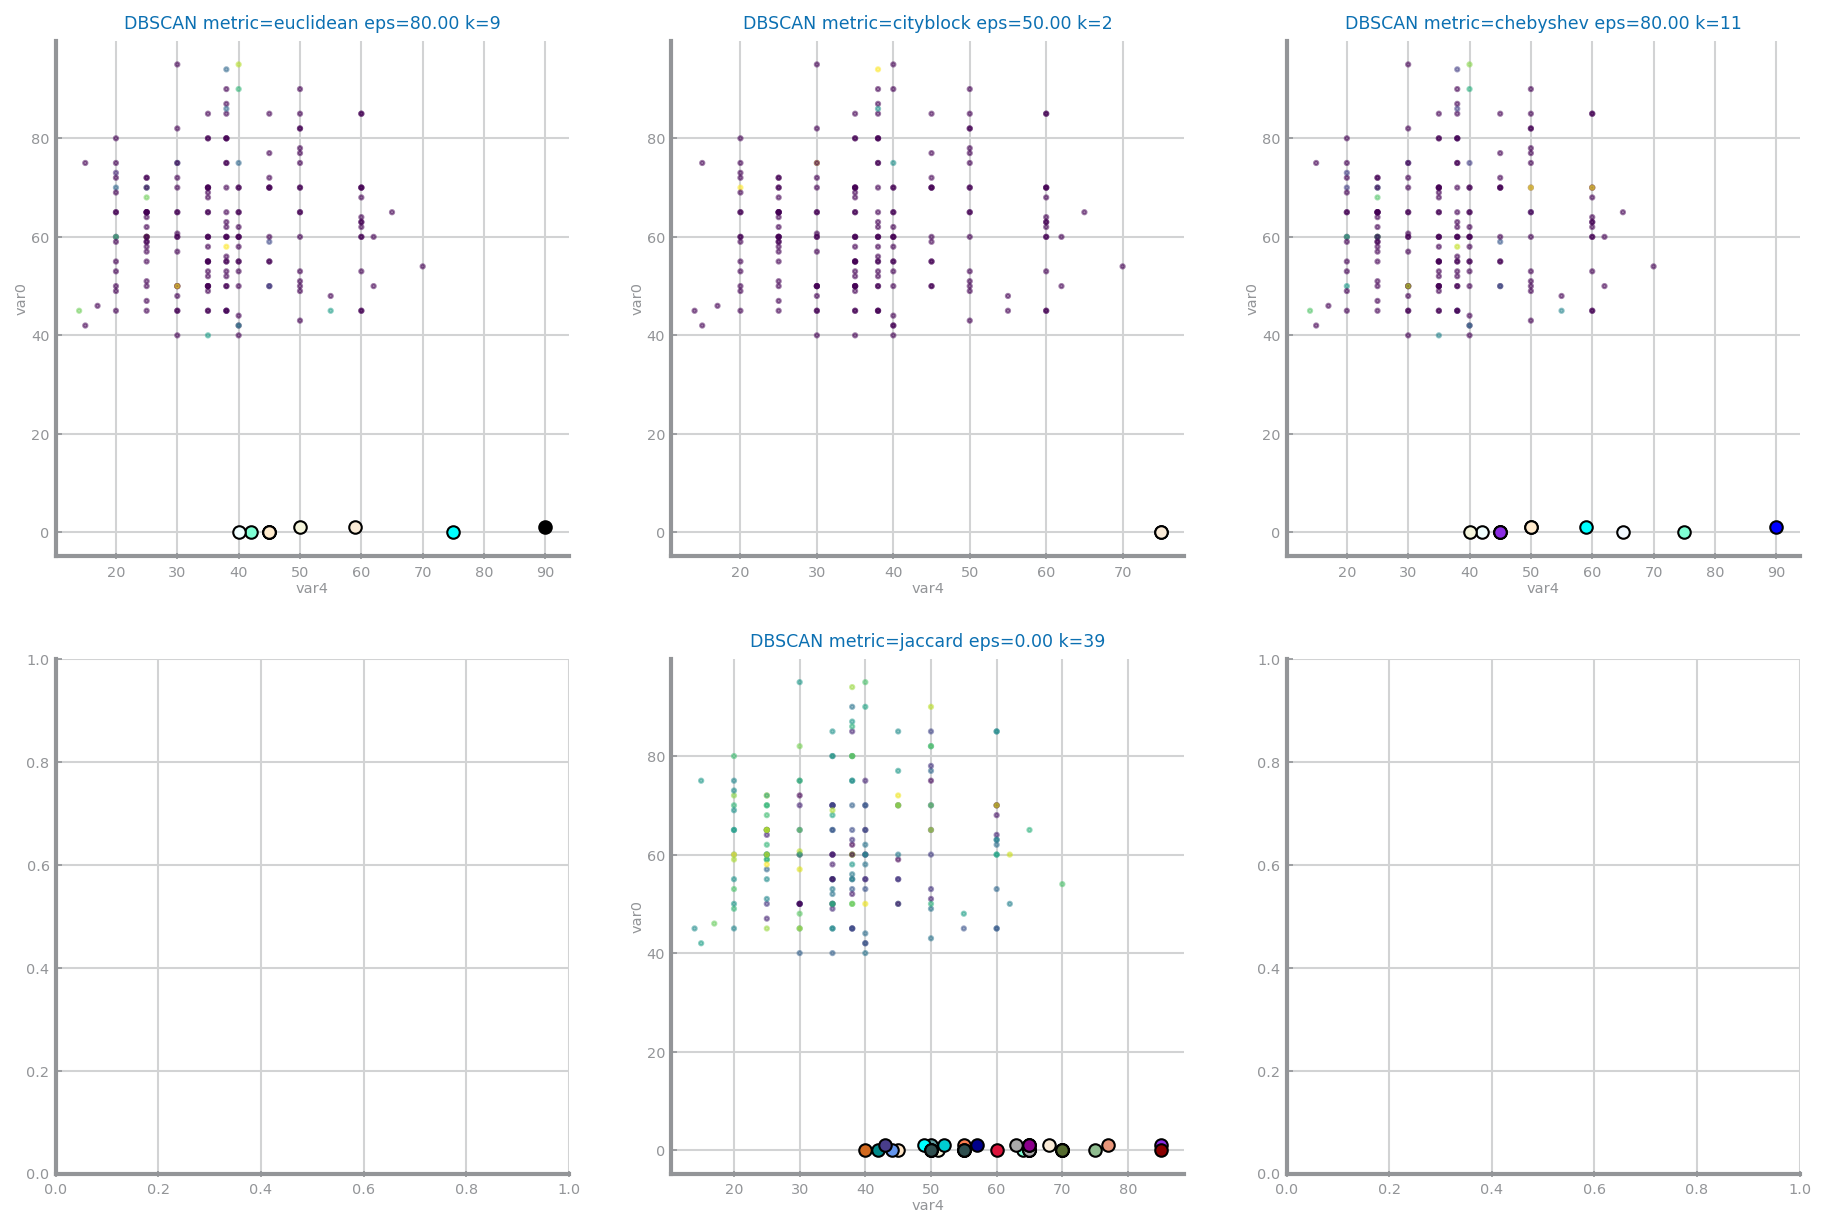

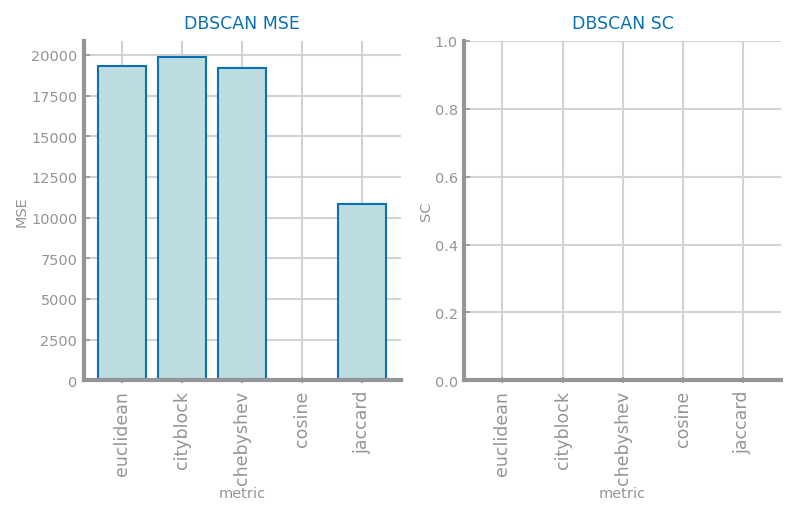

In [13]:
clustering_density_metric(data_unbalanced, v2, v1)

### Hierarchical

In [28]:
def clustering_hierarchical(data_sample, eixo_x, eixo_y):
    mse: list = []
    sc: list = []
    rows, cols = ds.choose_grid(len(N_CLUSTERS))
    _, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
    i, j = 0, 0
    for n in range(len(N_CLUSTERS)):
        k = N_CLUSTERS[n]
        estimator = AgglomerativeClustering(n_clusters=k)
        estimator.fit(data_sample)
        labels = estimator.labels_
        centers = ds.compute_centroids(data_sample, labels)
        mse.append(ds.compute_mse(data_sample.values, labels, centers))
        sc.append(silhouette_score(data_sample, labels))
        ds.plot_clusters(data_sample, eixo_x, eixo_y, labels, centers, k,
                         f'Hierarchical k={k}', ax=axs[i,j])
        i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
    plt.show()
    
    print()
    
    fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
    ds.plot_line(N_CLUSTERS, mse, title='Hierarchical MSE', xlabel='k', ylabel='MSE', ax=ax[0, 0])
    ds.plot_line(N_CLUSTERS, sc, title='Hierarchical SC', xlabel='k', ylabel='SC', ax=ax[0, 1], percentage=True)
    plt.show()
    
    print('\n')
    
    METRICS = ['euclidean', 'cityblock', 'chebyshev', 'cosine', 'jaccard']
    LINKS = ['complete', 'average']
    k = 3
    values_mse = {}
    values_sc = {}
    rows = len(METRICS)
    cols = len(LINKS)
    _, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
    for i in range(len(METRICS)):
        mse: list = []
        sc: list = []
        m = METRICS[i]
        for j in range(len(LINKS)):
            link = LINKS[j]
            estimator = AgglomerativeClustering(n_clusters=k, linkage=link, affinity=m )
            estimator.fit(data_sample)
            labels = estimator.labels_
            centers = ds.compute_centroids(data_sample, labels)
            mse.append(ds.compute_mse(data_sample.values, labels, centers))
            sc.append(silhouette_score(data_sample, labels))
            ds.plot_clusters(data_sample, eixo_x, eixo_y, labels, centers, k,
                             f'Hierarchical k={k} metric={m} link={link}', ax=axs[i,j])
        values_mse[m] = mse
        values_sc[m] = sc
    plt.show()
    
    print()
    
    _, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
    ds.multiple_bar_chart(LINKS, values_mse, title=f'Hierarchical MSE', xlabel='metric', ylabel='MSE', ax=ax[0, 0])
    ds.multiple_bar_chart(LINKS, values_sc, title=f'Hierarchical SC', xlabel='metric', ylabel='SC', ax=ax[0, 1], percentage=True)
    plt.show()

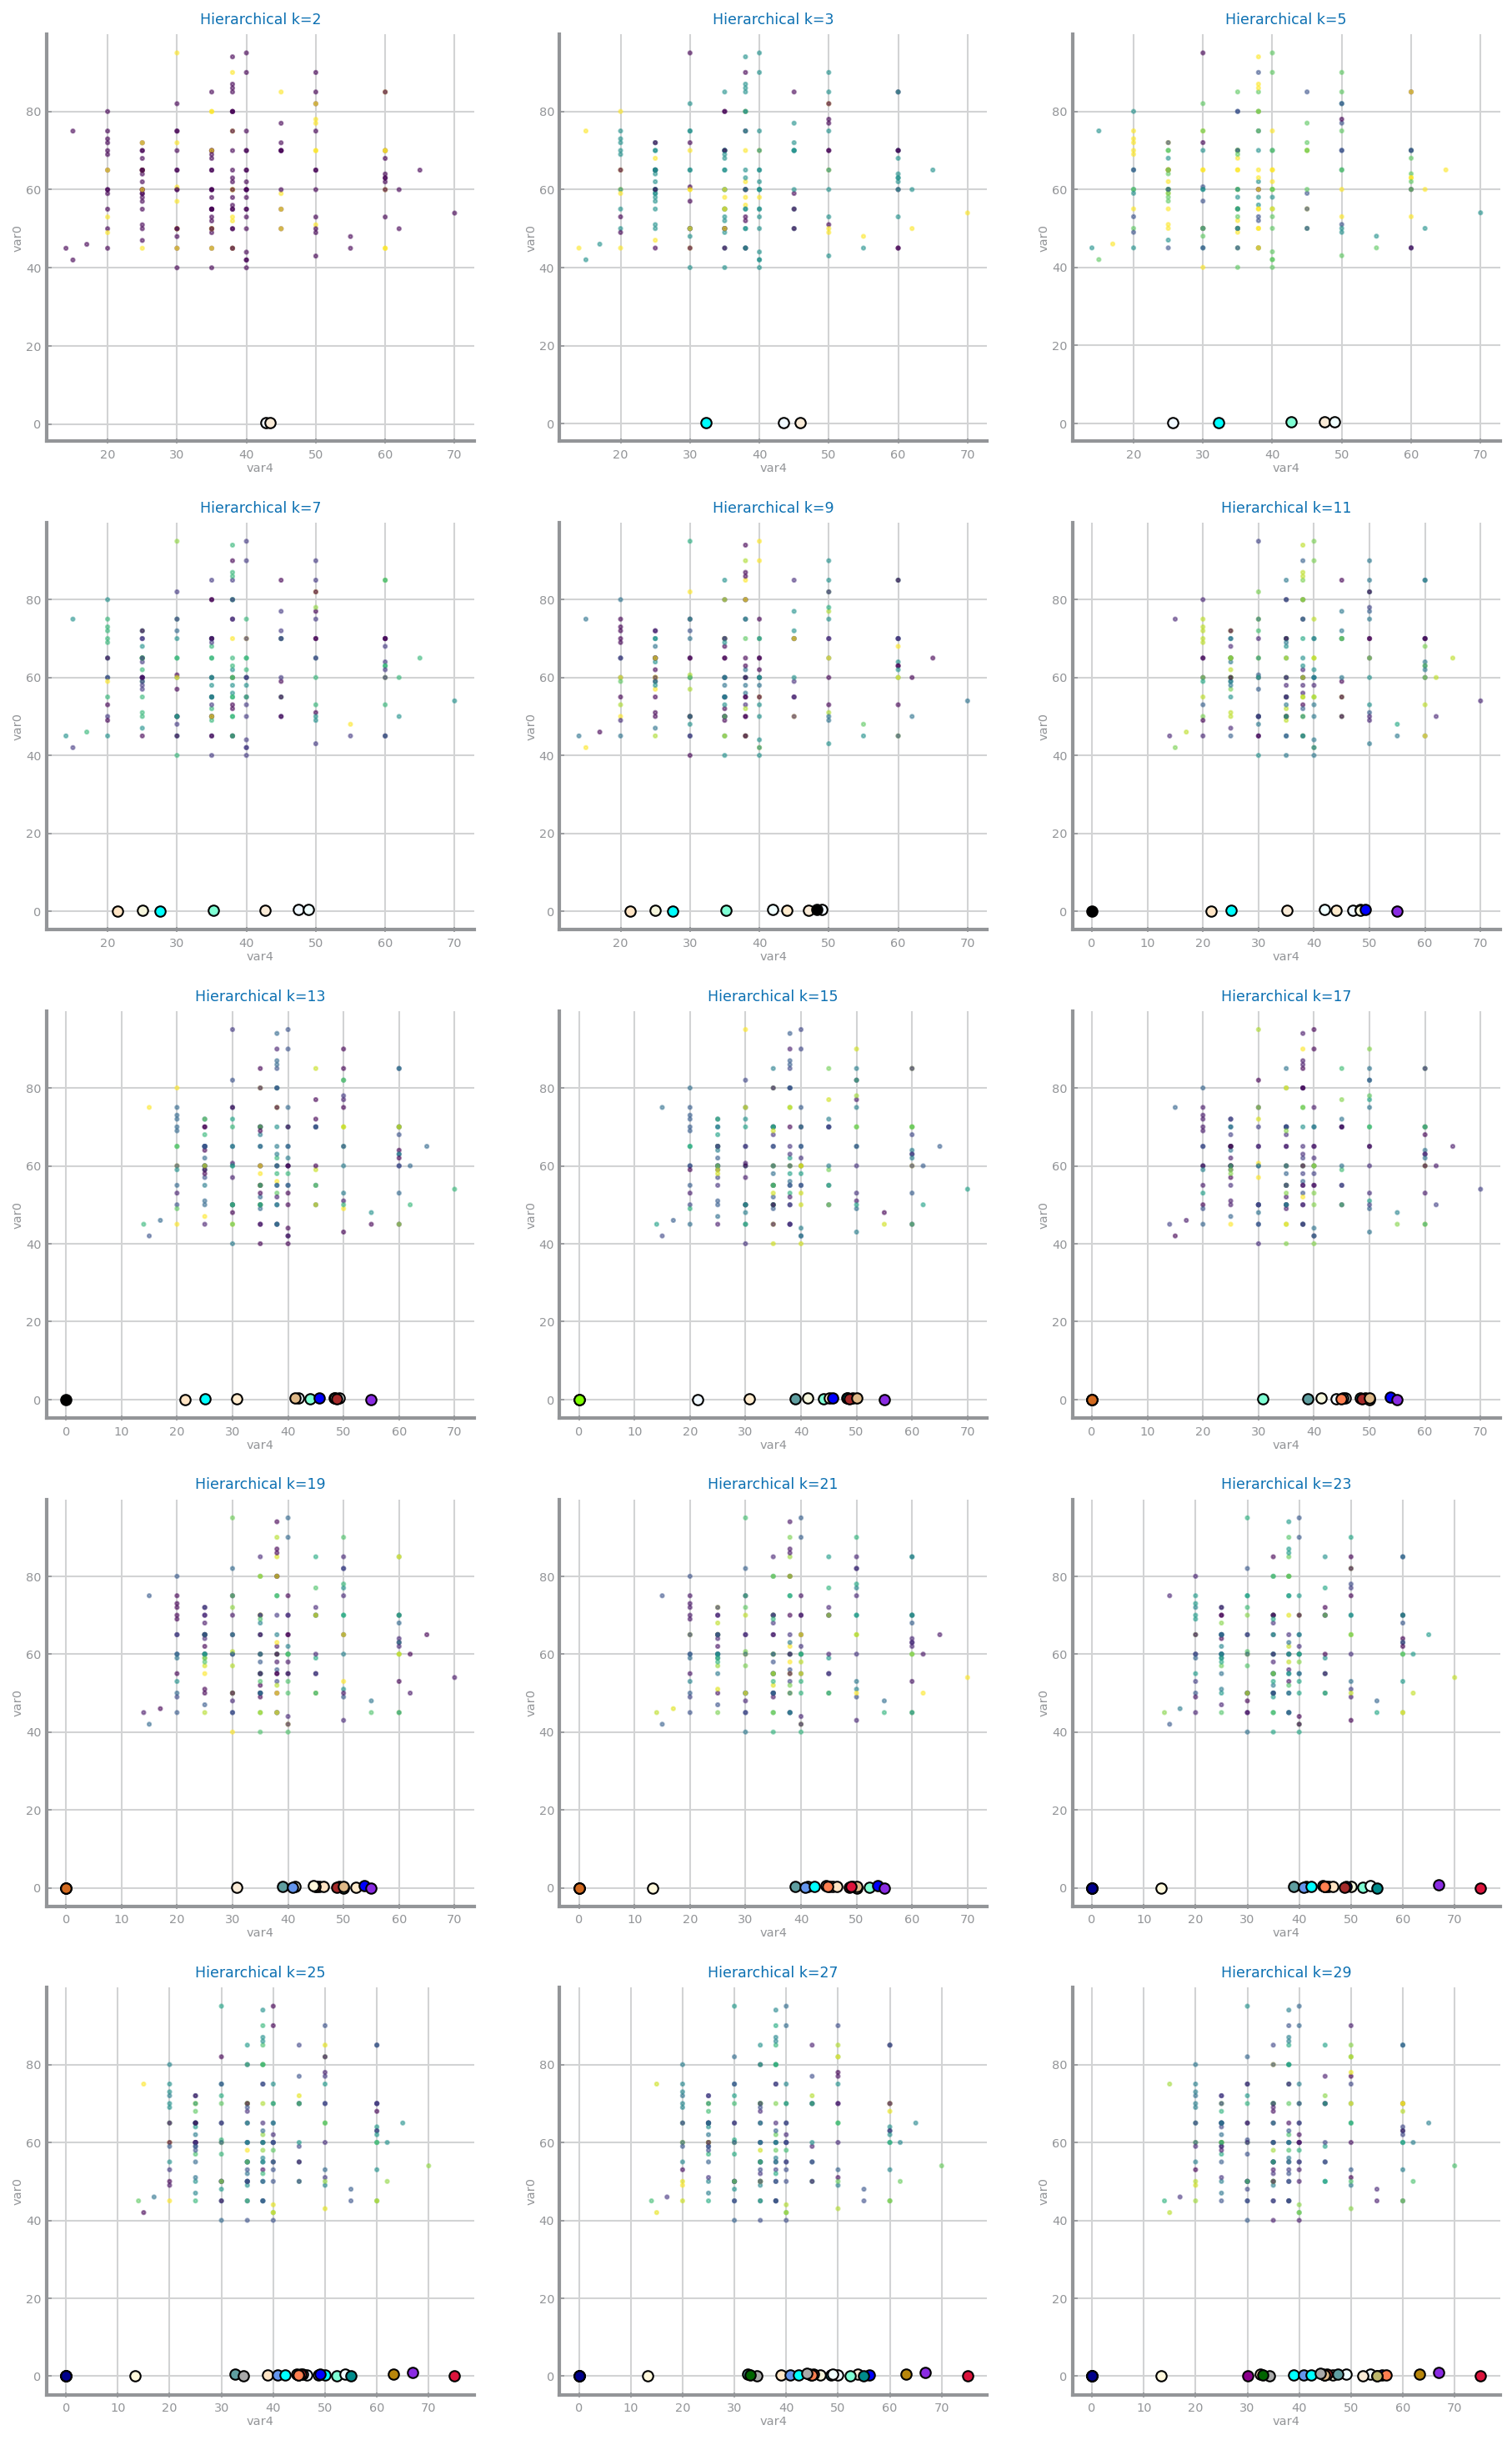

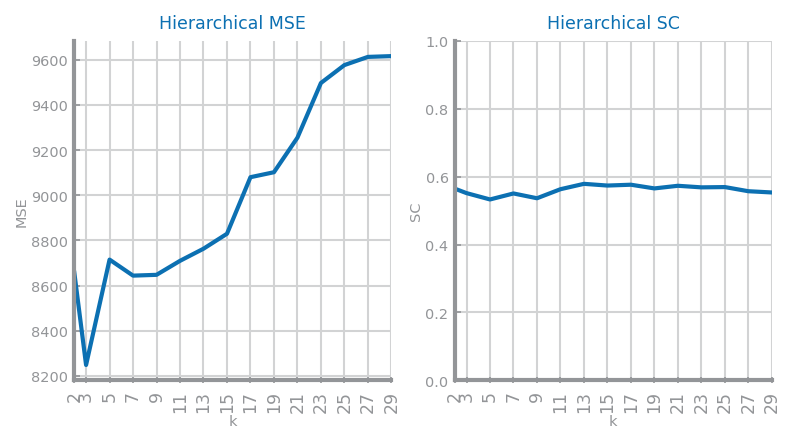

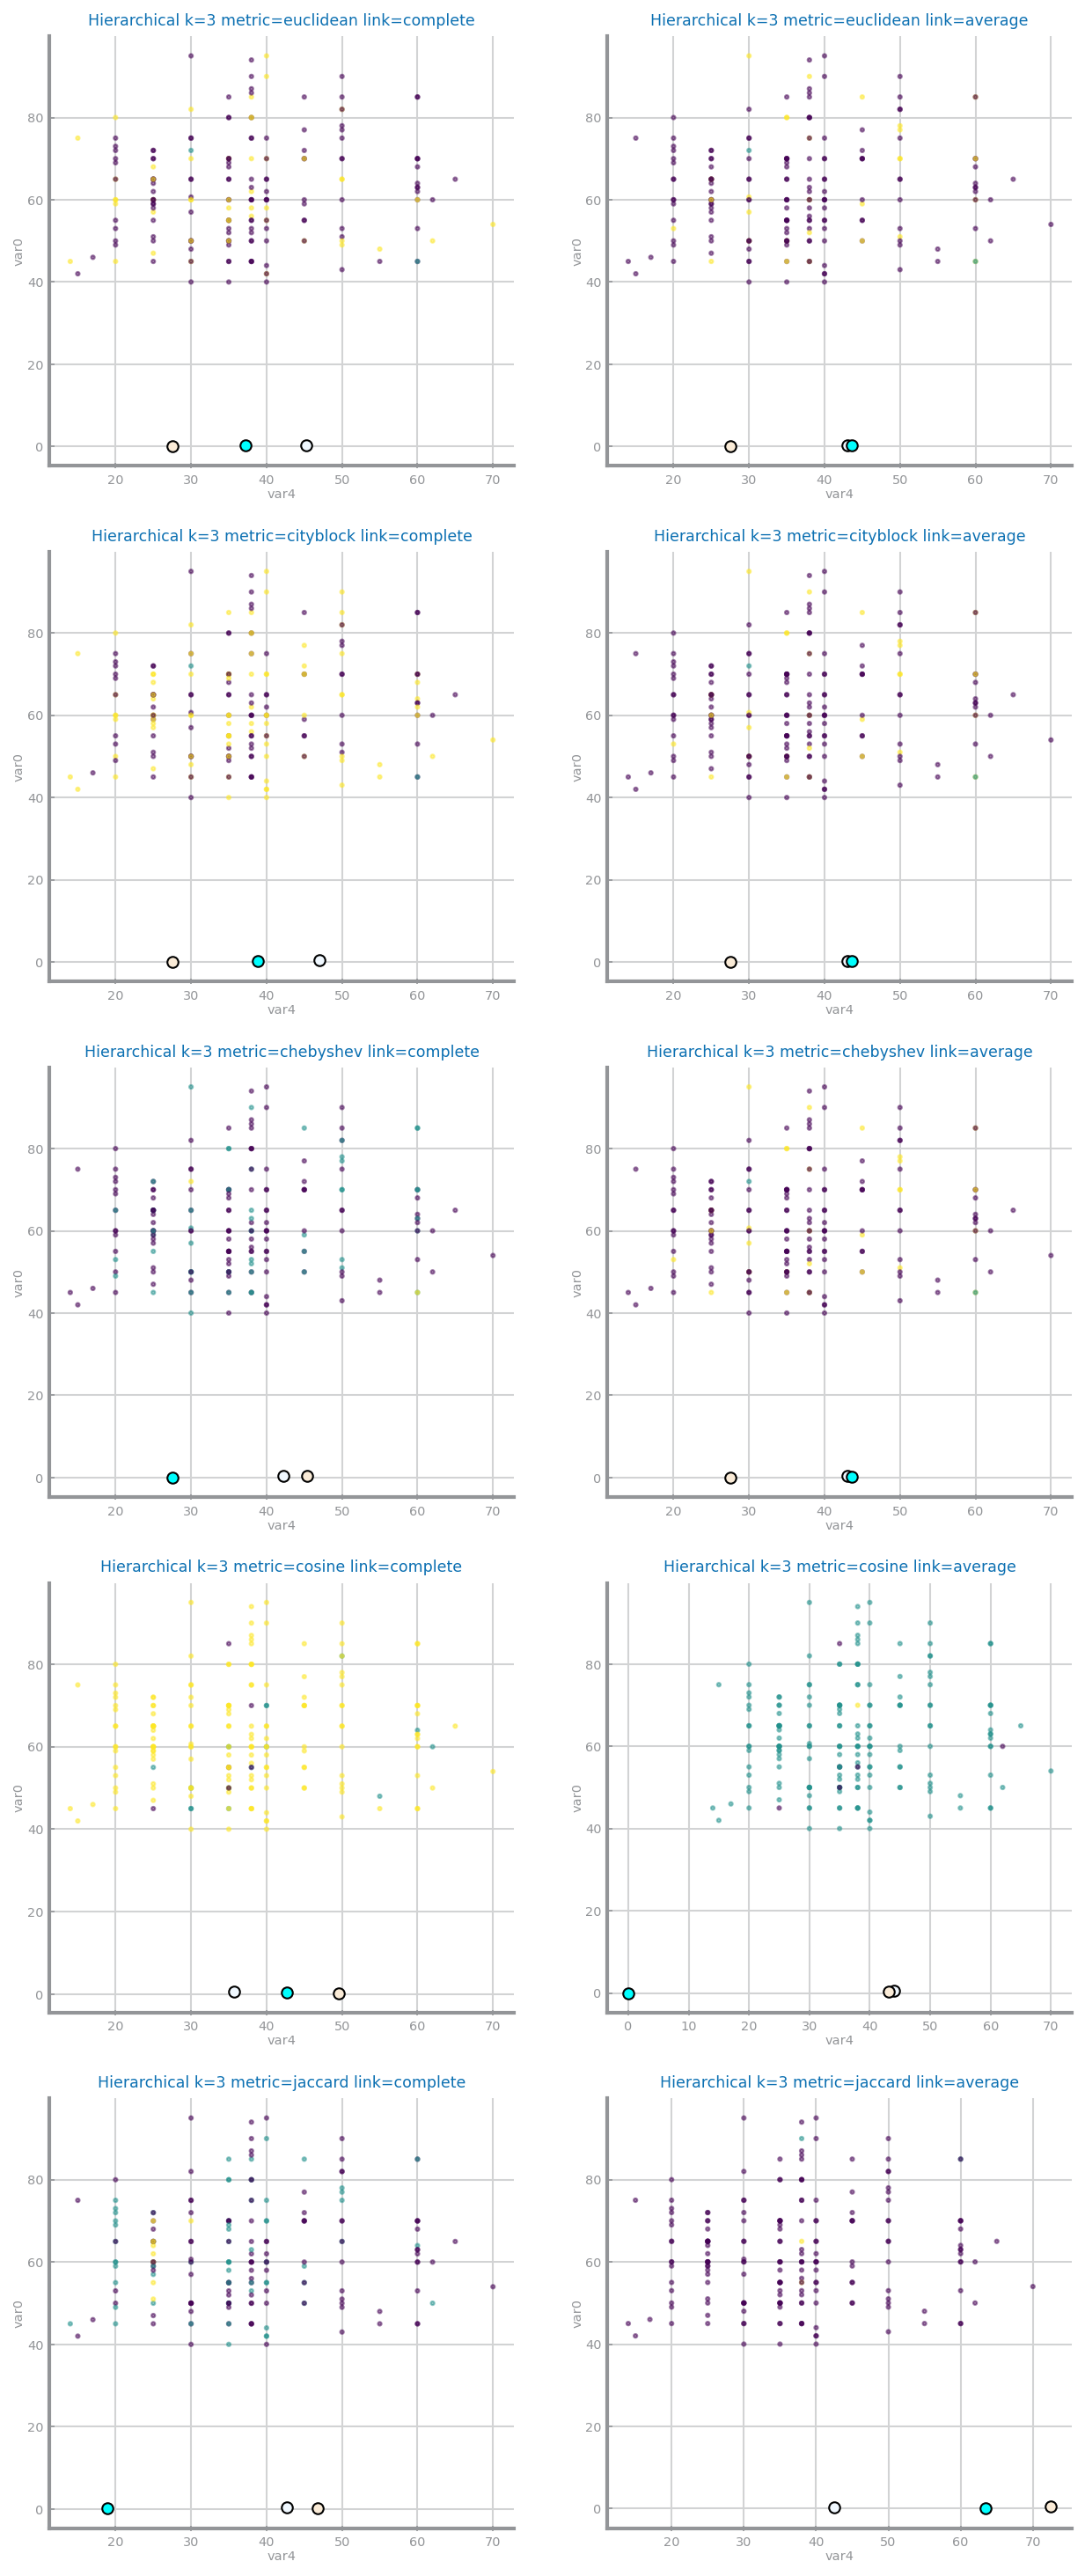

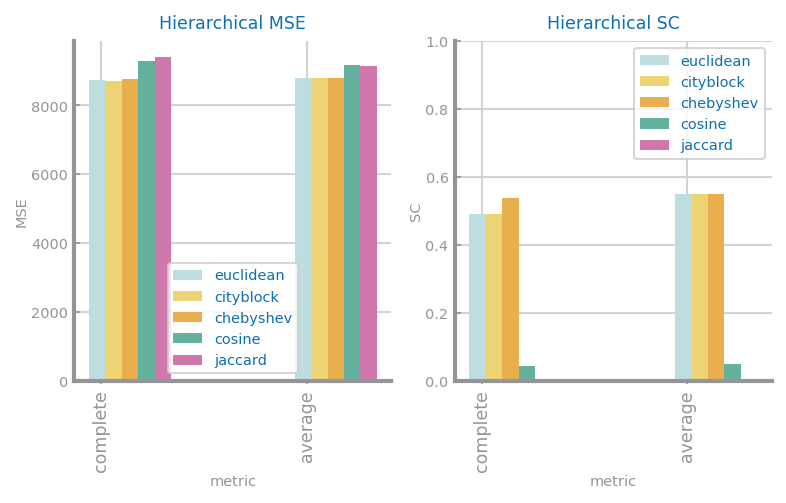

In [15]:
clustering_hierarchical(data_unbalanced, v2, v1)

### Density-based scalled sample MINMAX

*EPS - Studying the Maximum Distance Impact*

In [ ]:
clustering_density_eps(norm_data_minmax, v2, v1)

*Metric*

In [ ]:
clustering_density_metric(norm_data_minmax, v2, v1)

### Hierarchical

In [ ]:
clustering_hierarchical(norm_data_minmax, v2, v1)

## PCA

**PCA without scaling**

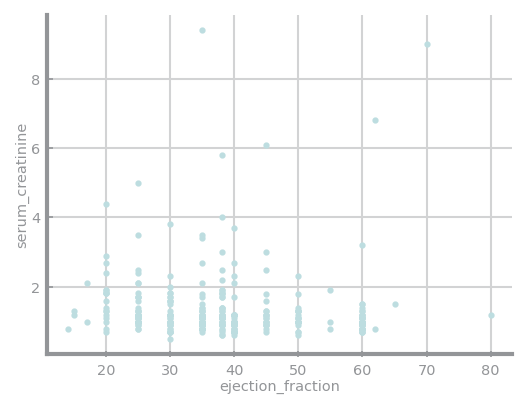

In [19]:
variables = data_unbalanced.columns.values
eixo_x = 0
eixo_y = 4
eixo_z = 7

plt.figure()
plt.xlabel(variables[eixo_y])
plt.ylabel(variables[eixo_z])
plt.scatter(data.iloc[:, eixo_y], data.iloc[:, eixo_z])
plt.show()

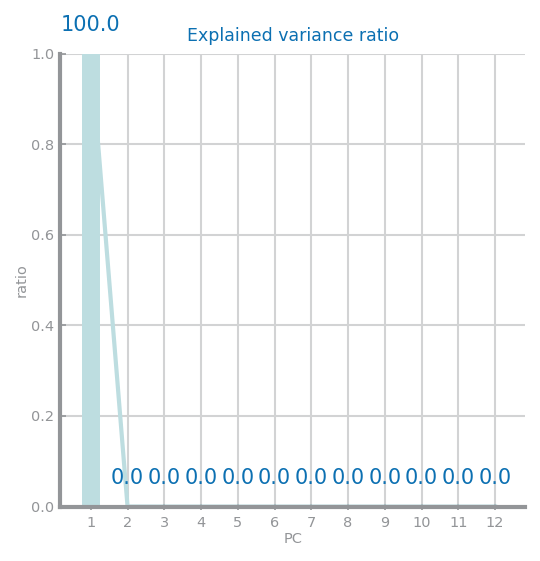

In [20]:
mean = (data_unbalanced.mean(axis=0)).tolist()
centered_data = data_unbalanced - mean
cov_mtx = centered_data.cov()
eigvals, eigvecs = np.linalg.eig(cov_mtx)

pca = PCA()
pca.fit(centered_data)
PC = pca.components_
var = pca.explained_variance_

# PLOT EXPLAINED VARIANCE RATIO
fig = plt.figure(figsize=(4, 4))
plt.title('Explained variance ratio')
plt.xlabel('PC')
plt.ylabel('ratio')
x_values = [str(i) for i in range(1, len(pca.components_) + 1)]
bwidth = 0.5
ax = plt.gca()
ax.set_xticklabels(x_values)
ax.set_ylim(0.0, 1.0)
ax.bar(x_values, pca.explained_variance_ratio_, width=bwidth)
ax.plot(pca.explained_variance_ratio_)
for i, v in enumerate(pca.explained_variance_ratio_):
    ax.text(i, v+0.05, f'{v*100:.1f}', ha='center')
plt.show()

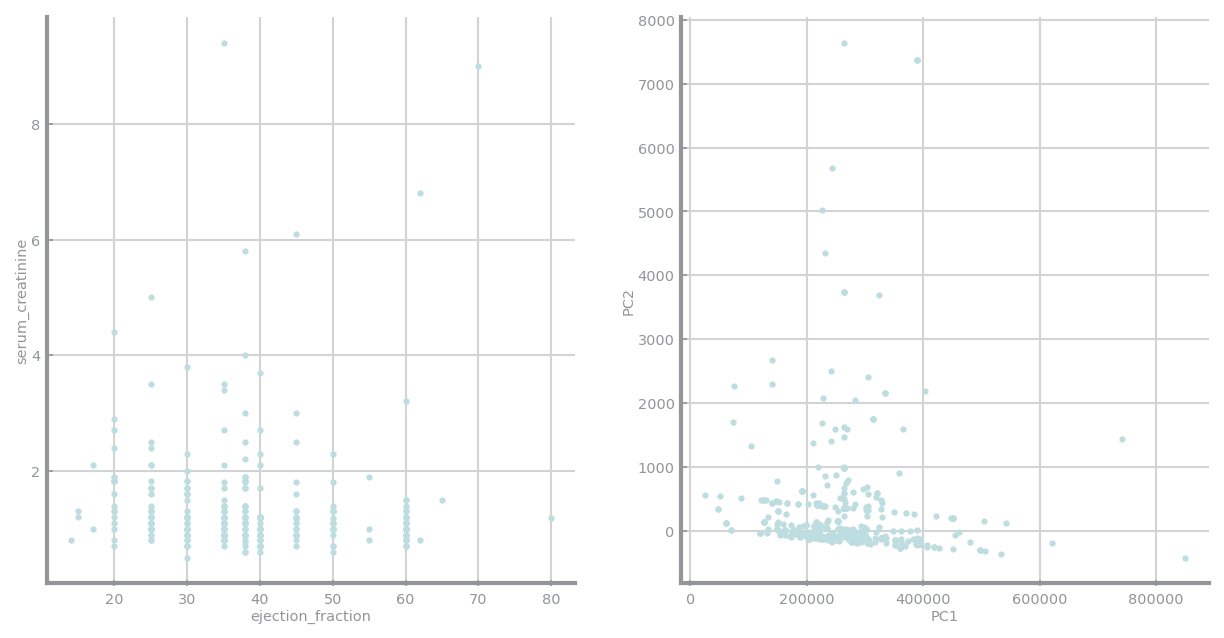

In [21]:
transf = pca.transform(data_unbalanced)

_, axs = plt.subplots(1, 2, figsize=(2*5, 1*5), squeeze=False)
axs[0,0].set_xlabel(variables[eixo_y])
axs[0,0].set_ylabel(variables[eixo_z])
axs[0,0].scatter(data.iloc[:, eixo_y], data.iloc[:, eixo_z])

axs[0,1].set_xlabel('PC1')
axs[0,1].set_ylabel('PC2')
axs[0,1].scatter(transf[:, 0], transf[:, 1])
plt.show()

**Clustering** comparison after PCA

In [23]:
data = pd.DataFrame(transf[:,:2], columns=['PC1', 'PC2'])
eixo_x = 0
eixo_y = 1

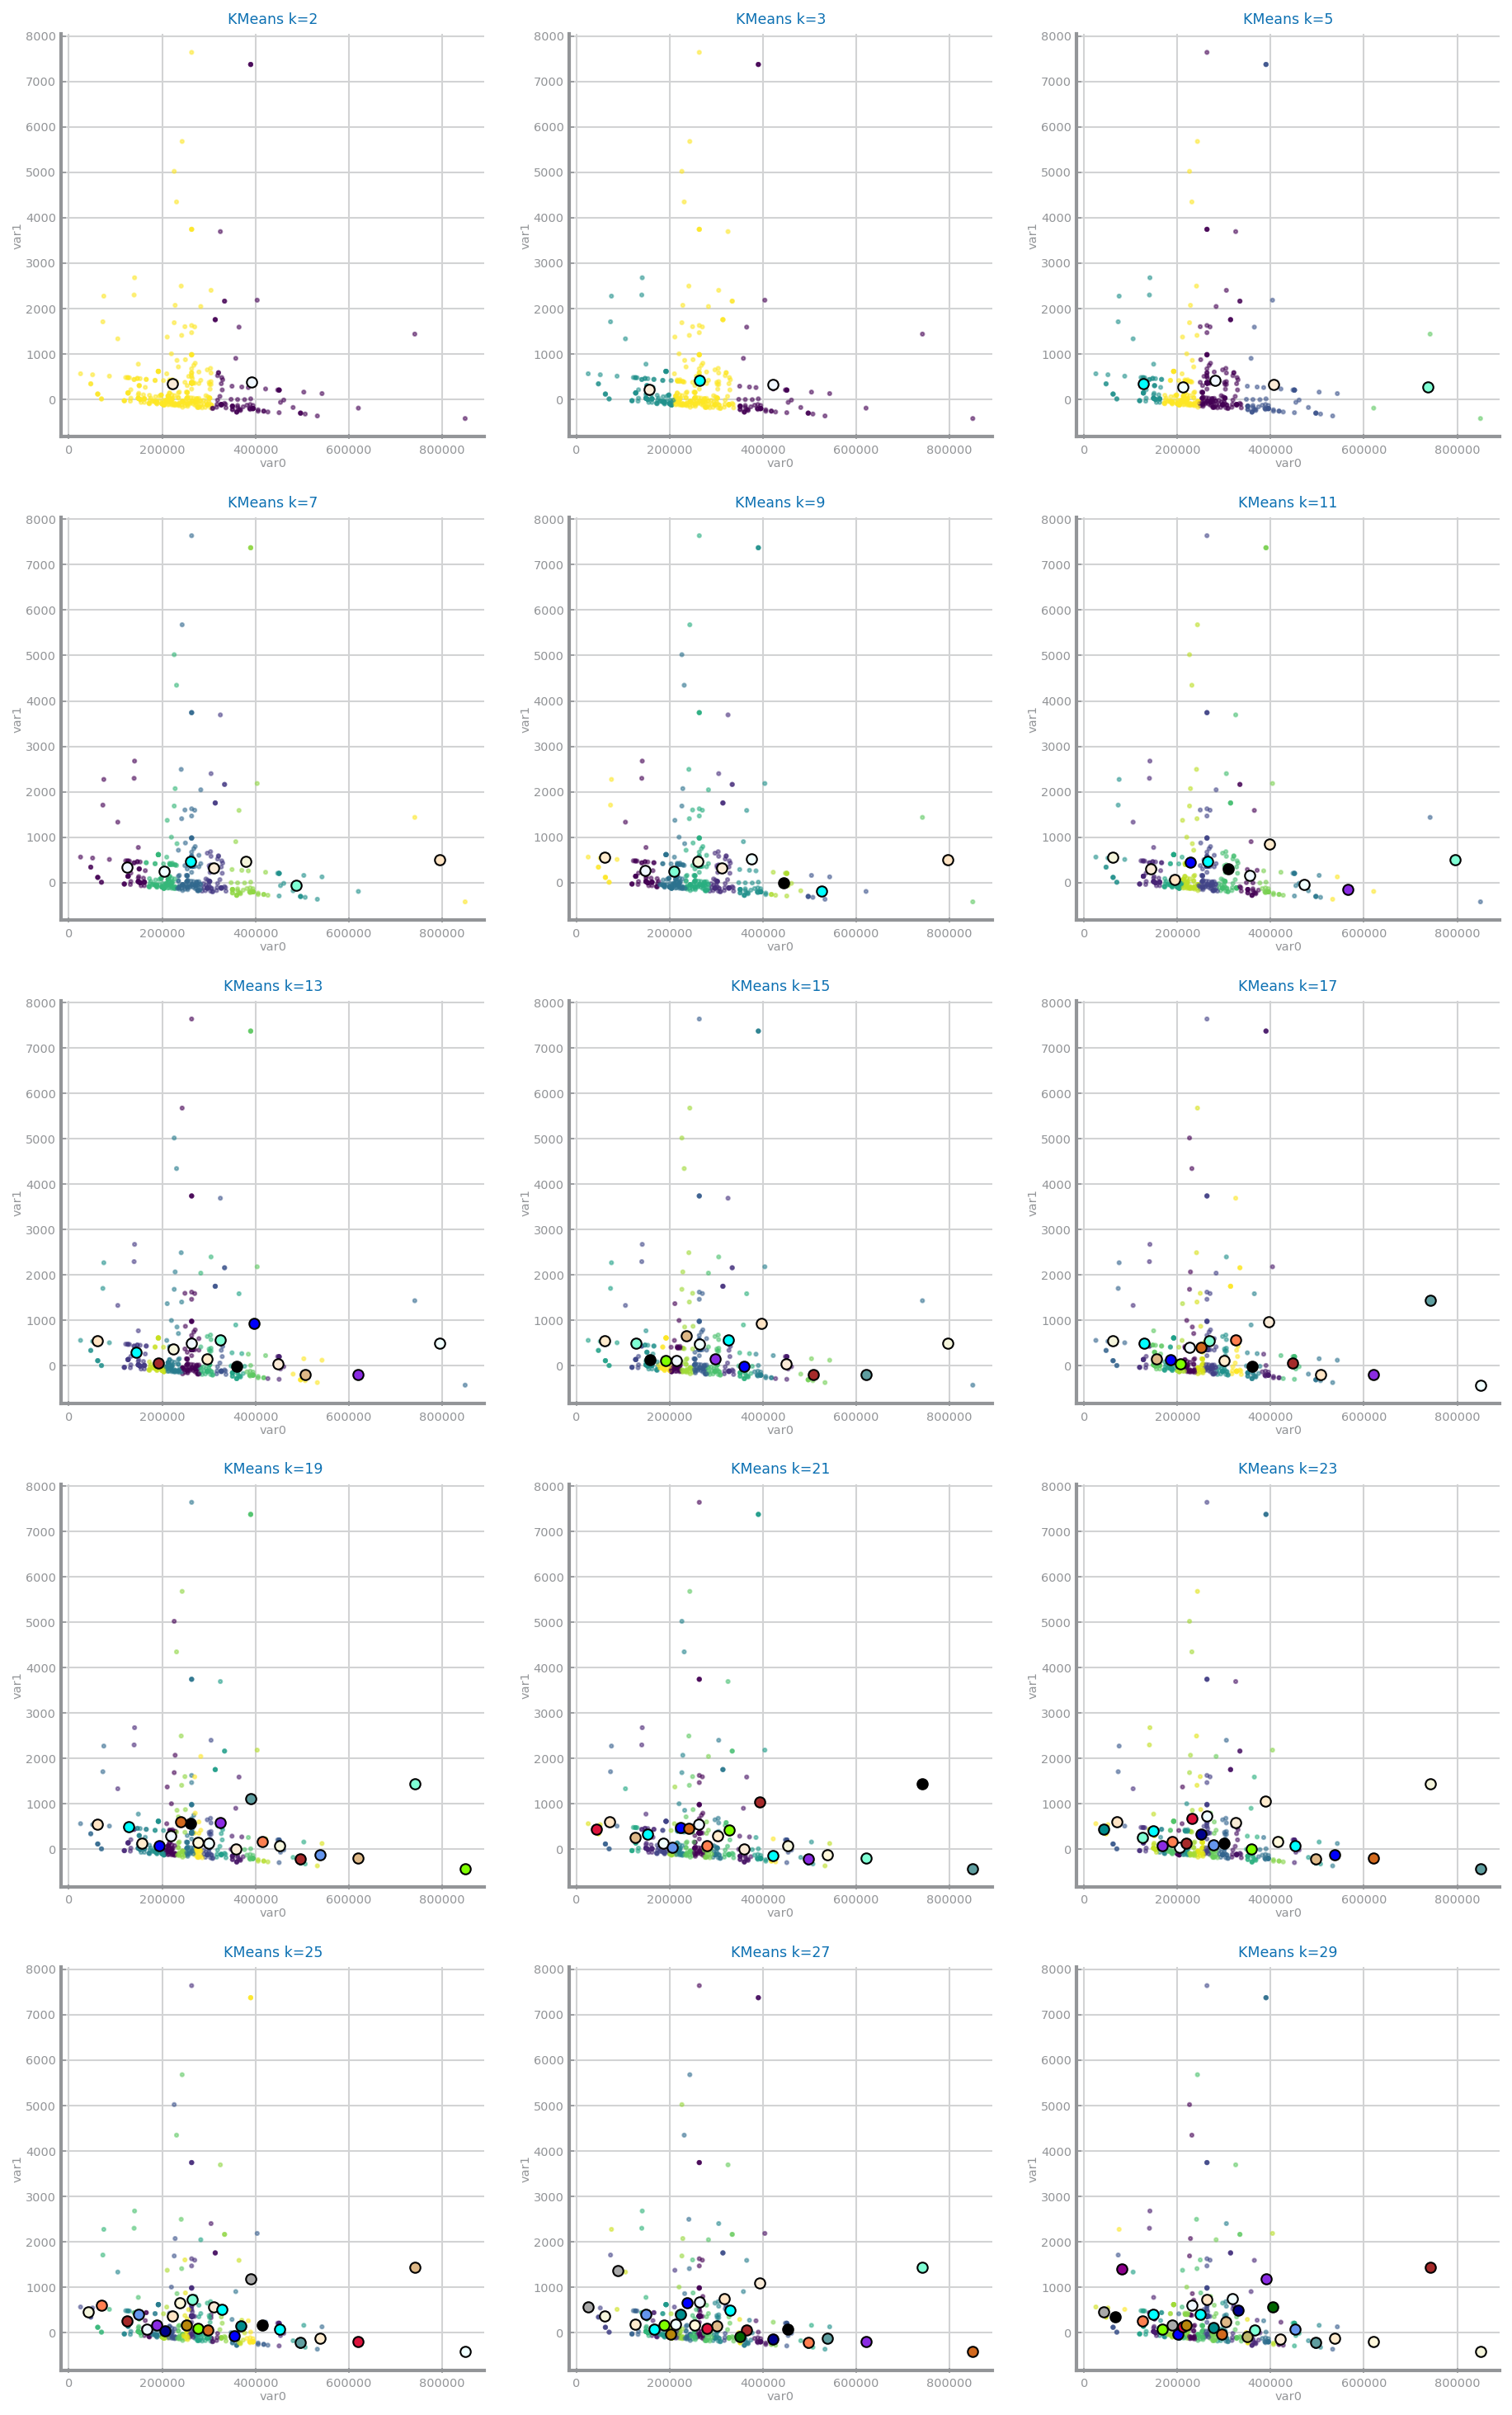

In [15]:
N_CLUSTERS = [2, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
rows, cols = ds.choose_grid(len(N_CLUSTERS))


mse: list = []
sc: list = []
_, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(N_CLUSTERS)):
    k = N_CLUSTERS[n]
    estimator = KMeans(n_clusters=k)
    estimator.fit(data)
    mse.append(estimator.inertia_)
    sc.append(silhouette_score(data, estimator.labels_))
    ds.plot_clusters(data, eixo_x, eixo_y, estimator.labels_.astype(float), estimator.cluster_centers_, k,
                     f'KMeans k={k}', ax=axs[i,j])
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.show()

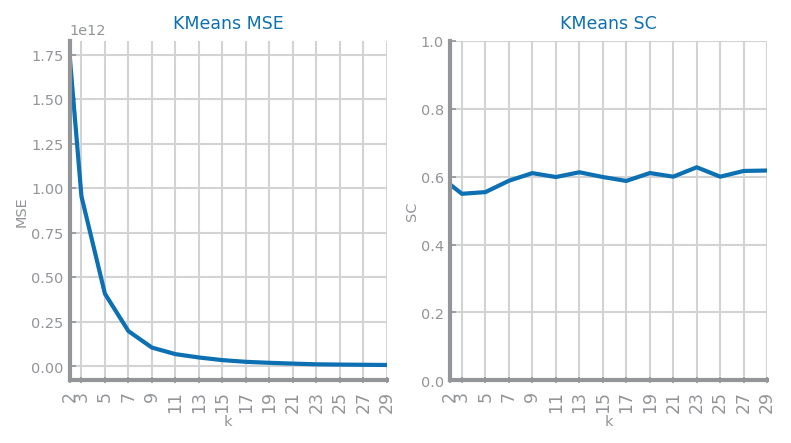

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
ds.plot_line(N_CLUSTERS, mse, title='KMeans MSE', xlabel='k', ylabel='MSE', ax=ax[0, 0])
ds.plot_line(N_CLUSTERS, sc, title='KMeans SC', xlabel='k', ylabel='SC', ax=ax[0, 1], percentage=True)
plt.show()

### Density-based without scaling

*EPS - Studying the Maximum Distance Impact*

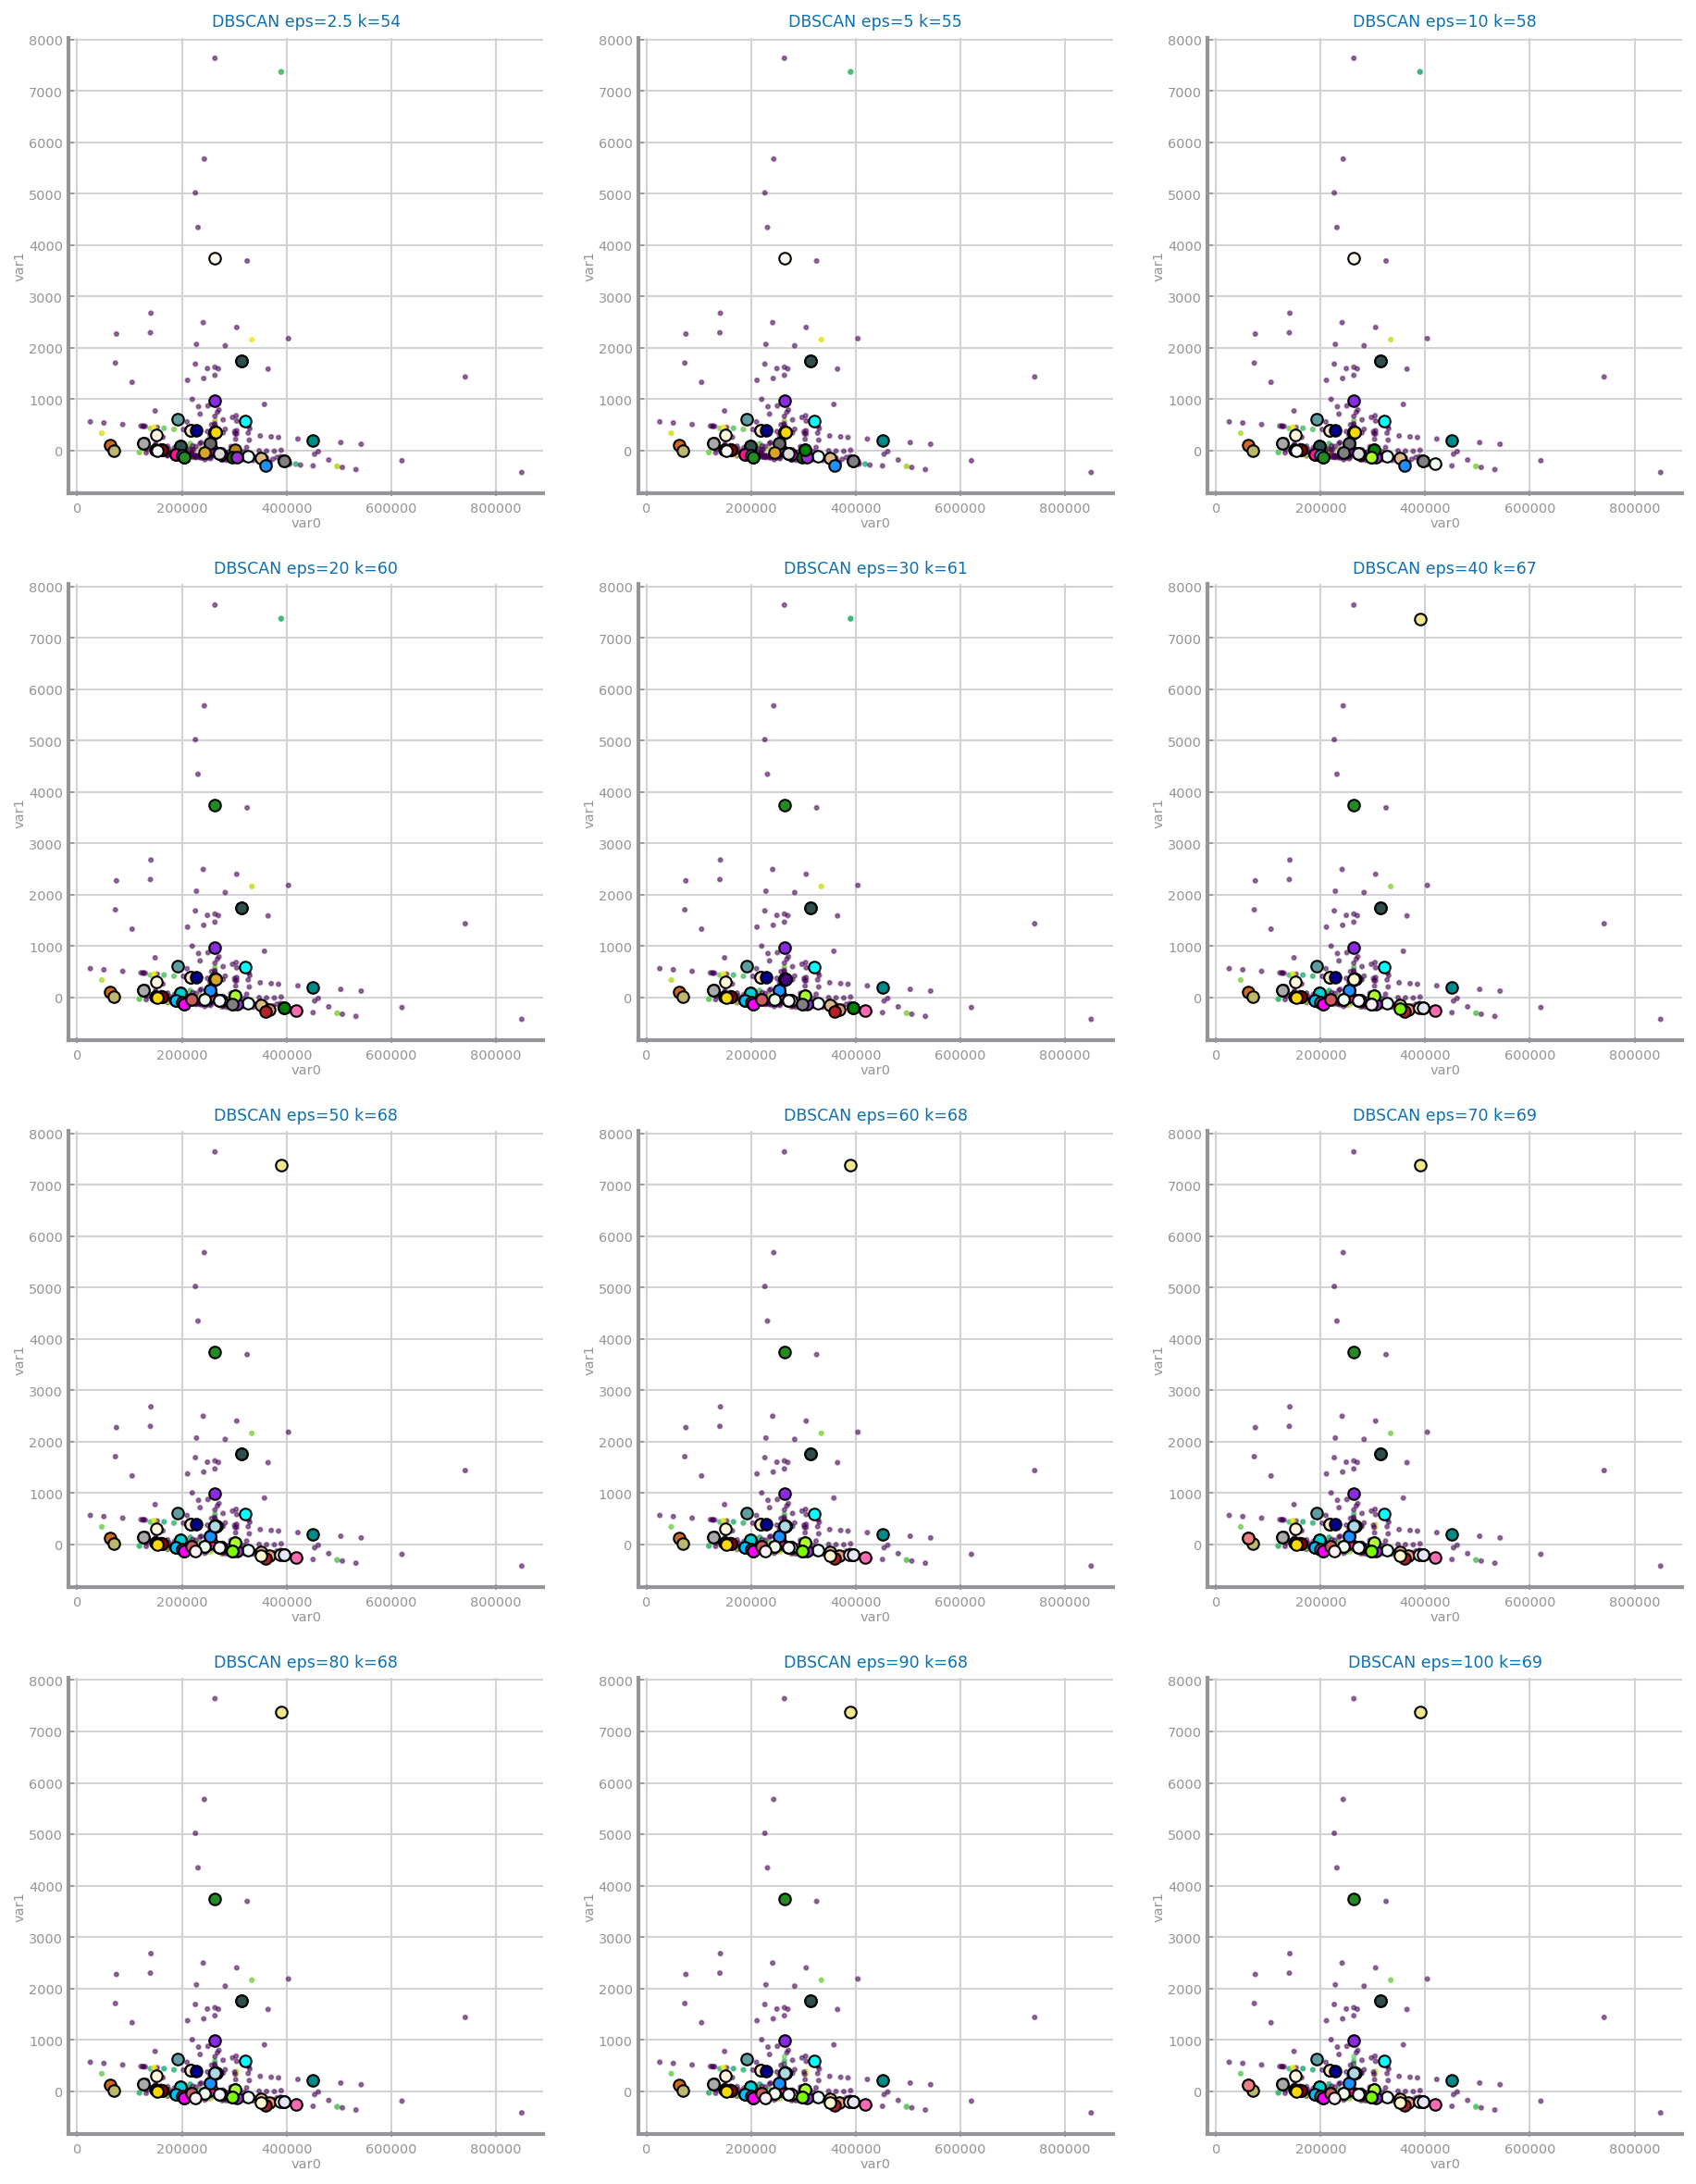

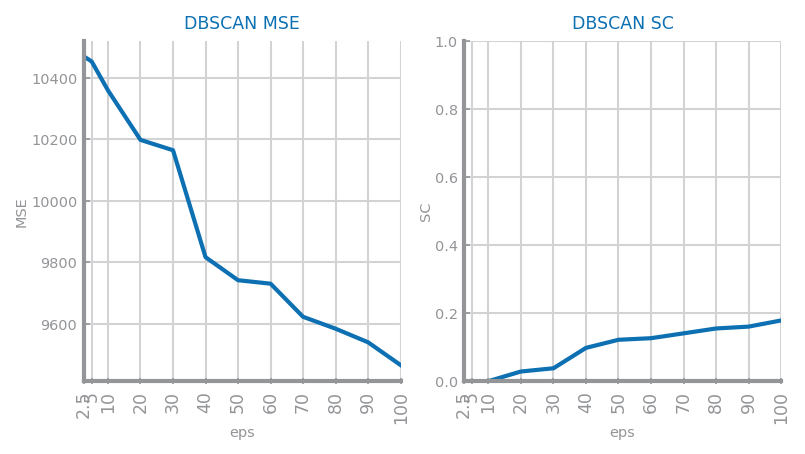

In [29]:
clustering_density_eps(data, eixo_x, eixo_y)

*Metric*

AVG distances among records [102214.8411671156, 102899.66610362435, 102192.62585922745, 1.8181465687700242e-05, 0.9946856269261569]
CHOSEN EPS [80, 50, 80, 0.0005, 0.0009]




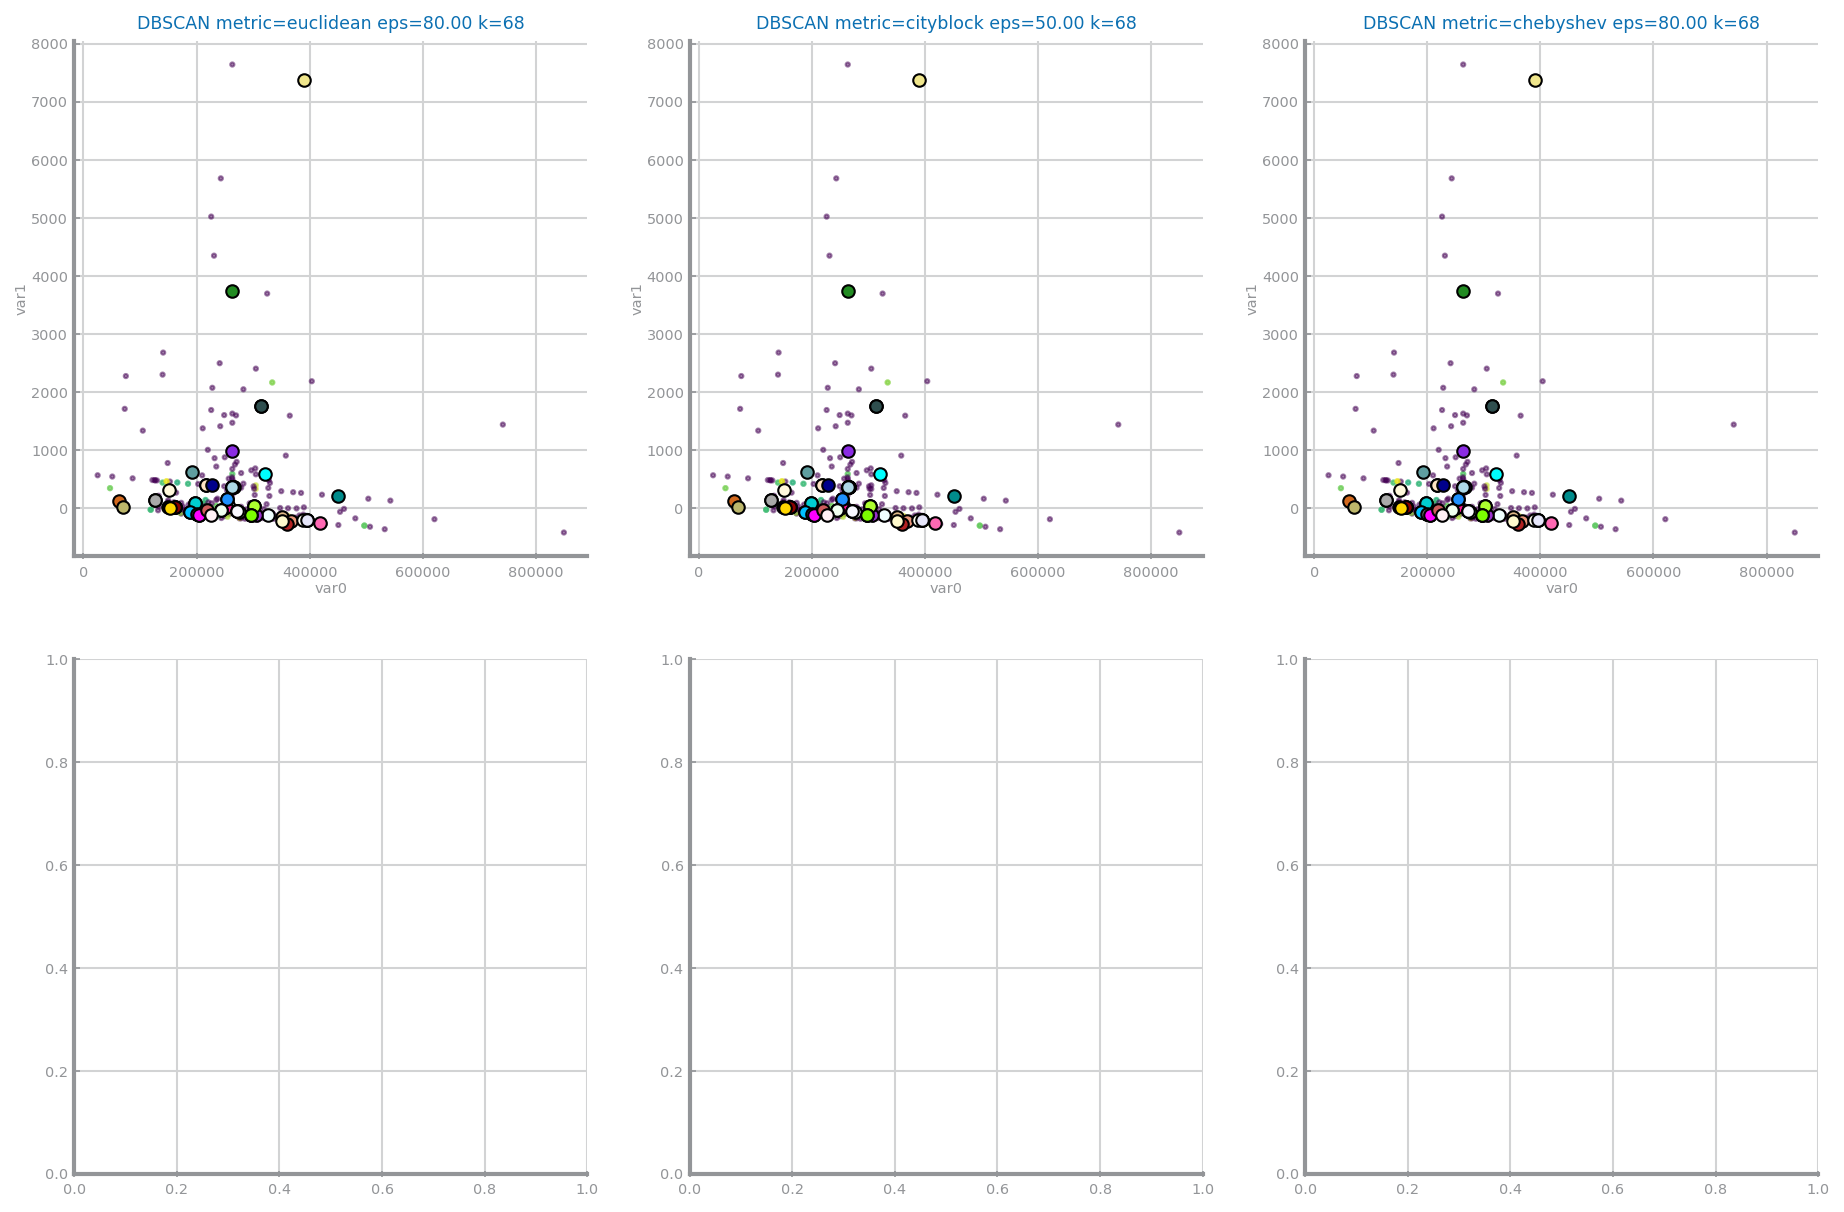

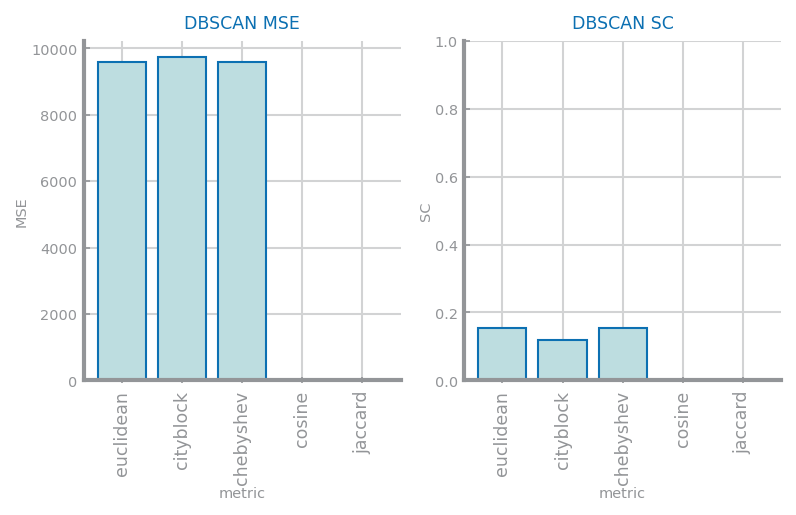

In [31]:
clustering_density_metric(data, eixo_x, eixo_y)

### Hierarchical

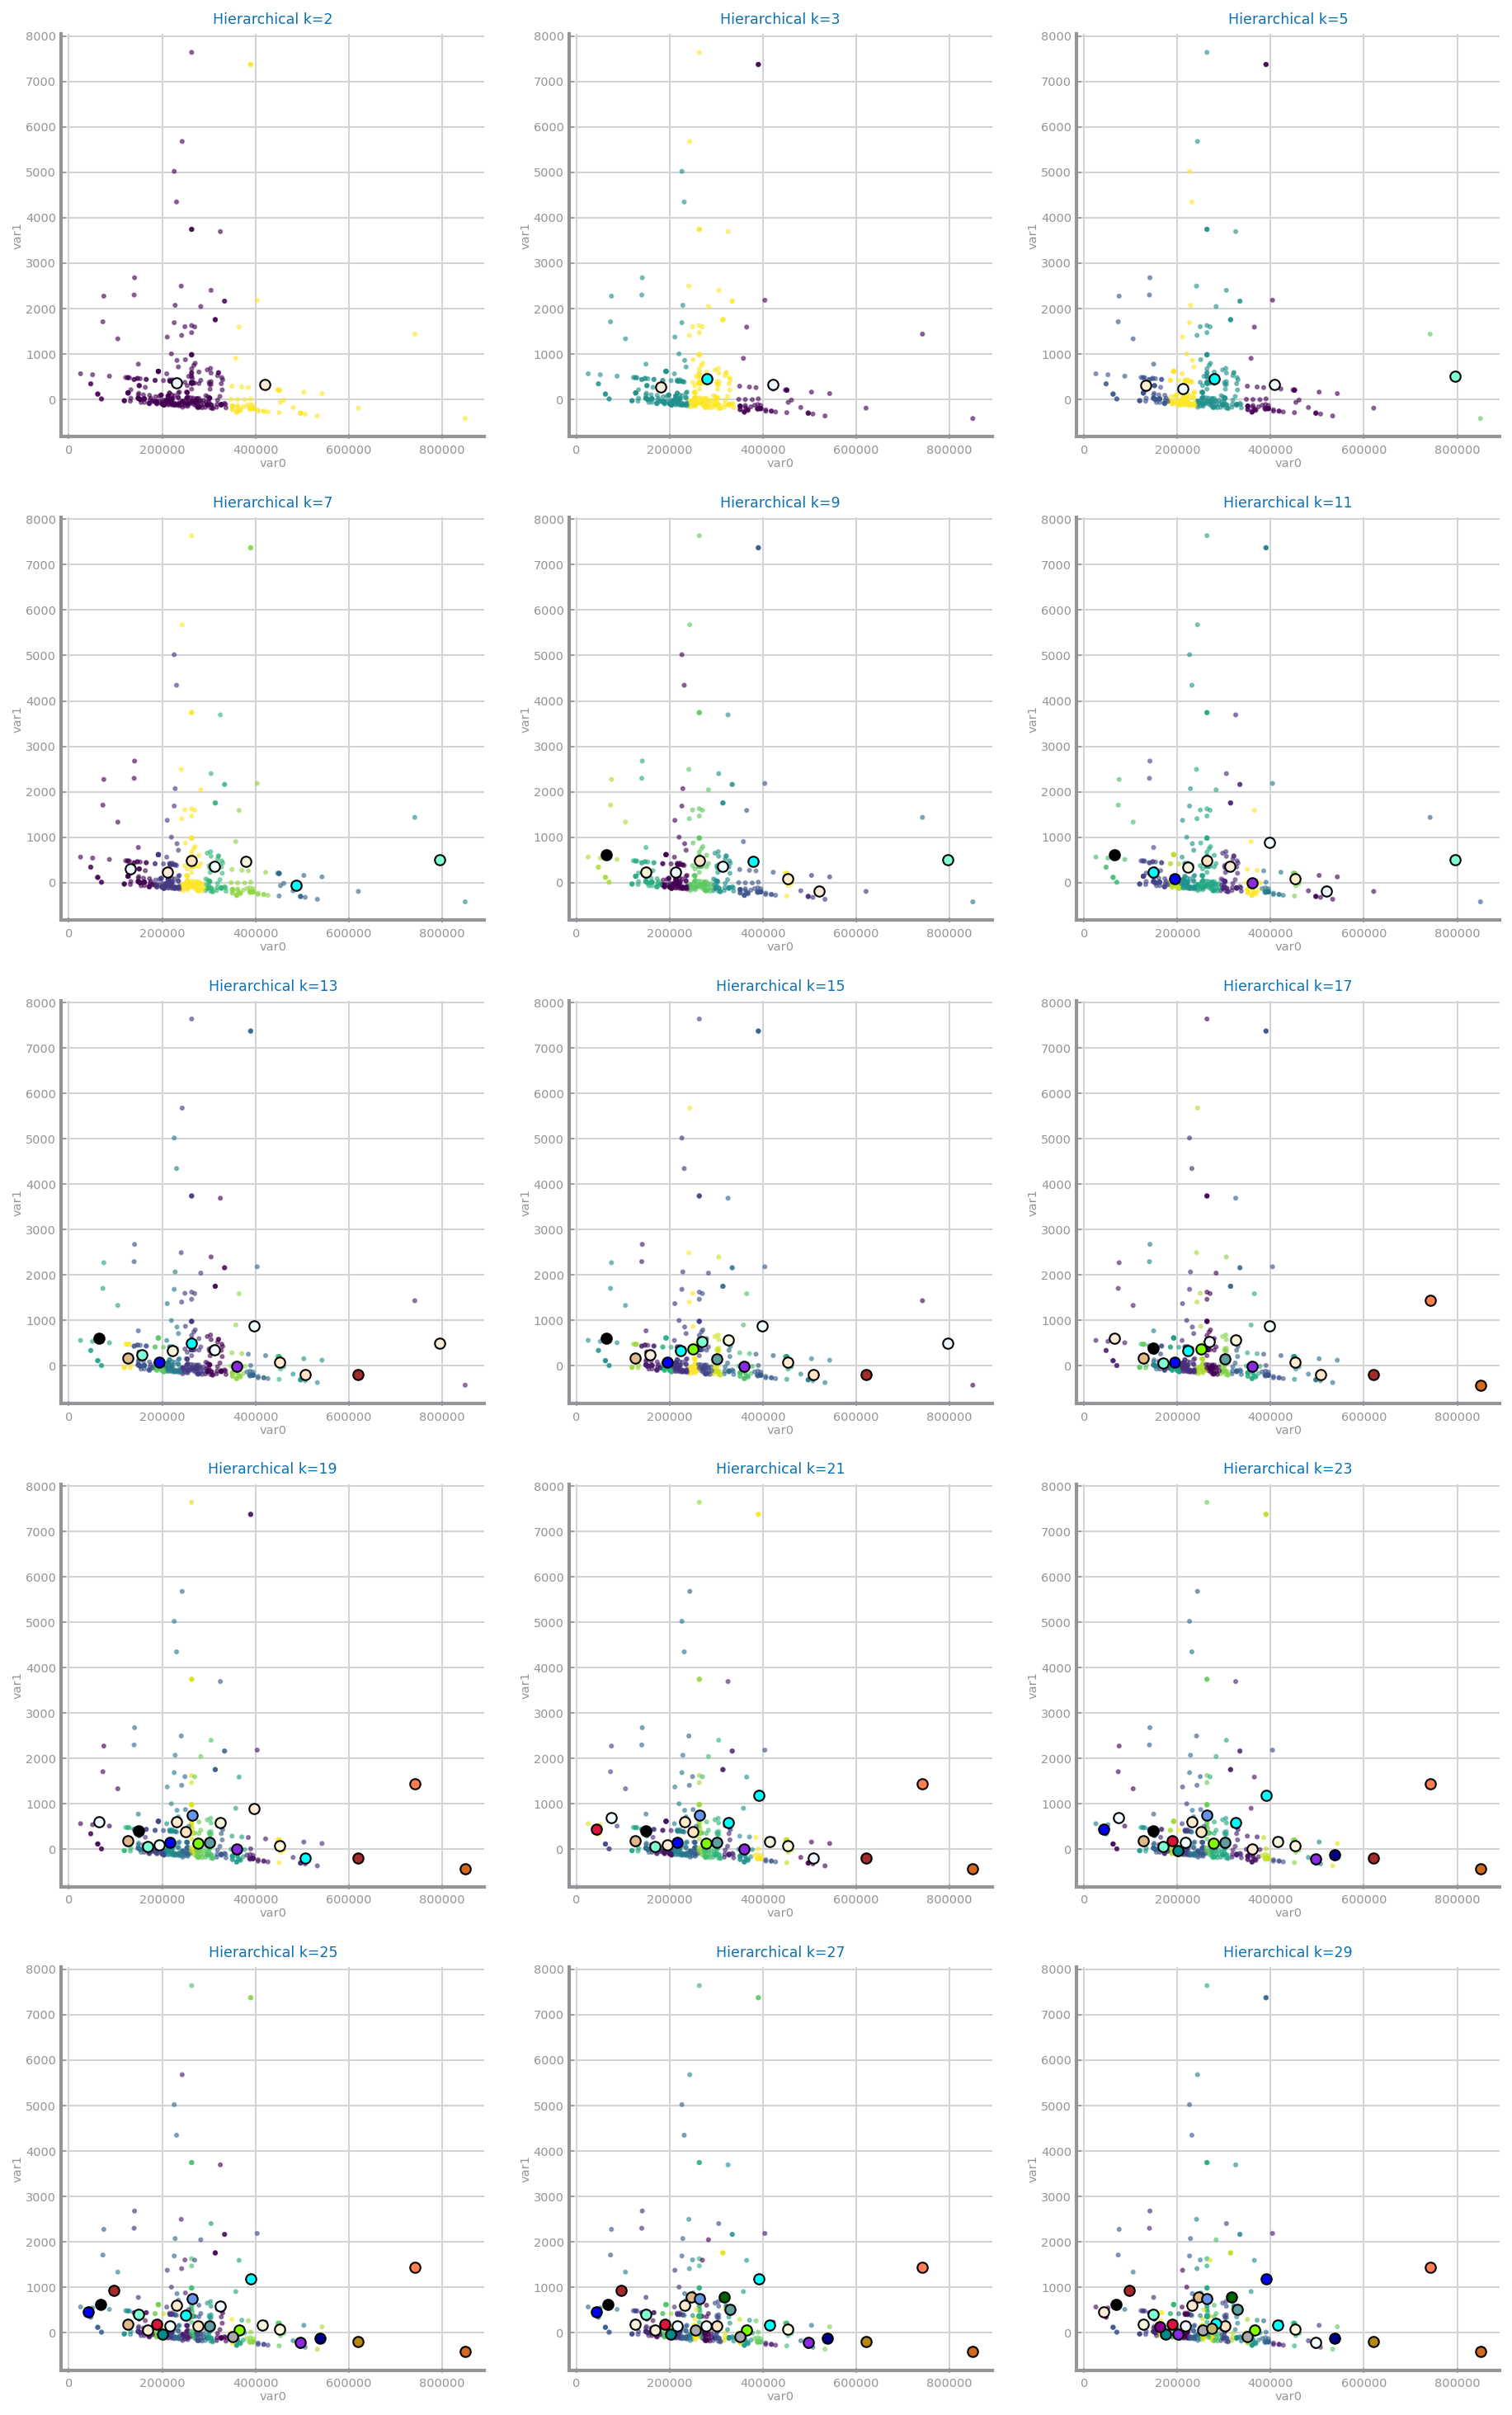

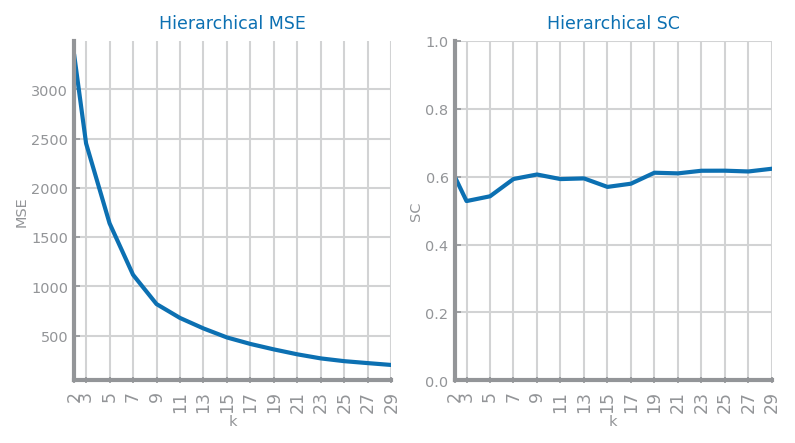

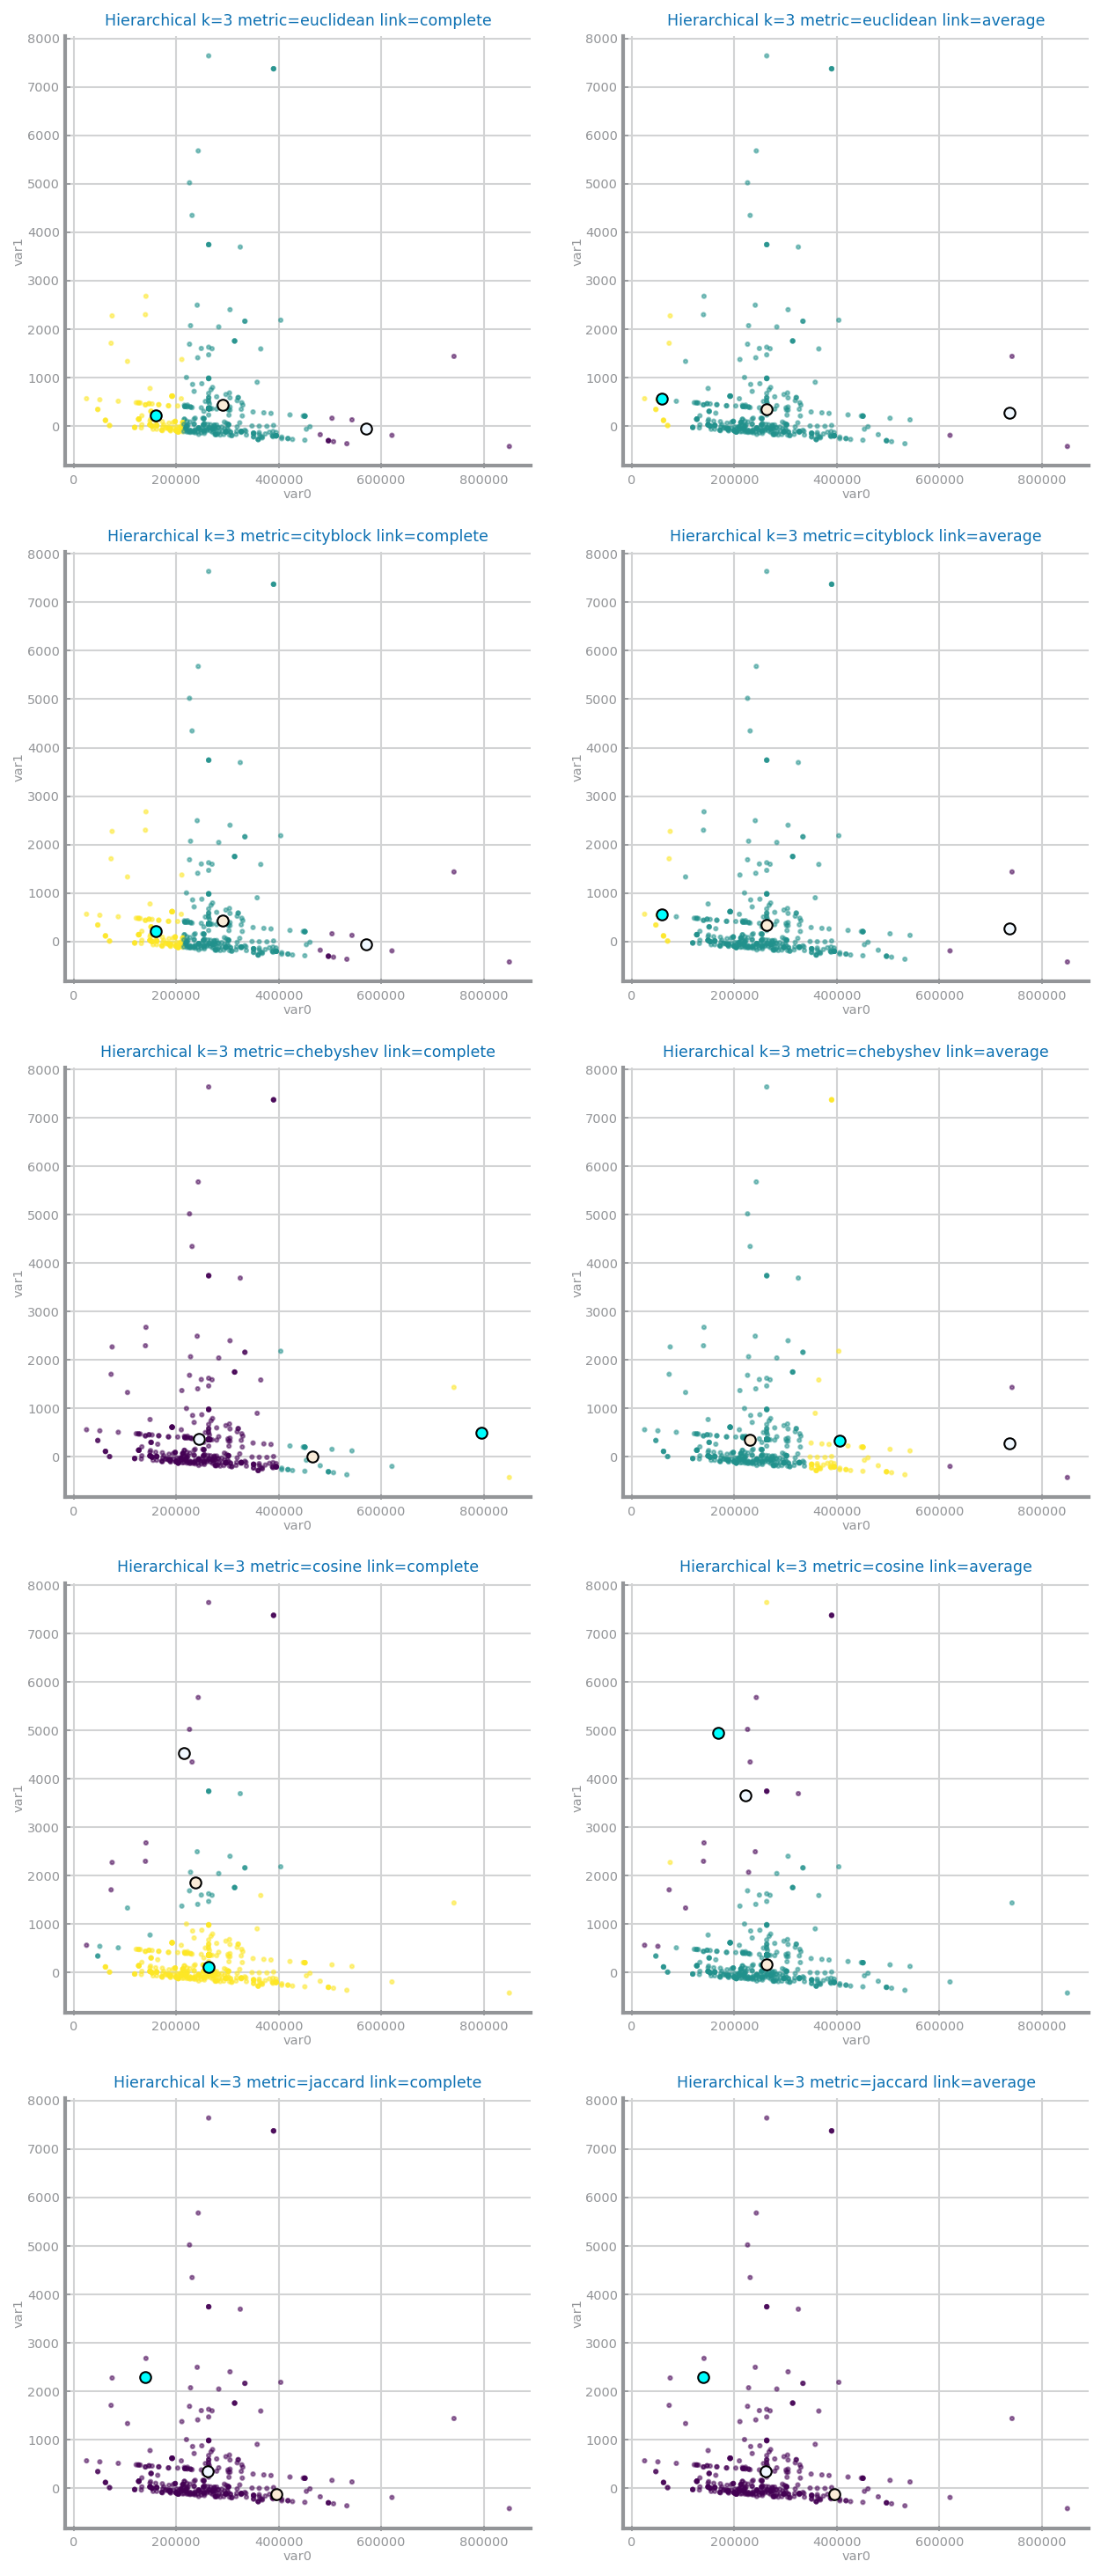

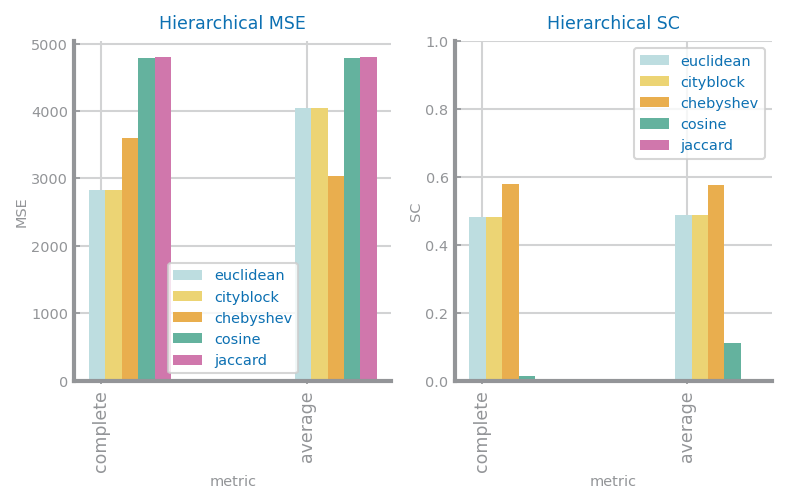

In [32]:
clustering_hierarchical(data, eixo_x, eixo_y)

**PCA scalled sample MINMAX**

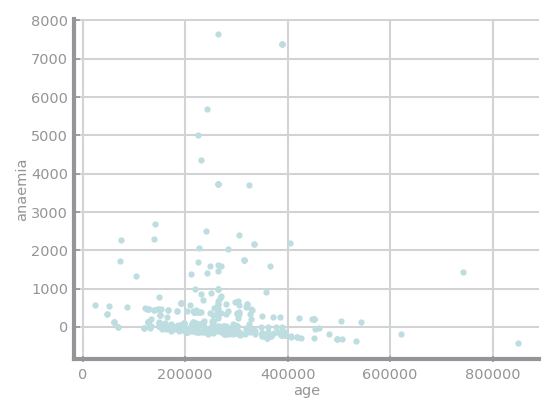

In [34]:
variables = norm_data_minmax.columns.values
eixo_x = 0
eixo_y = 0
eixo_z = 1

plt.figure()
plt.xlabel(variables[eixo_y])
plt.ylabel(variables[eixo_z])
plt.scatter(data.iloc[:, eixo_y], data.iloc[:, eixo_z])
plt.show()

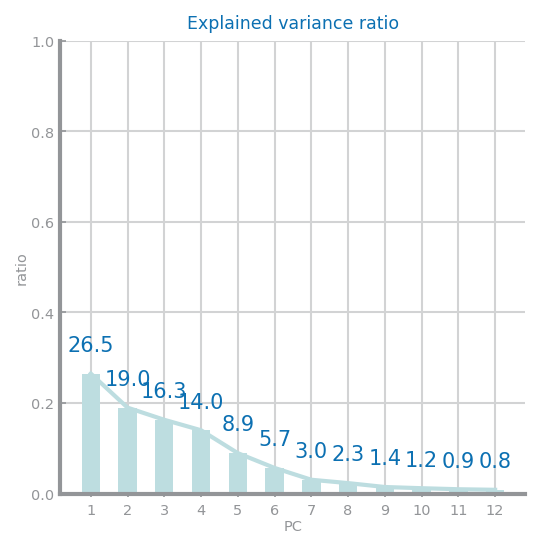

In [35]:
mean = (norm_data_minmax.mean(axis=0)).tolist()
centered_data = norm_data_minmax - mean
cov_mtx = centered_data.cov()
eigvals, eigvecs = np.linalg.eig(cov_mtx)

pca = PCA()
pca.fit(centered_data)
PC = pca.components_
var = pca.explained_variance_

# PLOT EXPLAINED VARIANCE RATIO
fig = plt.figure(figsize=(4, 4))
plt.title('Explained variance ratio')
plt.xlabel('PC')
plt.ylabel('ratio')
x_values = [str(i) for i in range(1, len(pca.components_) + 1)]
bwidth = 0.5
ax = plt.gca()
ax.set_xticklabels(x_values)
ax.set_ylim(0.0, 1.0)
ax.bar(x_values, pca.explained_variance_ratio_, width=bwidth)
ax.plot(pca.explained_variance_ratio_)
for i, v in enumerate(pca.explained_variance_ratio_):
    ax.text(i, v+0.05, f'{v*100:.1f}', ha='center')
plt.show()

In [36]:
var_cumsum = np.cumsum(pca.explained_variance_ratio_)
np.argwhere(var_cumsum > 0.88)[0]

array([5])

In [37]:
var_cumsum = np.cumsum(pca.explained_variance_ratio_)
np.argwhere(var_cumsum > 0.93)[0]

array([6])

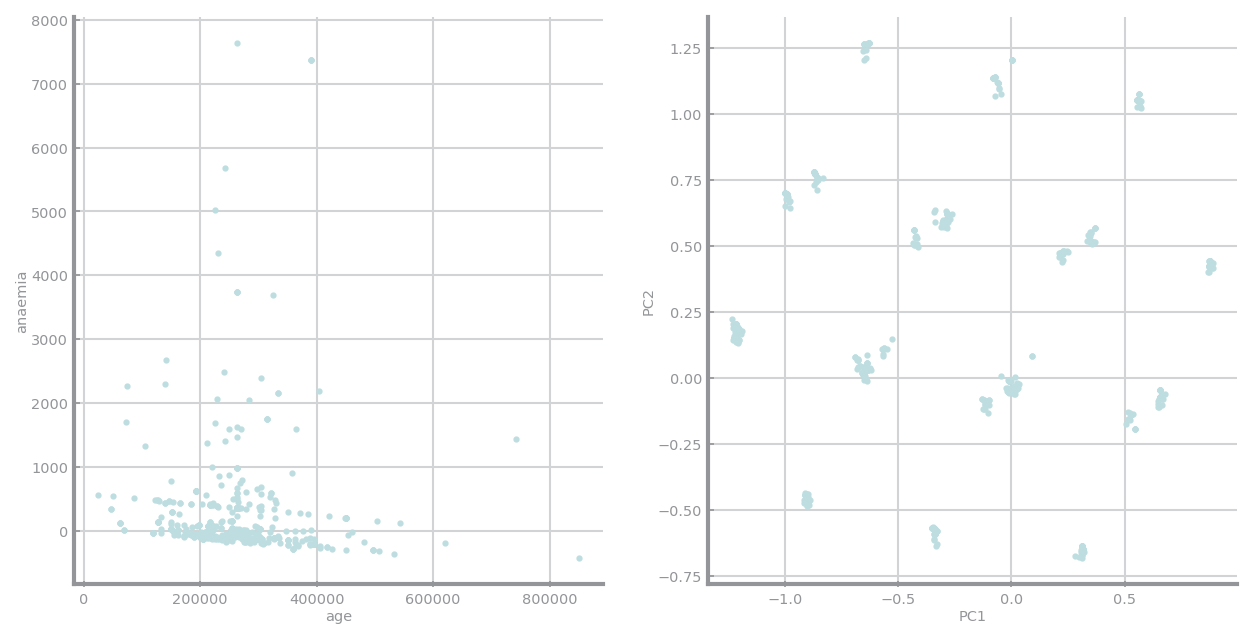

In [38]:
transf = pca.transform(norm_data_minmax)

_, axs = plt.subplots(1, 2, figsize=(2*5, 1*5), squeeze=False)
axs[0,0].set_xlabel(variables[eixo_y])
axs[0,0].set_ylabel(variables[eixo_z])
axs[0,0].scatter(data.iloc[:, eixo_y], data.iloc[:, eixo_z])

axs[0,1].set_xlabel('PC1')
axs[0,1].set_ylabel('PC2')
axs[0,1].scatter(transf[:, 0], transf[:, 1])
plt.show()

**Clustering** comparison after PCA

In [39]:
data = pd.DataFrame(transf[:,:2], columns=['PC1', 'PC2'])
eixo_x = 0
eixo_y = 1

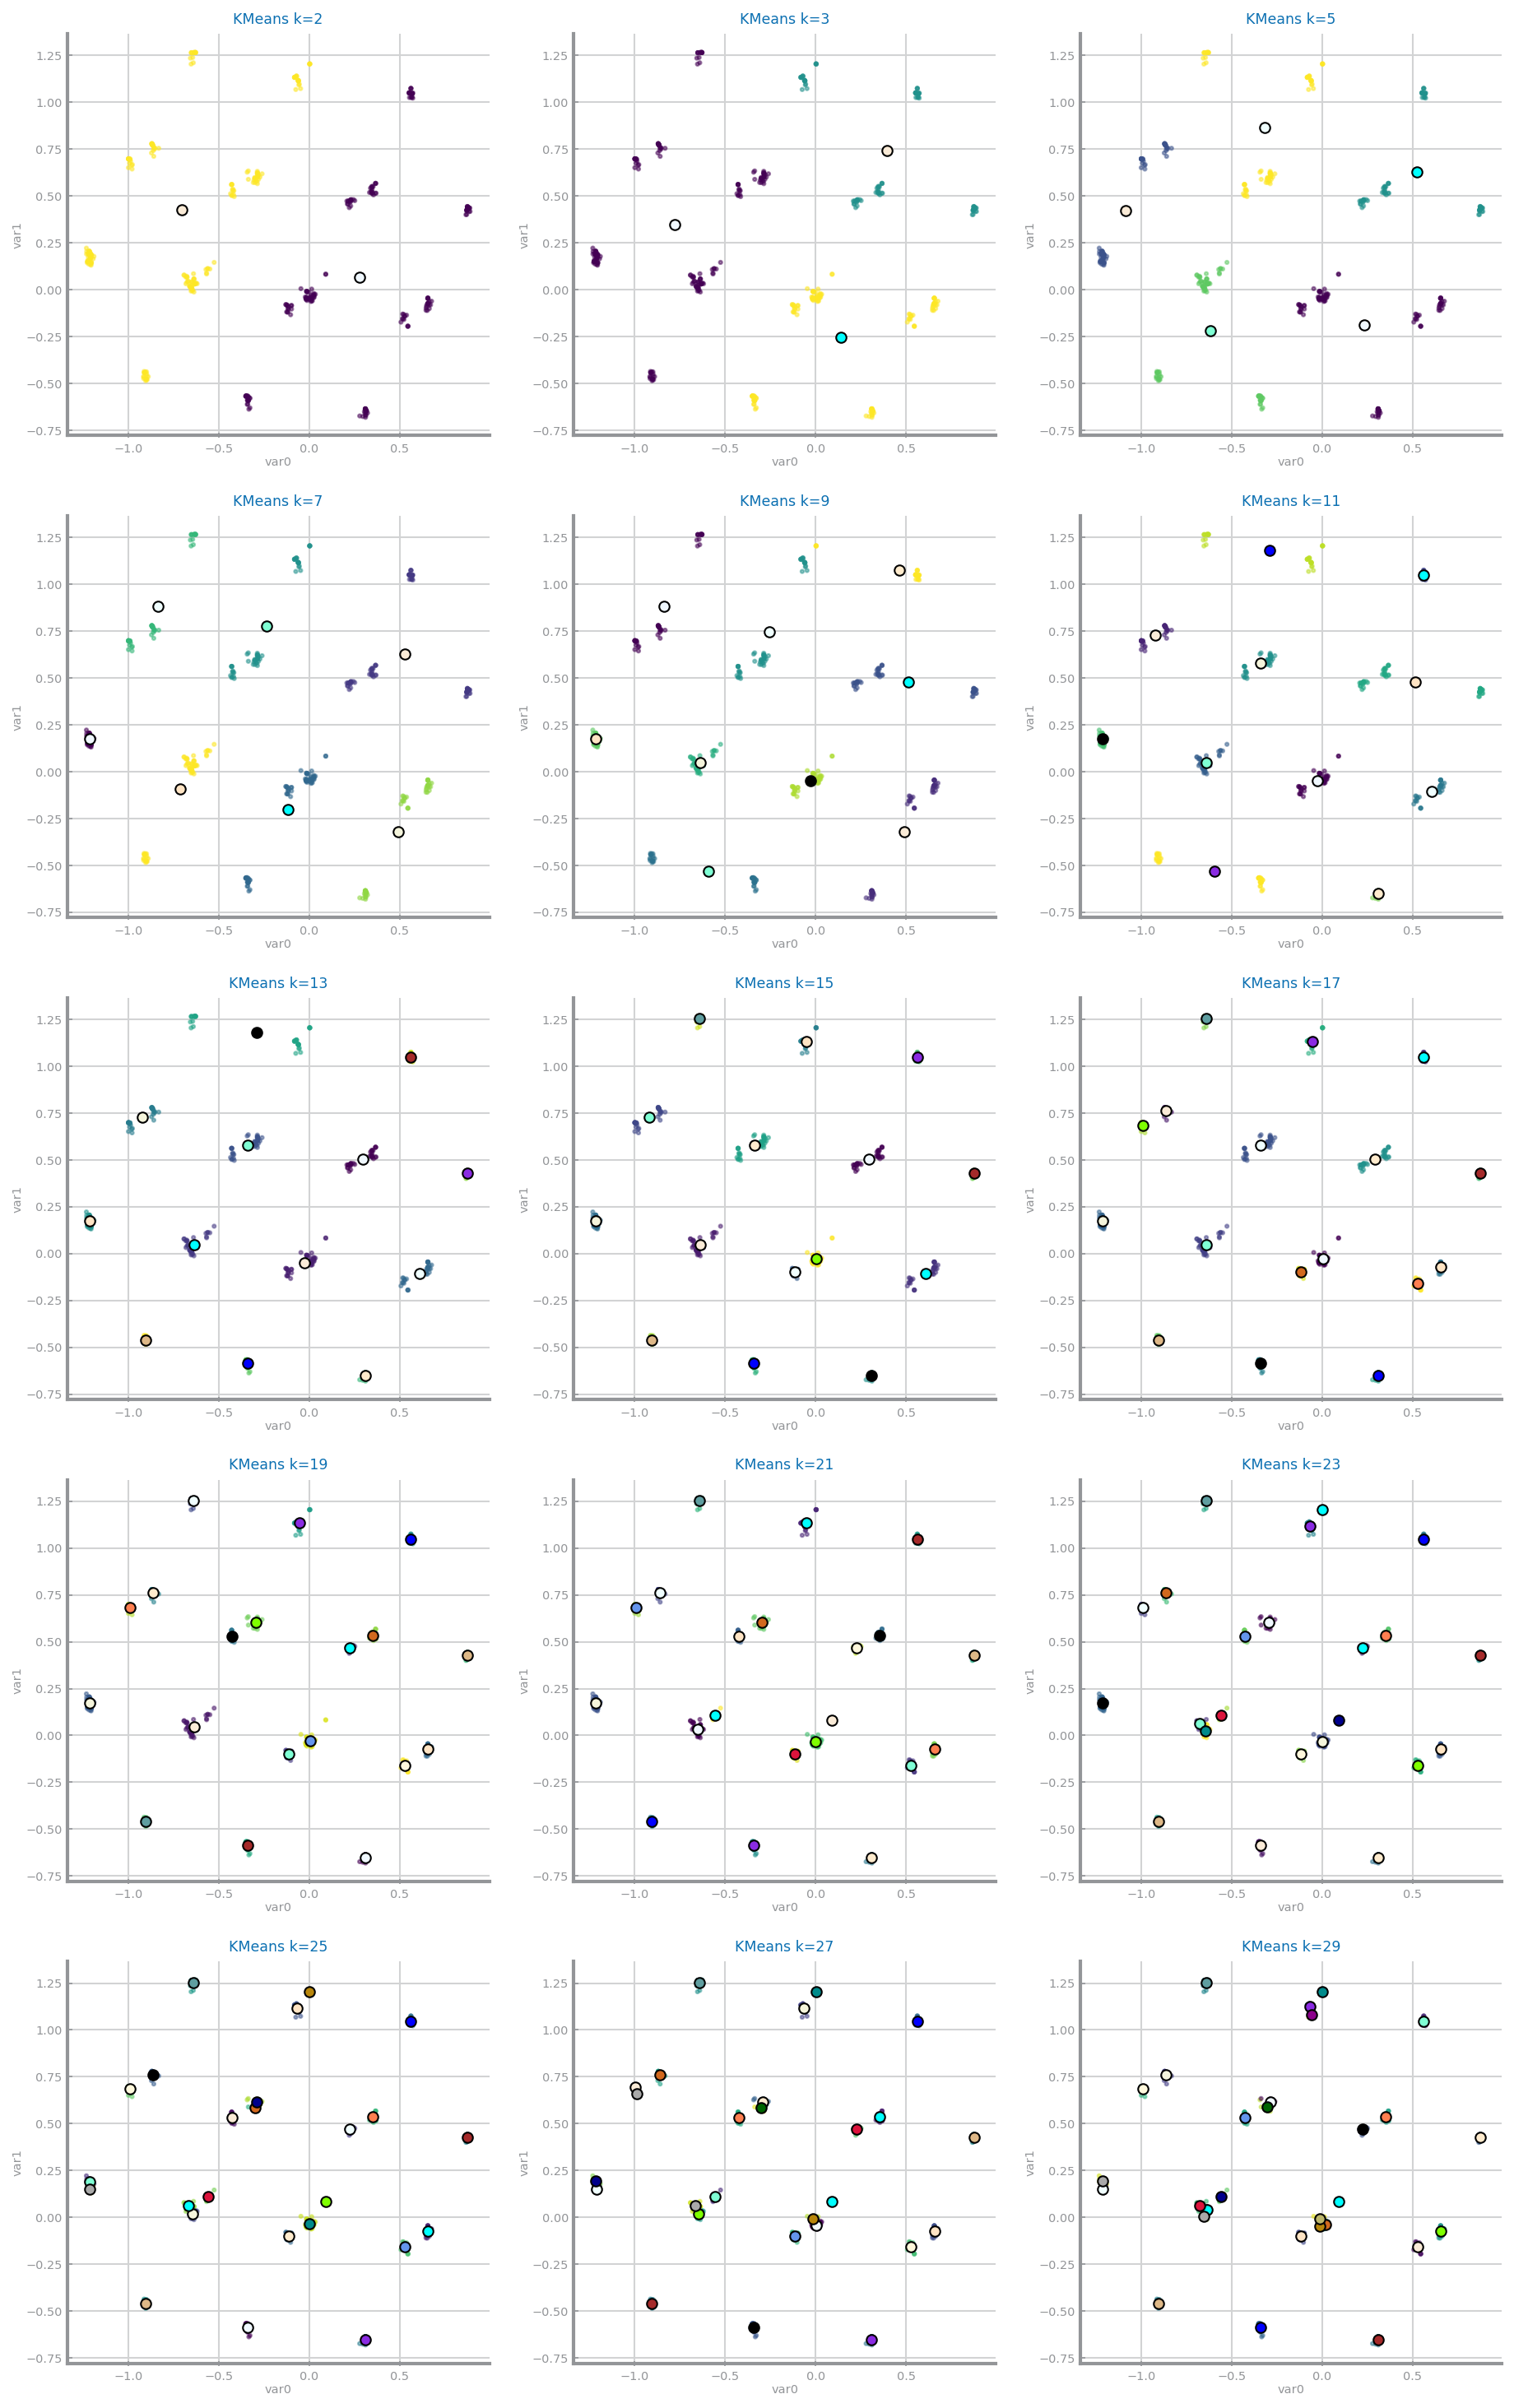

In [22]:
N_CLUSTERS = [2, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
rows, cols = ds.choose_grid(len(N_CLUSTERS))

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

mse: list = []
sc: list = []
_, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(N_CLUSTERS)):
    k = N_CLUSTERS[n]
    estimator = KMeans(n_clusters=k)
    estimator.fit(data)
    mse.append(estimator.inertia_)
    sc.append(silhouette_score(data, estimator.labels_))
    ds.plot_clusters(data, eixo_x, eixo_y, estimator.labels_.astype(float), estimator.cluster_centers_, k,
                     f'KMeans k={k}', ax=axs[i,j])
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.show()

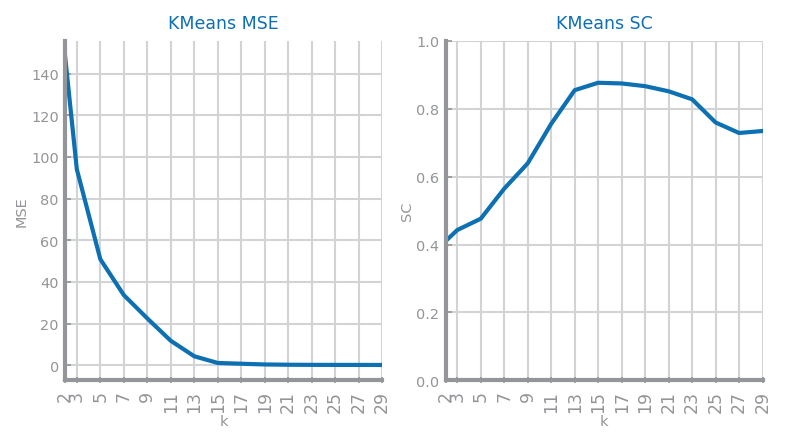

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
ds.plot_line(N_CLUSTERS, mse, title='KMeans MSE', xlabel='k', ylabel='MSE', ax=ax[0, 0])
ds.plot_line(N_CLUSTERS, sc, title='KMeans SC', xlabel='k', ylabel='SC', ax=ax[0, 1], percentage=True)
plt.show()

### Density-based scalled sample MINMAX

*EPS - Studying the Maximum Distance Impact*

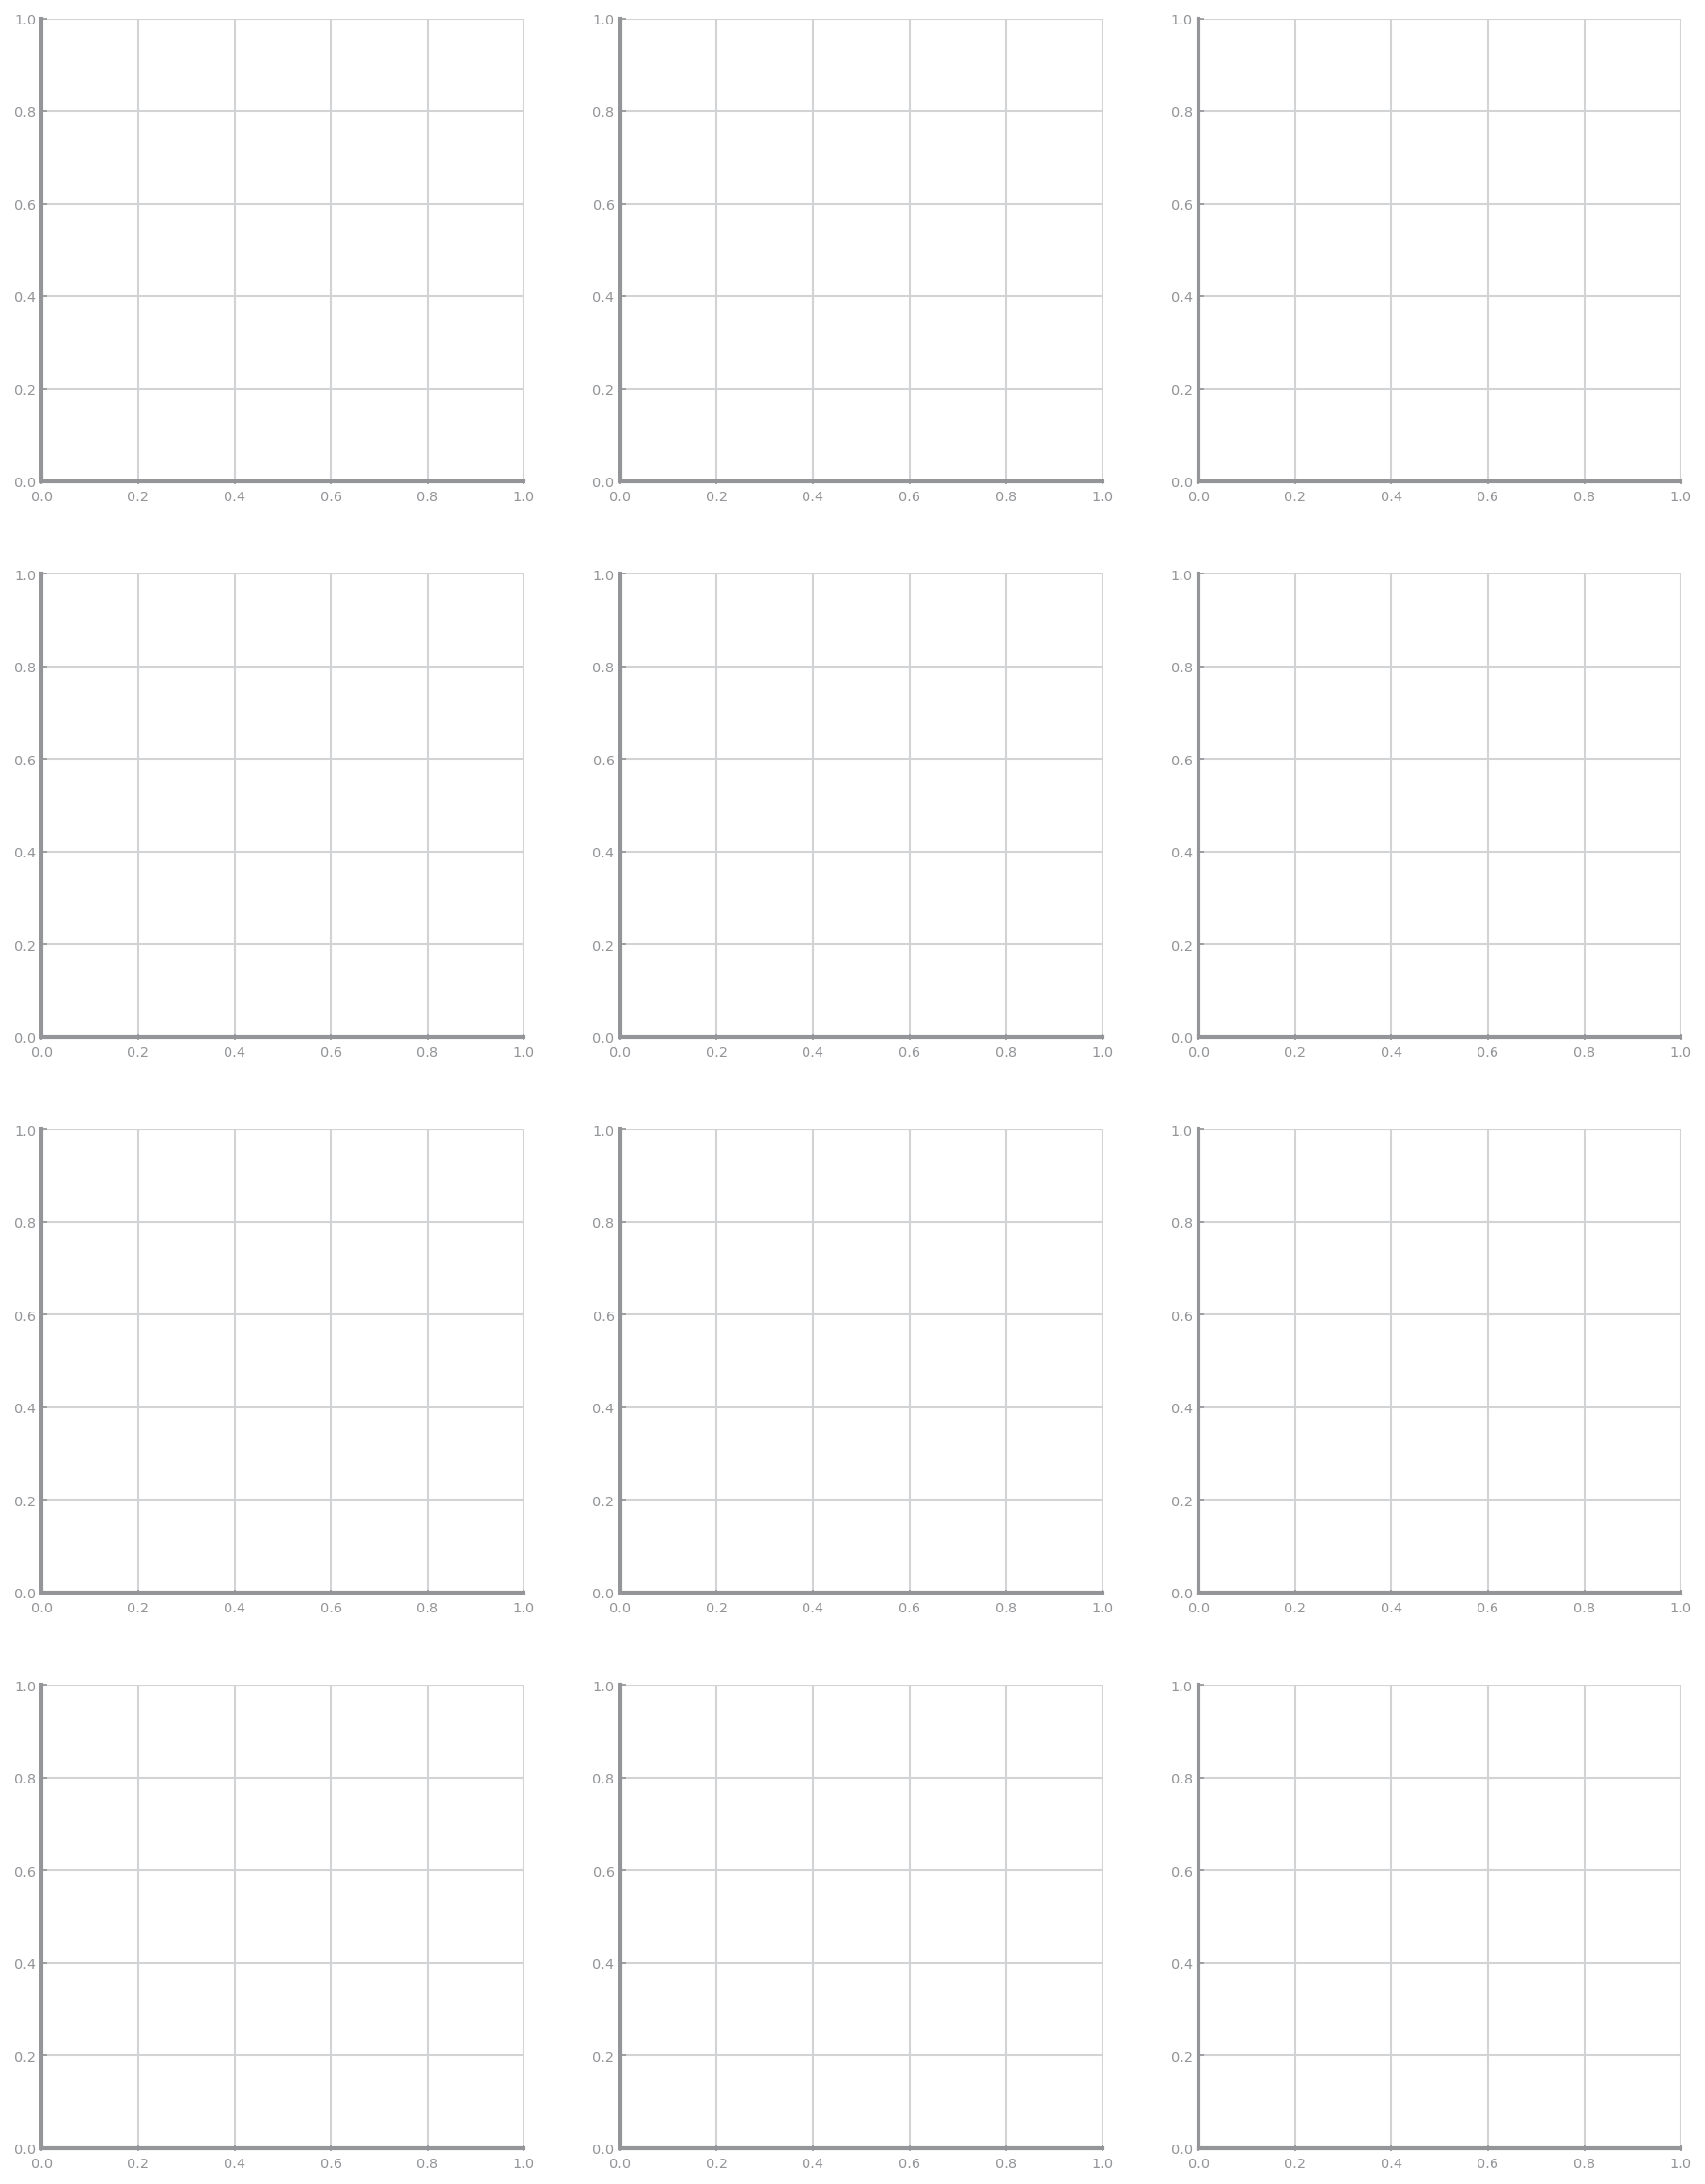

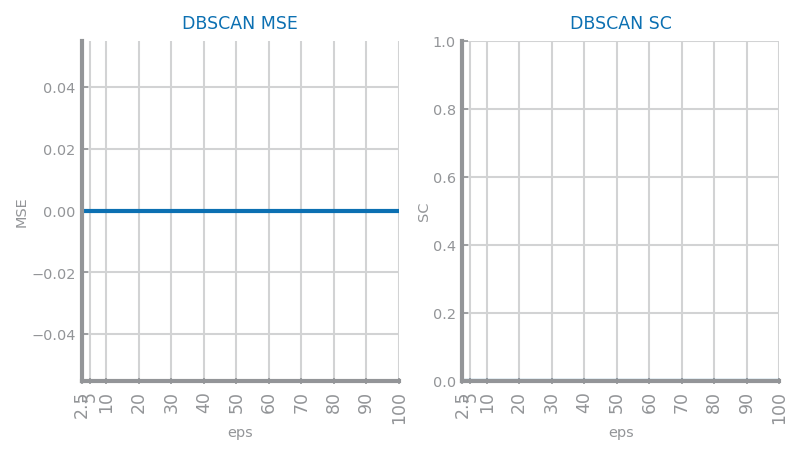

In [40]:
clustering_density_eps(data, eixo_x, eixo_y)

*Metric*

AVG distances among records [1.0128975621006968, 1.2885663777158094, 0.918339269936601, 0.9286672183648774, 0.9946856269261569]
CHOSEN EPS [80, 50, 80, 0.0005, 0.0009]




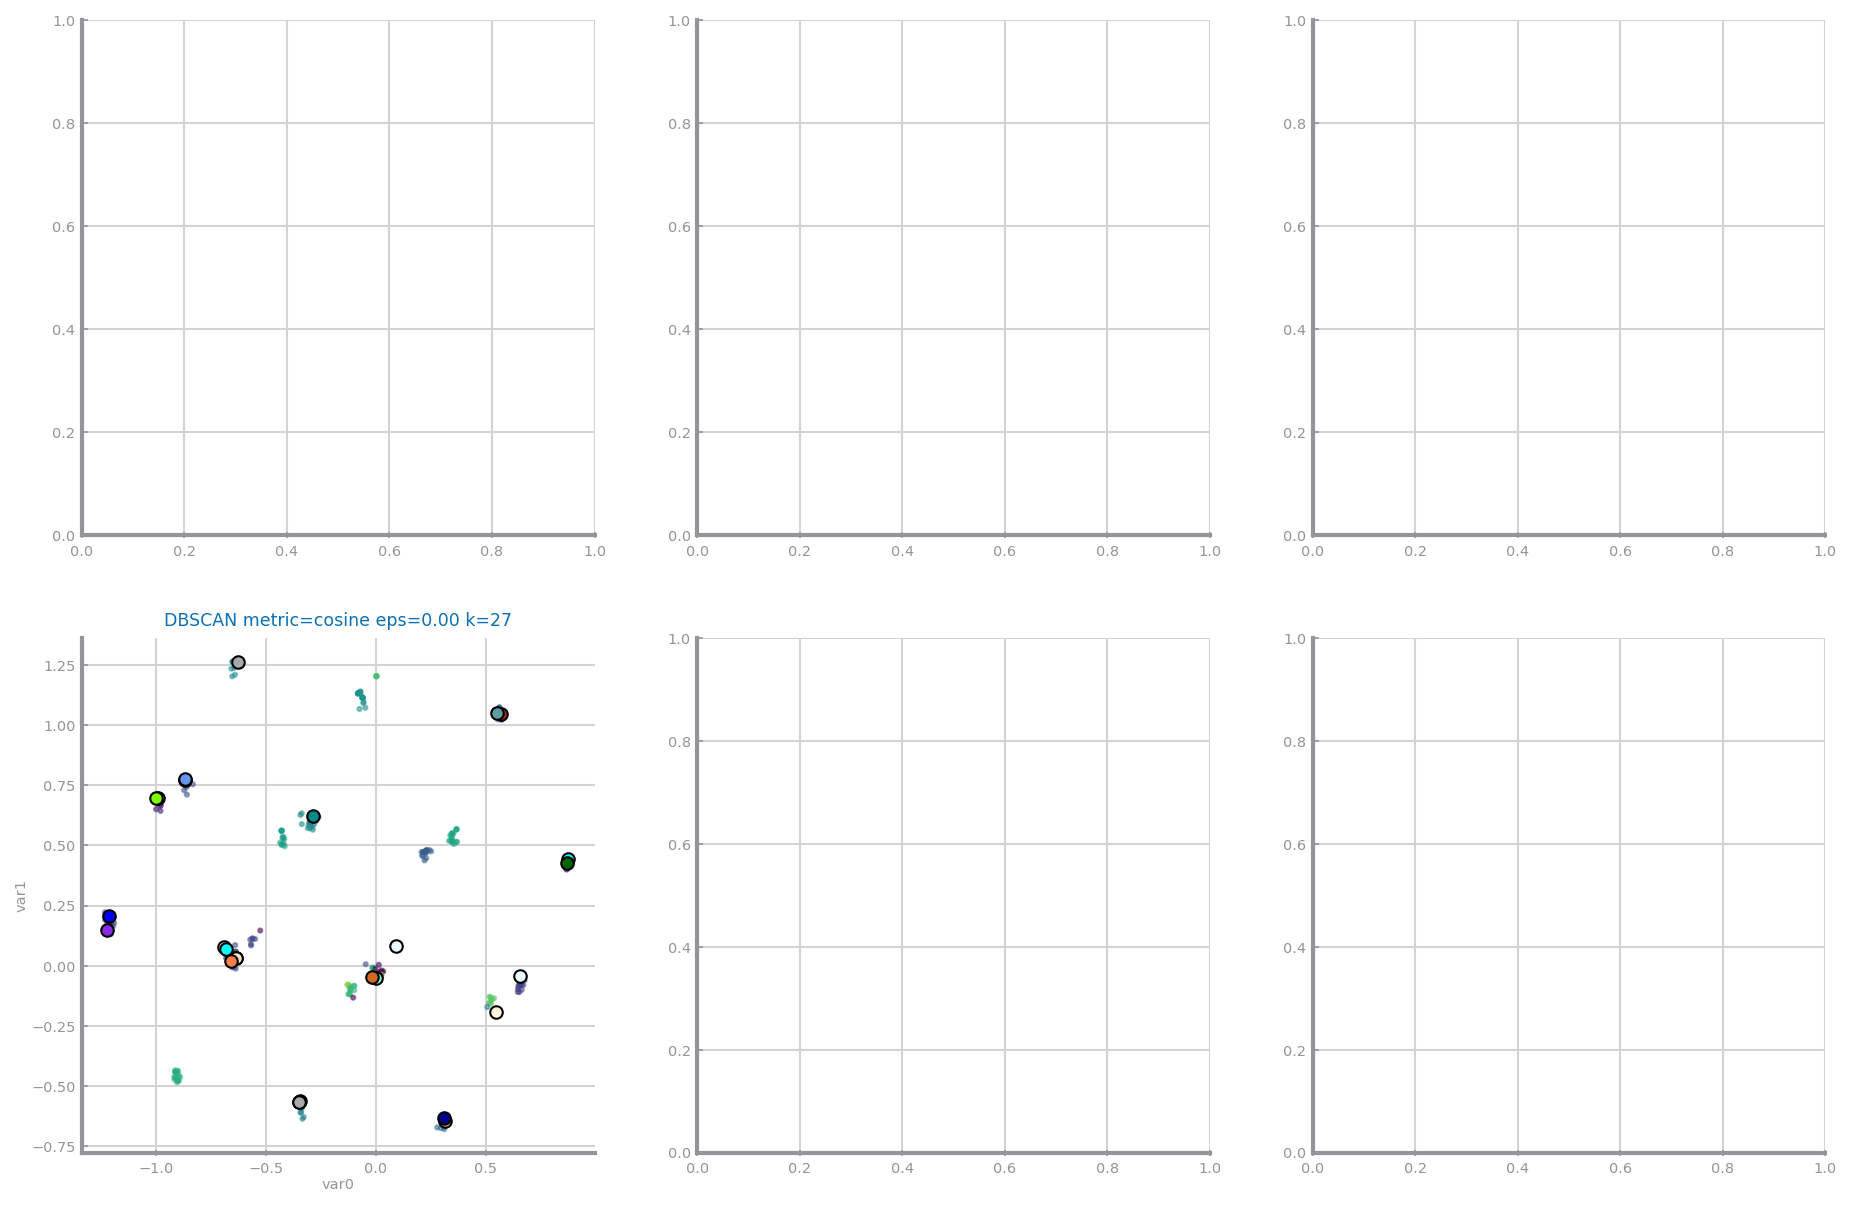

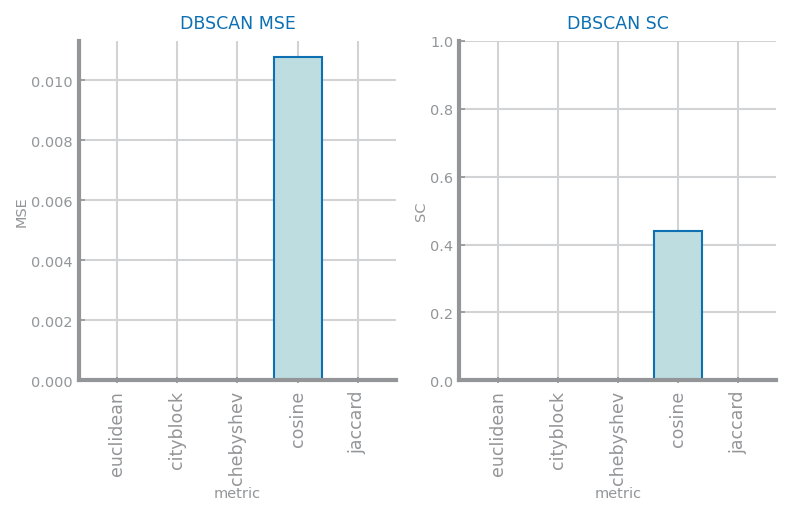

In [41]:
clustering_density_metric(data, eixo_x, eixo_y)

### Hierarchical

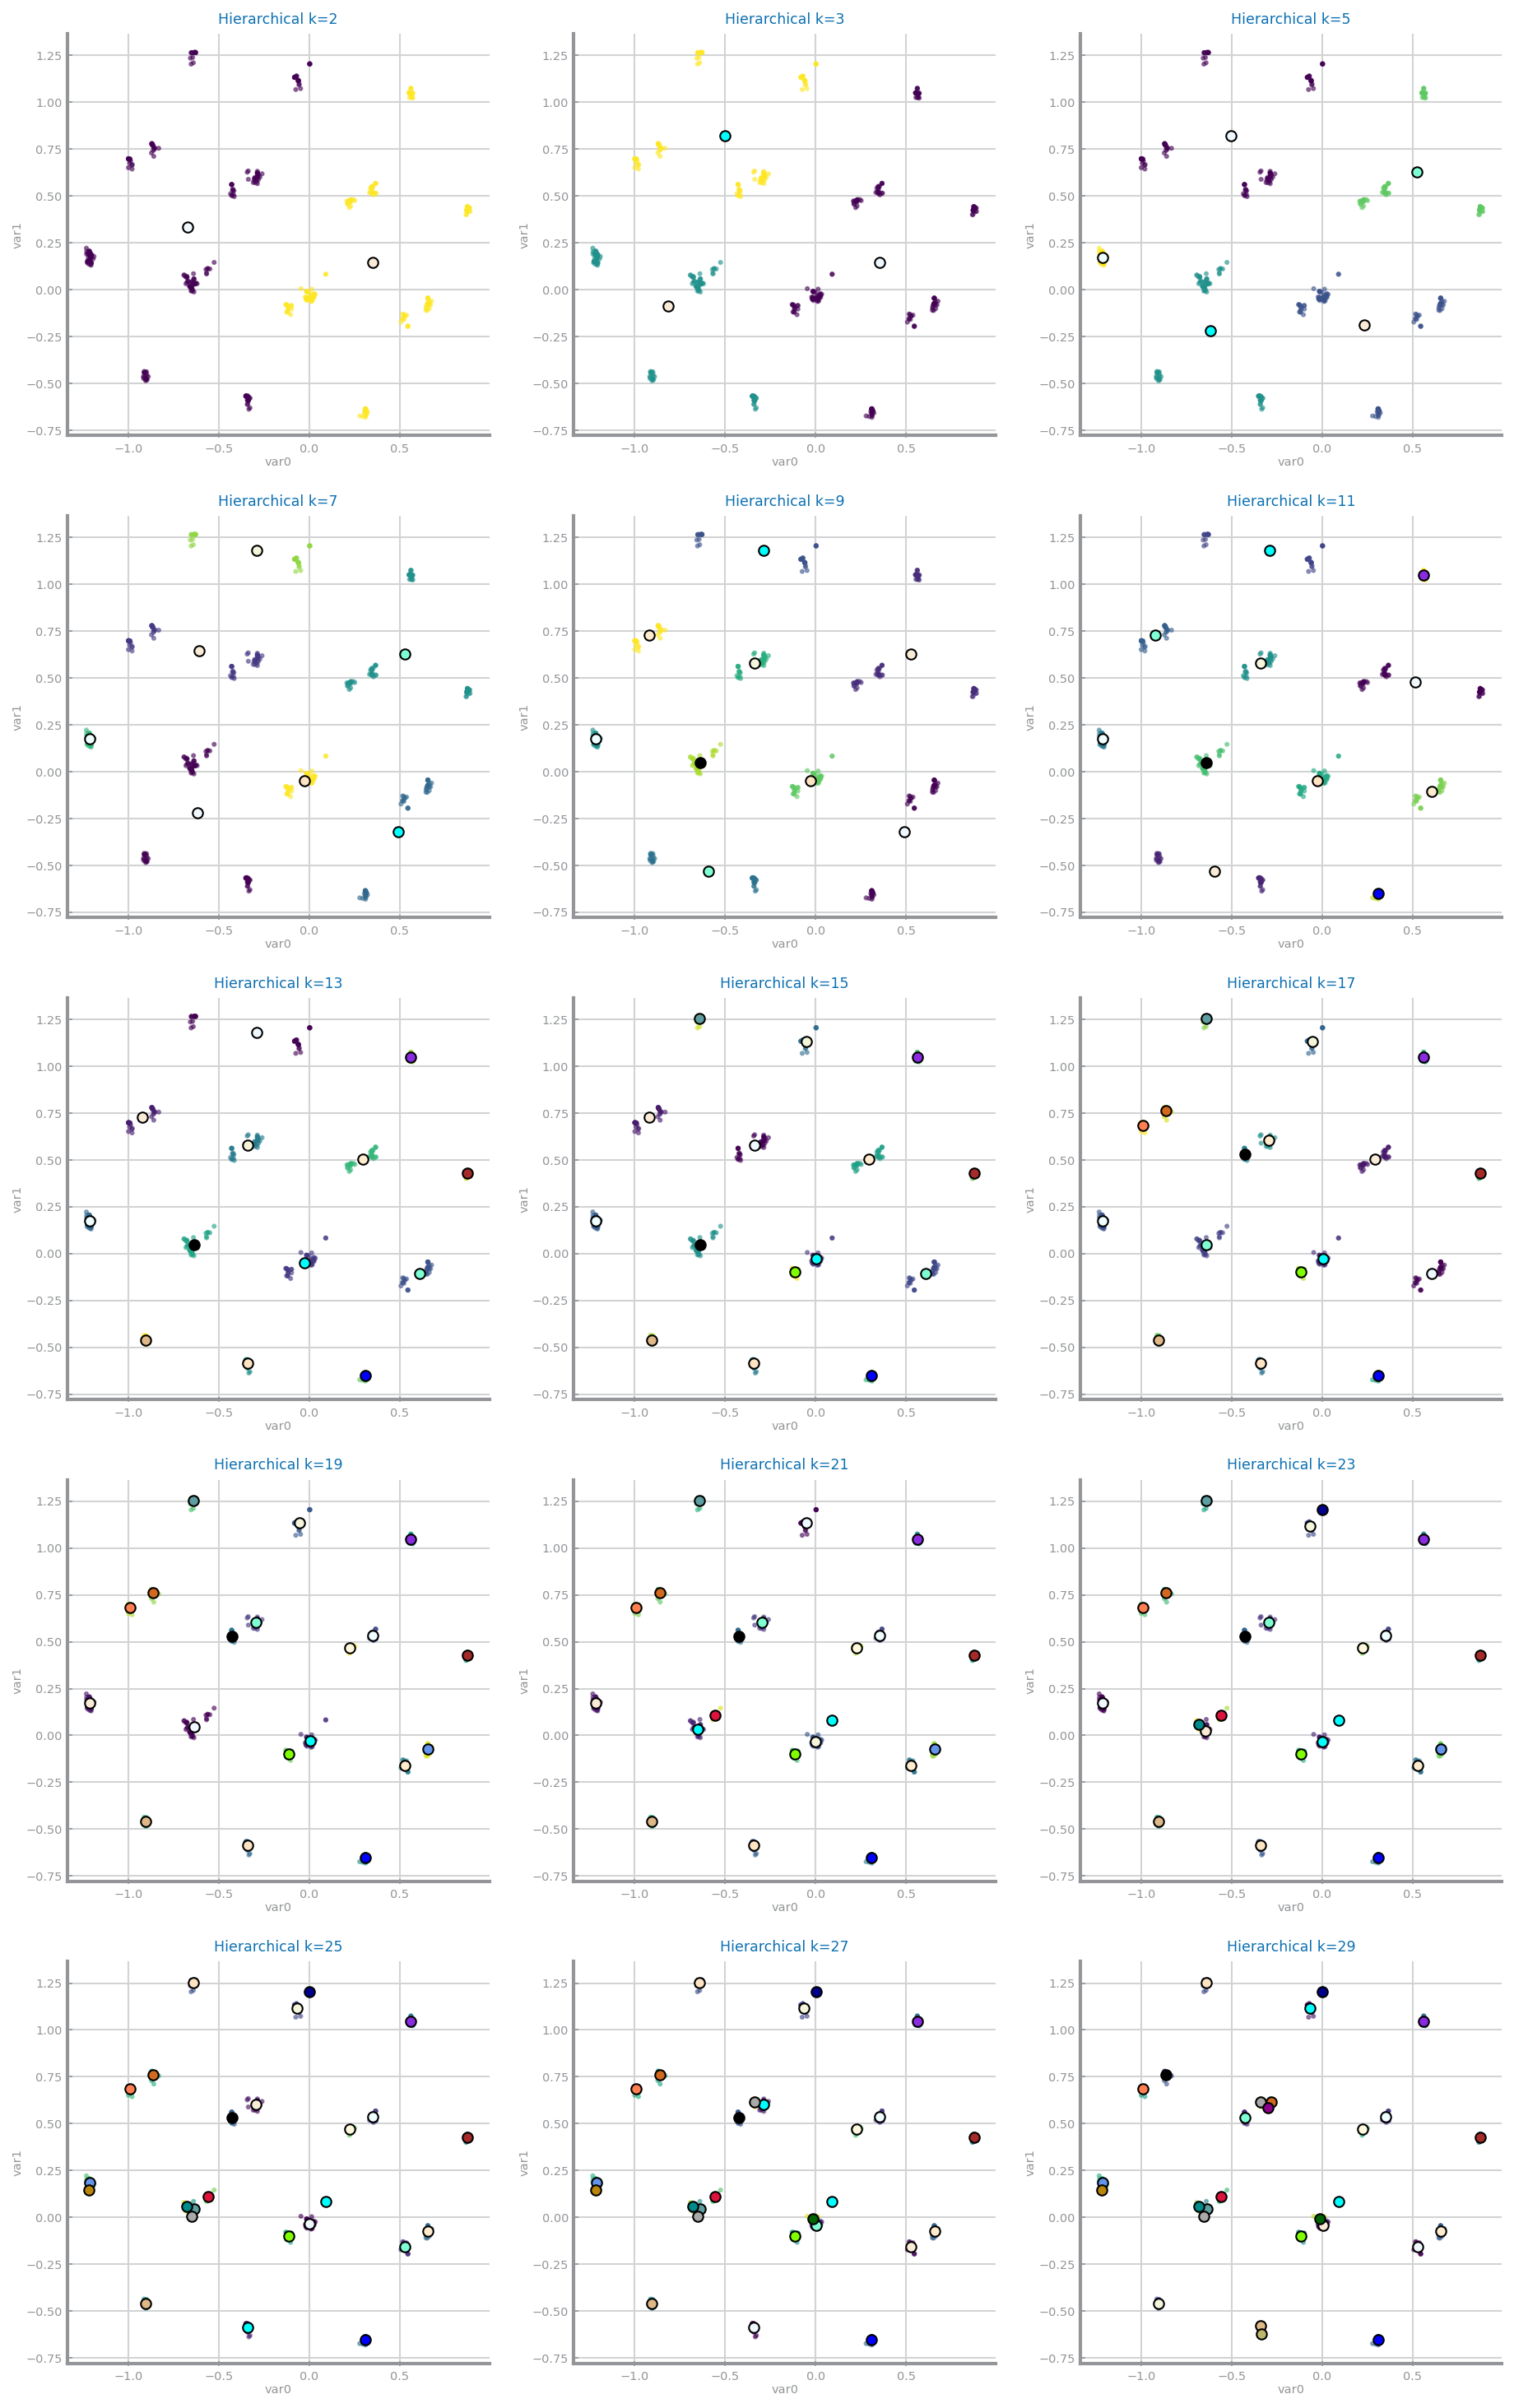

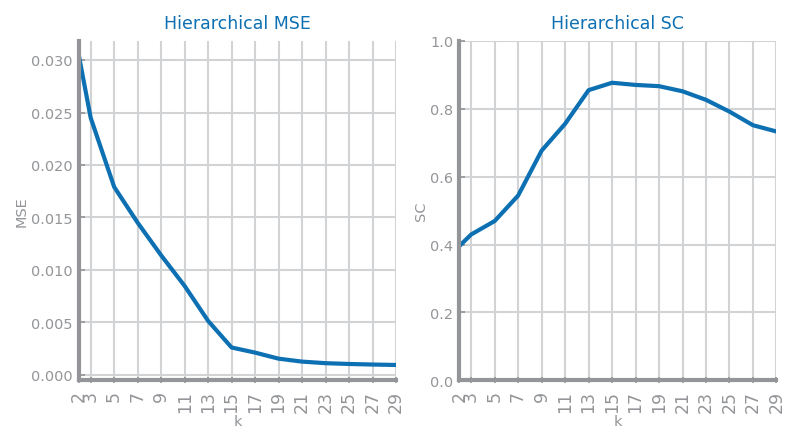

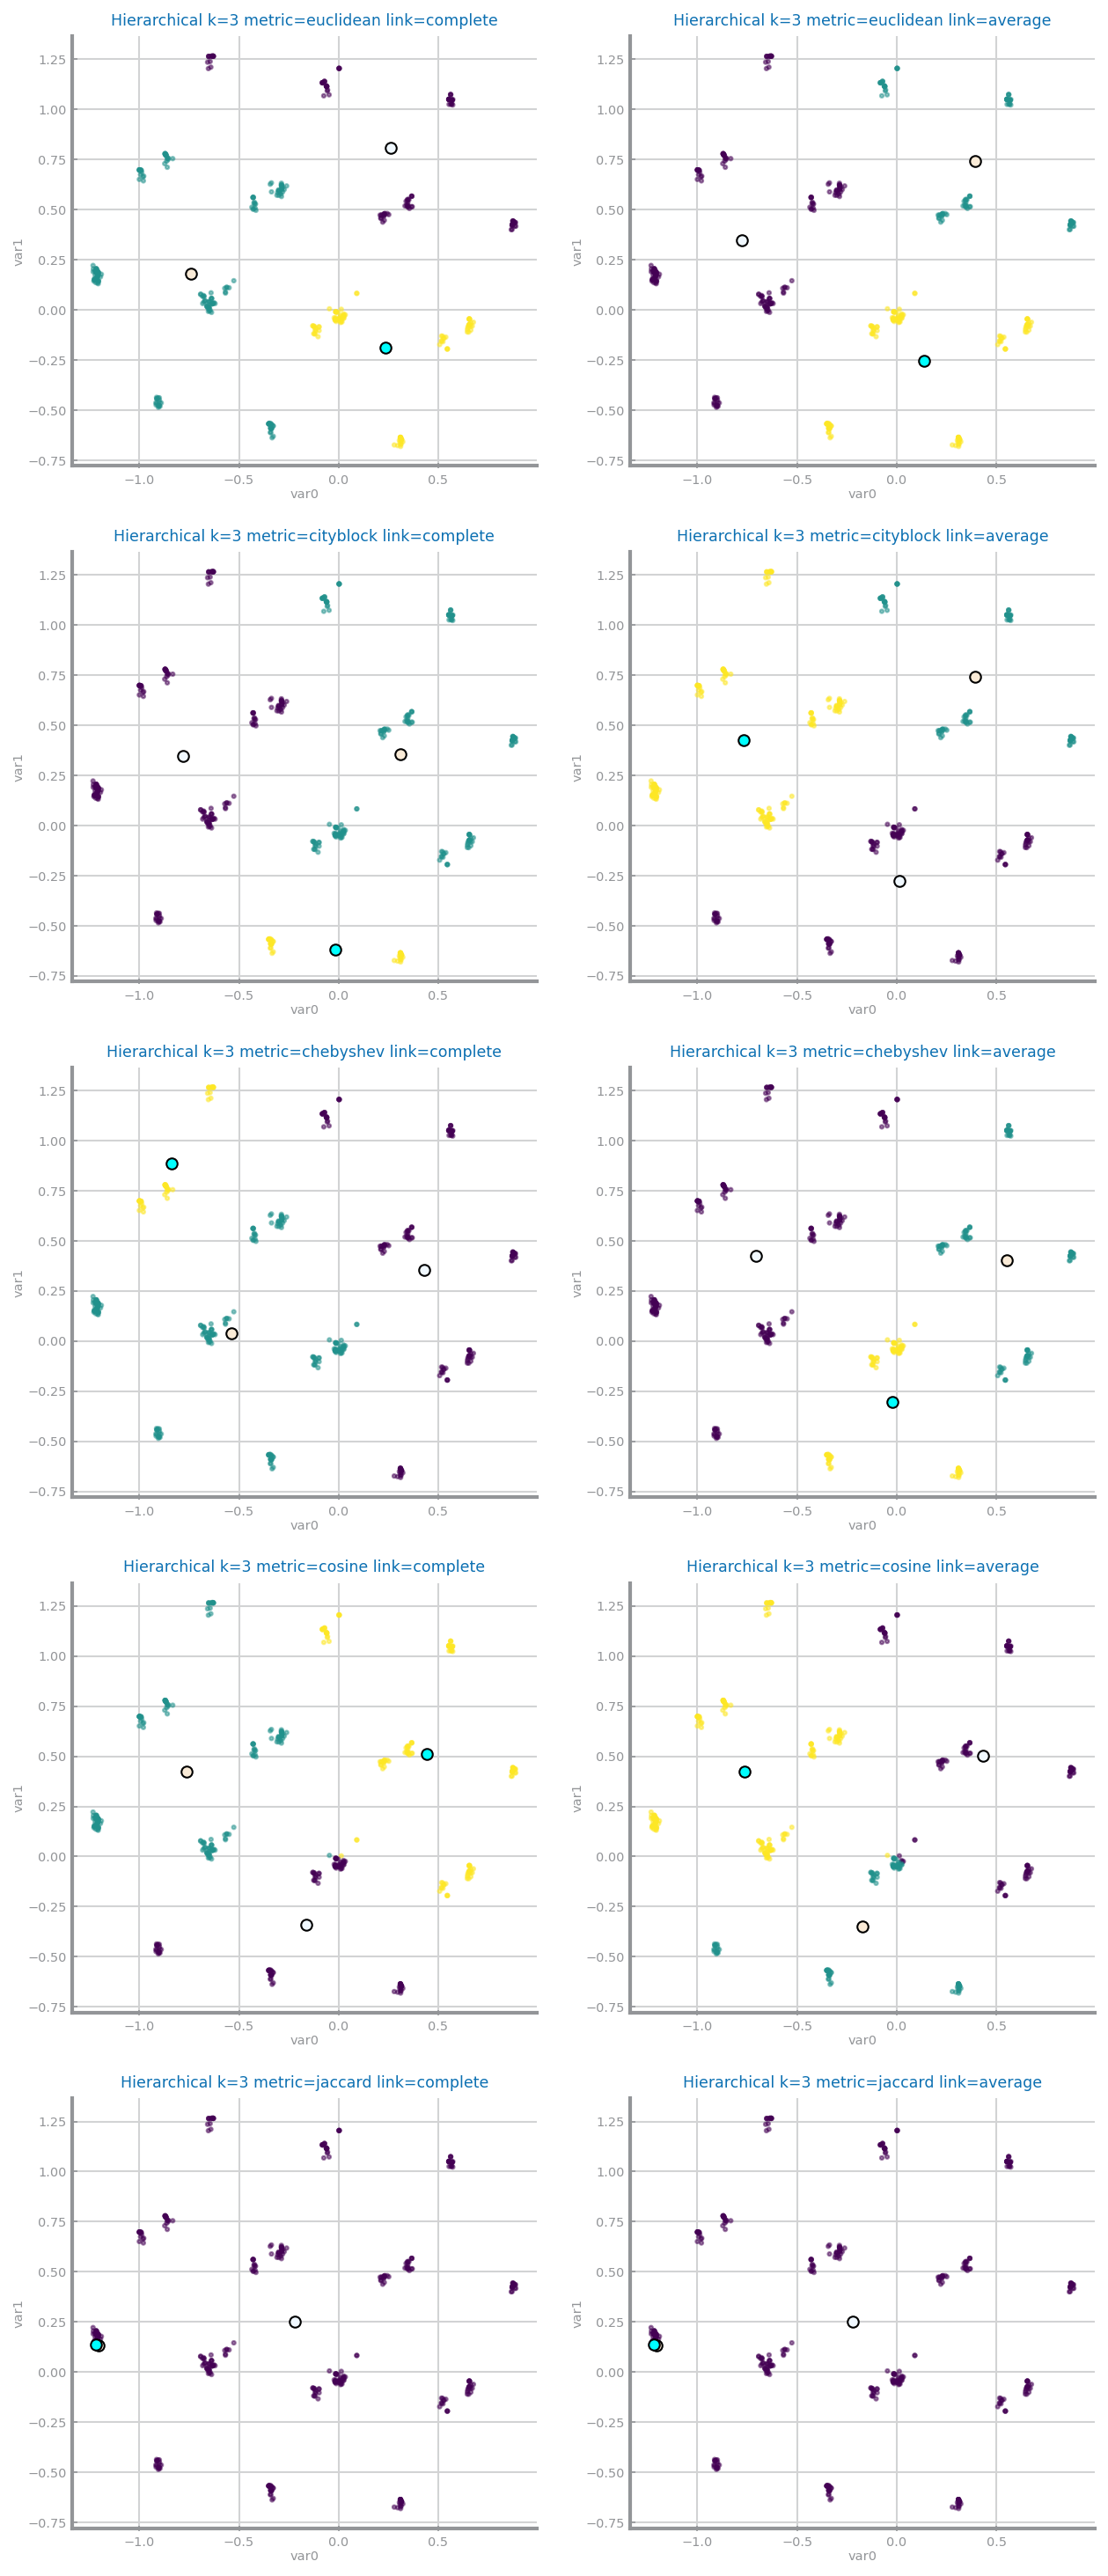

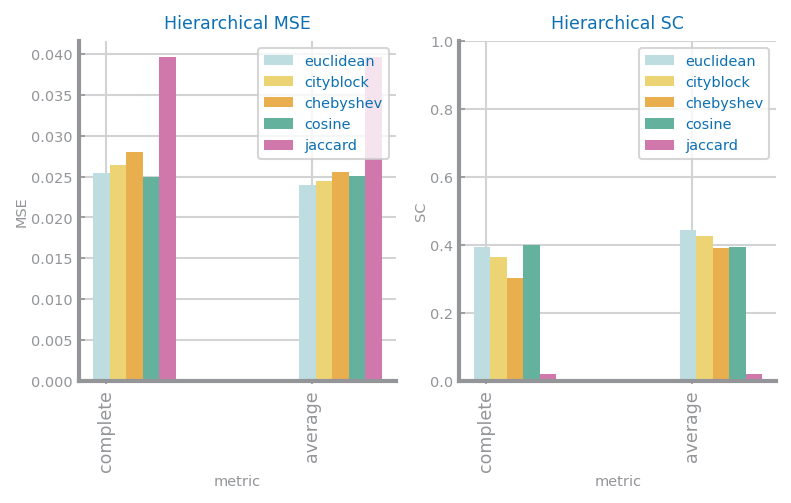

In [42]:
clustering_hierarchical(data, eixo_x, eixo_y)